In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import split_data
from model_builder import RNN
from loss import RMSELoss
from engine import train

c:\Users\nemet\DeepLearning\sc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [367]:
# Prepare paths
data_path = '../data/'
processed_data = os.path.join(data_path, 'processed')

# Load dataframe
data = pd.read_csv(os.path.join(processed_data, 'OneRepMaxData_240324.csv'))

In [368]:
exp_data = pd.concat(
    [
        data.loc[data['PercentageMaxLoad'] <= 20.],
        data.loc[data['PercentageMaxLoad'] >= 95.]
    ]
)

In [369]:
exp_data.to_csv(os.path.join(processed_data, 'OneRepMaxData_010424.csv'), index=False)

In [251]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from custom_dataset import CustomDataset


class Norm(object):
    """
    
    """
    def __call__(self, tensor):
        # Calculate minimal and maximal values contained in tensor
        min_value = tensor.min()
        max_value = tensor.max()

        # Normalization procedure
        normalized = 2 * (tensor - min_value) / (max_value - min_value) - 1

        return normalized
    

class AddGaussianNoise(object):
    """ 
    
    """
    def __init__(self, p=0.5, n_cols=57, mean=0., std=1.):
        self.p = p
        self.n_cols = n_cols
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        if self.p >= torch.rand(1):
            # Split the tensor for augmentation and for save
            tensor_1, tensor_2 = tensor.split(split_size=self.n_cols, dim=1)

            # Add Gaussian noise to the landmark coordinates data
            tensor_1 = tensor_1 + torch.randn_like(tensor_1) * self.std + self.mean
            # Concatenate noised and saved tensors
            tensor = torch.cat((tensor_1, tensor_2), dim=1)
        
        return tensor
    

def create_dataloaders(data, file_ids, batch_size, num_workers, pin_memory):
    """
    
    """
    # Calculate max frequency needed for a padding
    max_frequency = data.groupby(by='FileId').size().max()
    
    # Get a dataframe, dataset, and dataloader for train file ids
    train_data = data.loc[
        data['FileId'].isin(file_ids["train"])]

    train_dataset = CustomDataset(
        train_data,
        max_frequency,
        transform=transforms.Compose(
            [
                Norm(),
                AddGaussianNoise(p=0.5, mean=0., std=0.05)
            ]
        )
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    # Get a dataframe, dataset, and dataloader for validation file ids
    valid_data = data.loc[
        data['FileId'].isin(file_ids["validation"])]
    
    valid_dataset = CustomDataset(
        valid_data, max_frequency, transform=Norm())

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    # Get a dataframe, dataset, and dataloader for test file ids
    test_data = data.loc[
        data['FileId'].isin(file_ids["test"])]
    
    test_dataset = CustomDataset(
        test_data, max_frequency, transform=Norm())

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    return train_dataloader, valid_dataloader, test_dataloader

In [252]:
# Get dictionary of file ids assingned to different datasets
file_ids = split_data(exp_data, [0.8, 0.15, 0.05])

# Setup hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    data=exp_data,
    file_ids=file_ids,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

In [253]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup hyperparameters
INPUT_SIZE = 78
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize RNN model class instance
model = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS)

# Send model to device
model = model.to(device=DEVICE)

In [254]:
NUM_EPOCHS = 1000
LEARNING_RATE = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = RMSELoss()

In [255]:
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  0%|          | 2/1000 [00:00<02:57,  5.63it/s]

Epoch: 1 | train loss: 70.0079 | validation loss: 57.2928
Epoch: 2 | train loss: 68.2365 | validation loss: 57.2842


  0%|          | 4/1000 [00:00<02:15,  7.34it/s]

Epoch: 3 | train loss: 69.0562 | validation loss: 57.2753
Epoch: 4 | train loss: 68.2024 | validation loss: 57.2666


  1%|          | 6/1000 [00:00<02:01,  8.17it/s]

Epoch: 5 | train loss: 69.0545 | validation loss: 57.2575
Epoch: 6 | train loss: 69.6821 | validation loss: 57.2474


  1%|          | 8/1000 [00:01<01:59,  8.31it/s]

Epoch: 7 | train loss: 68.6719 | validation loss: 57.2358
Epoch: 8 | train loss: 68.2451 | validation loss: 57.2223


  1%|          | 10/1000 [00:01<01:54,  8.65it/s]

Epoch: 9 | train loss: 69.2663 | validation loss: 57.2066
Epoch: 10 | train loss: 68.0255 | validation loss: 57.1875


  1%|          | 12/1000 [00:01<01:54,  8.67it/s]

Epoch: 11 | train loss: 70.3569 | validation loss: 57.1639
Epoch: 12 | train loss: 68.0499 | validation loss: 57.1342


  1%|▏         | 14/1000 [00:01<01:52,  8.77it/s]

Epoch: 13 | train loss: 69.1909 | validation loss: 57.0959
Epoch: 14 | train loss: 66.9759 | validation loss: 57.0459


  2%|▏         | 16/1000 [00:01<01:52,  8.76it/s]

Epoch: 15 | train loss: 68.6929 | validation loss: 56.9791
Epoch: 16 | train loss: 68.2981 | validation loss: 56.8916


  2%|▏         | 18/1000 [00:02<02:02,  7.99it/s]

Epoch: 17 | train loss: 67.8745 | validation loss: 56.7799
Epoch: 18 | train loss: 68.3425 | validation loss: 56.6459


  2%|▏         | 20/1000 [00:02<01:59,  8.21it/s]

Epoch: 19 | train loss: 67.3803 | validation loss: 56.4916
Epoch: 20 | train loss: 68.2767 | validation loss: 56.3171


  2%|▏         | 22/1000 [00:02<01:54,  8.56it/s]

Epoch: 21 | train loss: 68.1846 | validation loss: 56.1272
Epoch: 22 | train loss: 68.9538 | validation loss: 55.9265


  2%|▏         | 24/1000 [00:02<01:53,  8.61it/s]

Epoch: 23 | train loss: 65.1287 | validation loss: 55.7157
Epoch: 24 | train loss: 66.3983 | validation loss: 55.4842


  3%|▎         | 26/1000 [00:03<01:52,  8.65it/s]

Epoch: 25 | train loss: 66.9173 | validation loss: 55.2413
Epoch: 26 | train loss: 65.0151 | validation loss: 54.9948


  3%|▎         | 27/1000 [00:03<01:54,  8.51it/s]

Epoch: 27 | train loss: 63.7248 | validation loss: 54.8141


  3%|▎         | 29/1000 [00:03<02:07,  7.60it/s]

Epoch: 28 | train loss: 66.1926 | validation loss: 54.6249
Epoch: 29 | train loss: 66.7150 | validation loss: 54.4247


  3%|▎         | 30/1000 [00:03<02:09,  7.50it/s]

Epoch: 30 | train loss: 65.9111 | validation loss: 54.2322
Epoch: 31 | train loss: 64.6216 | validation loss: 54.0642


  3%|▎         | 33/1000 [00:04<02:11,  7.35it/s]

Epoch: 32 | train loss: 65.8554 | validation loss: 53.9000
Epoch: 33 | train loss: 65.6724 | validation loss: 53.7373


  4%|▎         | 35/1000 [00:04<02:02,  7.91it/s]

Epoch: 34 | train loss: 63.9983 | validation loss: 53.5662
Epoch: 35 | train loss: 63.3797 | validation loss: 53.4118


  4%|▎         | 37/1000 [00:04<01:57,  8.22it/s]

Epoch: 36 | train loss: 65.0679 | validation loss: 53.2578
Epoch: 37 | train loss: 64.2640 | validation loss: 53.1016


  4%|▍         | 39/1000 [00:04<02:00,  7.96it/s]

Epoch: 38 | train loss: 65.6024 | validation loss: 52.8740
Epoch: 39 | train loss: 64.2639 | validation loss: 52.7150


  4%|▍         | 41/1000 [00:05<02:01,  7.92it/s]

Epoch: 40 | train loss: 63.3707 | validation loss: 52.5574
Epoch: 41 | train loss: 64.1993 | validation loss: 52.4010


  4%|▍         | 43/1000 [00:05<01:57,  8.13it/s]

Epoch: 42 | train loss: 63.7320 | validation loss: 52.2458
Epoch: 43 | train loss: 63.2013 | validation loss: 52.0920


  4%|▍         | 45/1000 [00:05<01:52,  8.52it/s]

Epoch: 44 | train loss: 62.2114 | validation loss: 51.9396
Epoch: 45 | train loss: 63.4802 | validation loss: 51.7762


  5%|▍         | 47/1000 [00:05<01:50,  8.63it/s]

Epoch: 46 | train loss: 60.7904 | validation loss: 51.6279
Epoch: 47 | train loss: 62.5885 | validation loss: 51.4813


  5%|▍         | 49/1000 [00:06<01:47,  8.81it/s]

Epoch: 48 | train loss: 63.0510 | validation loss: 51.3360
Epoch: 49 | train loss: 63.2109 | validation loss: 51.1919


  5%|▌         | 51/1000 [00:06<01:50,  8.56it/s]

Epoch: 50 | train loss: 62.4235 | validation loss: 51.0489
Epoch: 51 | train loss: 62.2260 | validation loss: 50.9072


  5%|▌         | 53/1000 [00:06<01:55,  8.20it/s]

Epoch: 52 | train loss: 61.6284 | validation loss: 50.7666
Epoch: 53 | train loss: 62.2718 | validation loss: 50.6272


  6%|▌         | 55/1000 [00:06<01:59,  7.88it/s]

Epoch: 54 | train loss: 62.9199 | validation loss: 50.4885
Epoch: 55 | train loss: 59.5545 | validation loss: 50.3503


  6%|▌         | 57/1000 [00:07<02:15,  6.93it/s]

Epoch: 56 | train loss: 62.1134 | validation loss: 50.2135
Epoch: 57 | train loss: 60.2262 | validation loss: 50.0770


  6%|▌         | 59/1000 [00:07<02:19,  6.77it/s]

Epoch: 58 | train loss: 61.7767 | validation loss: 49.9417
Epoch: 59 | train loss: 61.0456 | validation loss: 49.8068


  6%|▌         | 61/1000 [00:07<02:06,  7.40it/s]

Epoch: 60 | train loss: 61.1792 | validation loss: 49.6727
Epoch: 61 | train loss: 61.5538 | validation loss: 49.5391


  6%|▋         | 63/1000 [00:07<02:02,  7.65it/s]

Epoch: 62 | train loss: 61.1810 | validation loss: 49.4060
Epoch: 63 | train loss: 60.0411 | validation loss: 49.2732


  6%|▋         | 65/1000 [00:08<02:10,  7.15it/s]

Epoch: 64 | train loss: 59.9265 | validation loss: 49.1411
Epoch: 65 | train loss: 60.1103 | validation loss: 49.0097


  7%|▋         | 67/1000 [00:08<02:21,  6.59it/s]

Epoch: 66 | train loss: 61.0181 | validation loss: 48.8787
Epoch: 67 | train loss: 59.8558 | validation loss: 48.7477


  7%|▋         | 69/1000 [00:08<02:04,  7.50it/s]

Epoch: 68 | train loss: 59.8969 | validation loss: 48.6172
Epoch: 69 | train loss: 60.1430 | validation loss: 48.4871


  7%|▋         | 71/1000 [00:09<02:05,  7.40it/s]

Epoch: 70 | train loss: 58.5637 | validation loss: 48.3571
Epoch: 71 | train loss: 59.8117 | validation loss: 48.2277


  7%|▋         | 73/1000 [00:09<02:01,  7.63it/s]

Epoch: 72 | train loss: 59.1020 | validation loss: 48.0985
Epoch: 73 | train loss: 59.8122 | validation loss: 47.9698


  8%|▊         | 75/1000 [00:09<02:08,  7.21it/s]

Epoch: 74 | train loss: 59.0870 | validation loss: 47.8411
Epoch: 75 | train loss: 59.2757 | validation loss: 47.7127


  8%|▊         | 77/1000 [00:10<02:32,  6.04it/s]

Epoch: 76 | train loss: 59.1197 | validation loss: 47.5844
Epoch: 77 | train loss: 58.6095 | validation loss: 47.4564


  8%|▊         | 79/1000 [00:10<02:10,  7.07it/s]

Epoch: 78 | train loss: 57.1456 | validation loss: 47.3287
Epoch: 79 | train loss: 57.3016 | validation loss: 47.2018


  8%|▊         | 81/1000 [00:10<01:58,  7.74it/s]

Epoch: 80 | train loss: 58.5053 | validation loss: 47.0756
Epoch: 81 | train loss: 56.6569 | validation loss: 46.9493


  8%|▊         | 83/1000 [00:10<01:51,  8.22it/s]

Epoch: 82 | train loss: 57.5305 | validation loss: 46.8237
Epoch: 83 | train loss: 54.8016 | validation loss: 46.6983


  8%|▊         | 85/1000 [00:10<01:51,  8.22it/s]

Epoch: 84 | train loss: 56.5629 | validation loss: 46.5740
Epoch: 85 | train loss: 57.5045 | validation loss: 46.4499


  9%|▊         | 87/1000 [00:11<01:55,  7.90it/s]

Epoch: 86 | train loss: 58.3032 | validation loss: 46.3257
Epoch: 87 | train loss: 57.7590 | validation loss: 46.2010


  9%|▉         | 89/1000 [00:11<01:52,  8.08it/s]

Epoch: 88 | train loss: 56.3744 | validation loss: 46.0760
Epoch: 89 | train loss: 56.0103 | validation loss: 45.9514


  9%|▉         | 91/1000 [00:11<01:54,  7.91it/s]

Epoch: 90 | train loss: 56.7592 | validation loss: 45.8274
Epoch: 91 | train loss: 56.0218 | validation loss: 45.7032


  9%|▉         | 93/1000 [00:11<01:50,  8.18it/s]

Epoch: 92 | train loss: 55.5065 | validation loss: 45.5793
Epoch: 93 | train loss: 57.0629 | validation loss: 45.4558


 10%|▉         | 95/1000 [00:12<01:45,  8.60it/s]

Epoch: 94 | train loss: 56.2098 | validation loss: 45.3319
Epoch: 95 | train loss: 55.3743 | validation loss: 45.2080


 10%|▉         | 97/1000 [00:12<01:46,  8.51it/s]

Epoch: 96 | train loss: 56.4043 | validation loss: 45.0848
Epoch: 97 | train loss: 54.7965 | validation loss: 44.9614


 10%|▉         | 99/1000 [00:12<01:51,  8.09it/s]

Epoch: 98 | train loss: 55.8724 | validation loss: 44.8391
Epoch: 99 | train loss: 54.4797 | validation loss: 44.7171


 10%|█         | 101/1000 [00:12<01:48,  8.32it/s]

Epoch: 100 | train loss: 54.3078 | validation loss: 44.5960
Epoch: 101 | train loss: 54.8706 | validation loss: 44.4757


 10%|█         | 103/1000 [00:13<01:51,  8.02it/s]

Epoch: 102 | train loss: 55.5736 | validation loss: 44.3559
Epoch: 103 | train loss: 53.9031 | validation loss: 44.2362


 10%|█         | 105/1000 [00:13<01:59,  7.51it/s]

Epoch: 104 | train loss: 55.4066 | validation loss: 44.1175
Epoch: 105 | train loss: 53.9177 | validation loss: 43.9987


 11%|█         | 107/1000 [00:13<01:55,  7.70it/s]

Epoch: 106 | train loss: 54.5657 | validation loss: 43.8806
Epoch: 107 | train loss: 52.5477 | validation loss: 43.7628


 11%|█         | 109/1000 [00:13<01:57,  7.59it/s]

Epoch: 108 | train loss: 52.4652 | validation loss: 43.6463
Epoch: 109 | train loss: 53.1116 | validation loss: 43.5308


 11%|█         | 111/1000 [00:14<01:51,  7.95it/s]

Epoch: 110 | train loss: 52.8377 | validation loss: 43.4161
Epoch: 111 | train loss: 52.3521 | validation loss: 43.3020


 11%|█▏        | 113/1000 [00:14<01:50,  8.05it/s]

Epoch: 112 | train loss: 53.2368 | validation loss: 43.1888
Epoch: 113 | train loss: 52.8596 | validation loss: 43.0758


 12%|█▏        | 115/1000 [00:14<01:53,  7.81it/s]

Epoch: 114 | train loss: 52.3708 | validation loss: 42.9634
Epoch: 115 | train loss: 51.4371 | validation loss: 42.8519


 12%|█▏        | 117/1000 [00:14<01:53,  7.77it/s]

Epoch: 116 | train loss: 53.2536 | validation loss: 42.7416
Epoch: 117 | train loss: 52.9045 | validation loss: 42.6314


 12%|█▏        | 119/1000 [00:15<01:52,  7.81it/s]

Epoch: 118 | train loss: 52.9150 | validation loss: 42.5218
Epoch: 119 | train loss: 51.9260 | validation loss: 42.4124


 12%|█▏        | 121/1000 [00:15<01:53,  7.72it/s]

Epoch: 120 | train loss: 50.6833 | validation loss: 42.3040
Epoch: 121 | train loss: 52.7220 | validation loss: 42.1973


 12%|█▏        | 123/1000 [00:15<01:53,  7.74it/s]

Epoch: 122 | train loss: 51.5758 | validation loss: 42.0907
Epoch: 123 | train loss: 52.0227 | validation loss: 41.9850


 12%|█▏        | 124/1000 [00:15<01:49,  8.00it/s]

Epoch: 124 | train loss: 51.8826 | validation loss: 41.8800
Epoch: 125 | train loss: 50.8048 | validation loss: 41.7756


 13%|█▎        | 127/1000 [00:16<01:53,  7.72it/s]

Epoch: 126 | train loss: 51.7865 | validation loss: 41.6725
Epoch: 127 | train loss: 51.4607 | validation loss: 41.5699


 13%|█▎        | 129/1000 [00:16<01:52,  7.77it/s]

Epoch: 128 | train loss: 52.2289 | validation loss: 41.4685
Epoch: 129 | train loss: 51.1186 | validation loss: 41.3671


 13%|█▎        | 131/1000 [00:16<01:56,  7.47it/s]

Epoch: 130 | train loss: 50.3775 | validation loss: 41.2665
Epoch: 131 | train loss: 51.4772 | validation loss: 41.1676


 13%|█▎        | 133/1000 [00:17<01:54,  7.55it/s]

Epoch: 132 | train loss: 48.7197 | validation loss: 41.0692
Epoch: 133 | train loss: 50.0036 | validation loss: 40.9730


 14%|█▎        | 135/1000 [00:17<01:52,  7.70it/s]

Epoch: 134 | train loss: 49.2532 | validation loss: 40.8779
Epoch: 135 | train loss: 51.1032 | validation loss: 40.7848


 14%|█▎        | 137/1000 [00:17<01:45,  8.14it/s]

Epoch: 136 | train loss: 49.6732 | validation loss: 40.6916
Epoch: 137 | train loss: 50.5306 | validation loss: 40.5998


 14%|█▍        | 139/1000 [00:17<01:43,  8.32it/s]

Epoch: 138 | train loss: 49.6952 | validation loss: 40.5085
Epoch: 139 | train loss: 48.5838 | validation loss: 40.4183


 14%|█▍        | 141/1000 [00:18<01:42,  8.40it/s]

Epoch: 140 | train loss: 47.7321 | validation loss: 40.3299
Epoch: 141 | train loss: 49.3149 | validation loss: 40.2437


 14%|█▍        | 143/1000 [00:18<01:41,  8.46it/s]

Epoch: 142 | train loss: 48.5514 | validation loss: 40.1583
Epoch: 143 | train loss: 48.5049 | validation loss: 40.0742


 14%|█▍        | 145/1000 [00:18<01:40,  8.48it/s]

Epoch: 144 | train loss: 48.5937 | validation loss: 39.9914
Epoch: 145 | train loss: 48.8456 | validation loss: 39.9097


 15%|█▍        | 147/1000 [00:18<01:41,  8.39it/s]

Epoch: 146 | train loss: 49.4753 | validation loss: 39.8292
Epoch: 147 | train loss: 49.6648 | validation loss: 39.7493


 15%|█▍        | 149/1000 [00:18<01:40,  8.48it/s]

Epoch: 148 | train loss: 48.0893 | validation loss: 39.6694
Epoch: 149 | train loss: 47.4366 | validation loss: 39.5911


 15%|█▌        | 151/1000 [00:19<01:39,  8.51it/s]

Epoch: 150 | train loss: 48.6644 | validation loss: 39.5148
Epoch: 151 | train loss: 48.6802 | validation loss: 39.4395


 15%|█▌        | 153/1000 [00:19<01:38,  8.57it/s]

Epoch: 152 | train loss: 47.4103 | validation loss: 39.3648
Epoch: 153 | train loss: 48.2181 | validation loss: 39.2921


 16%|█▌        | 155/1000 [00:19<01:38,  8.57it/s]

Epoch: 154 | train loss: 47.1402 | validation loss: 39.2202
Epoch: 155 | train loss: 47.7246 | validation loss: 39.1502


 16%|█▌        | 157/1000 [00:19<01:37,  8.62it/s]

Epoch: 156 | train loss: 46.3353 | validation loss: 39.0813
Epoch: 157 | train loss: 47.0618 | validation loss: 39.0145


 16%|█▌        | 159/1000 [00:20<01:38,  8.53it/s]

Epoch: 158 | train loss: 47.3166 | validation loss: 38.9491
Epoch: 159 | train loss: 46.5472 | validation loss: 38.8848


 16%|█▌        | 161/1000 [00:20<01:38,  8.56it/s]

Epoch: 160 | train loss: 46.7349 | validation loss: 38.8221
Epoch: 161 | train loss: 47.2507 | validation loss: 38.7609


 16%|█▋        | 163/1000 [00:20<01:37,  8.58it/s]

Epoch: 162 | train loss: 46.7458 | validation loss: 38.7004
Epoch: 163 | train loss: 47.5836 | validation loss: 38.6415


 16%|█▋        | 165/1000 [00:20<01:39,  8.42it/s]

Epoch: 164 | train loss: 46.2775 | validation loss: 38.5830
Epoch: 165 | train loss: 47.0948 | validation loss: 38.5262


 17%|█▋        | 167/1000 [00:21<01:42,  8.16it/s]

Epoch: 166 | train loss: 47.0018 | validation loss: 38.4705
Epoch: 167 | train loss: 46.1964 | validation loss: 38.4158


 17%|█▋        | 169/1000 [00:21<01:39,  8.37it/s]

Epoch: 168 | train loss: 46.3725 | validation loss: 38.3627
Epoch: 169 | train loss: 46.4188 | validation loss: 38.3110


 17%|█▋        | 170/1000 [00:21<01:37,  8.51it/s]

Epoch: 170 | train loss: 46.6480 | validation loss: 38.2607
Epoch: 171 | train loss: 46.0868 | validation loss: 38.2114


 17%|█▋        | 173/1000 [00:21<01:44,  7.92it/s]

Epoch: 172 | train loss: 46.2408 | validation loss: 38.1637
Epoch: 173 | train loss: 45.7698 | validation loss: 38.1173


 18%|█▊        | 175/1000 [00:22<01:38,  8.40it/s]

Epoch: 174 | train loss: 45.9619 | validation loss: 38.0724
Epoch: 175 | train loss: 45.0684 | validation loss: 38.0288


 18%|█▊        | 177/1000 [00:22<01:43,  7.94it/s]

Epoch: 176 | train loss: 45.9028 | validation loss: 37.9872
Epoch: 177 | train loss: 45.6769 | validation loss: 37.9468


 18%|█▊        | 179/1000 [00:22<01:47,  7.65it/s]

Epoch: 178 | train loss: 45.9943 | validation loss: 37.9079
Epoch: 179 | train loss: 45.2382 | validation loss: 37.8699


 18%|█▊        | 181/1000 [00:22<01:38,  8.31it/s]

Epoch: 180 | train loss: 44.0219 | validation loss: 37.8333
Epoch: 181 | train loss: 44.9531 | validation loss: 37.7989


 18%|█▊        | 183/1000 [00:23<01:34,  8.67it/s]

Epoch: 182 | train loss: 44.7432 | validation loss: 37.7656
Epoch: 183 | train loss: 43.3657 | validation loss: 37.7337


 18%|█▊        | 185/1000 [00:23<01:33,  8.71it/s]

Epoch: 184 | train loss: 45.1225 | validation loss: 37.7041
Epoch: 185 | train loss: 43.4464 | validation loss: 37.6754


 19%|█▊        | 187/1000 [00:23<01:31,  8.86it/s]

Epoch: 186 | train loss: 44.6306 | validation loss: 37.6486
Epoch: 187 | train loss: 44.1114 | validation loss: 37.6229


 19%|█▉        | 189/1000 [00:23<01:30,  8.95it/s]

Epoch: 188 | train loss: 44.6315 | validation loss: 37.5984
Epoch: 189 | train loss: 44.7308 | validation loss: 37.5751


 19%|█▉        | 191/1000 [00:23<01:31,  8.82it/s]

Epoch: 190 | train loss: 44.1528 | validation loss: 37.5526
Epoch: 191 | train loss: 44.2410 | validation loss: 37.5314


 19%|█▉        | 193/1000 [00:24<01:31,  8.77it/s]

Epoch: 192 | train loss: 44.6215 | validation loss: 37.5115
Epoch: 193 | train loss: 43.9801 | validation loss: 37.4926


 20%|█▉        | 195/1000 [00:24<01:31,  8.78it/s]

Epoch: 194 | train loss: 43.2532 | validation loss: 37.4749
Epoch: 195 | train loss: 43.8069 | validation loss: 37.4588


 20%|█▉        | 197/1000 [00:24<01:35,  8.42it/s]

Epoch: 196 | train loss: 44.2969 | validation loss: 37.4439
Epoch: 197 | train loss: 43.5807 | validation loss: 37.4300


 20%|█▉        | 199/1000 [00:24<01:40,  7.95it/s]

Epoch: 198 | train loss: 43.4074 | validation loss: 37.4173
Epoch: 199 | train loss: 43.7775 | validation loss: 37.4058


 20%|██        | 201/1000 [00:25<01:55,  6.92it/s]

Epoch: 200 | train loss: 43.1496 | validation loss: 37.3954
Epoch: 201 | train loss: 43.3189 | validation loss: 37.3863


 20%|██        | 203/1000 [00:25<01:50,  7.21it/s]

Epoch: 202 | train loss: 43.1025 | validation loss: 37.3782
Epoch: 203 | train loss: 43.0600 | validation loss: 37.3713


 20%|██        | 205/1000 [00:25<01:40,  7.90it/s]

Epoch: 204 | train loss: 43.4948 | validation loss: 37.3654
Epoch: 205 | train loss: 43.1561 | validation loss: 37.3605


 21%|██        | 207/1000 [00:26<01:44,  7.62it/s]

Epoch: 206 | train loss: 42.6548 | validation loss: 37.3566
Epoch: 207 | train loss: 43.1841 | validation loss: 37.3537


 21%|██        | 208/1000 [00:26<01:48,  7.32it/s]

Epoch: 208 | train loss: 42.6390 | validation loss: 37.3517


 21%|██        | 209/1000 [00:26<02:03,  6.43it/s]

Epoch: 209 | train loss: 42.7288 | validation loss: 37.3506


 21%|██        | 211/1000 [00:26<02:06,  6.25it/s]

Epoch: 210 | train loss: 42.0743 | validation loss: 37.3504
Epoch: 211 | train loss: 42.3126 | validation loss: 37.3510


 21%|██▏       | 213/1000 [00:26<01:50,  7.13it/s]

Epoch: 212 | train loss: 43.0453 | validation loss: 37.3524
Epoch: 213 | train loss: 42.9328 | validation loss: 37.3546


 22%|██▏       | 215/1000 [00:27<01:43,  7.62it/s]

Epoch: 214 | train loss: 42.4032 | validation loss: 37.3576
Epoch: 215 | train loss: 42.5076 | validation loss: 37.3613


 22%|██▏       | 217/1000 [00:27<01:37,  8.00it/s]

Epoch: 216 | train loss: 42.5301 | validation loss: 37.3657
Epoch: 217 | train loss: 42.2583 | validation loss: 37.3709


 22%|██▏       | 219/1000 [00:27<01:35,  8.19it/s]

Epoch: 218 | train loss: 42.8684 | validation loss: 37.3767
Epoch: 219 | train loss: 42.6018 | validation loss: 37.3833


 22%|██▏       | 221/1000 [00:27<01:33,  8.30it/s]

Epoch: 220 | train loss: 42.9917 | validation loss: 37.3907
Epoch: 221 | train loss: 42.6806 | validation loss: 37.3989


 22%|██▏       | 223/1000 [00:28<01:33,  8.30it/s]

Epoch: 222 | train loss: 42.4679 | validation loss: 37.4081
Epoch: 223 | train loss: 41.8976 | validation loss: 37.4179


 22%|██▎       | 225/1000 [00:28<01:37,  7.96it/s]

Epoch: 224 | train loss: 42.5243 | validation loss: 37.4281
Epoch: 225 | train loss: 42.7489 | validation loss: 37.4388


 23%|██▎       | 226/1000 [00:28<01:41,  7.66it/s]

Epoch: 226 | train loss: 42.1423 | validation loss: 37.4506
Epoch: 227 | train loss: 42.4284 | validation loss: 37.4628


 23%|██▎       | 229/1000 [00:29<01:58,  6.48it/s]

Epoch: 228 | train loss: 42.1973 | validation loss: 37.4759
Epoch: 229 | train loss: 42.5175 | validation loss: 37.4893


 23%|██▎       | 231/1000 [00:29<01:56,  6.59it/s]

Epoch: 230 | train loss: 41.7711 | validation loss: 37.5037
Epoch: 231 | train loss: 41.7639 | validation loss: 37.5182


 23%|██▎       | 233/1000 [00:29<01:45,  7.29it/s]

Epoch: 232 | train loss: 42.0336 | validation loss: 37.5327
Epoch: 233 | train loss: 42.0565 | validation loss: 37.5475


 24%|██▎       | 235/1000 [00:29<01:53,  6.73it/s]

Epoch: 234 | train loss: 41.5850 | validation loss: 37.5629
Epoch: 235 | train loss: 42.0132 | validation loss: 37.5780


 24%|██▎       | 237/1000 [00:30<01:44,  7.27it/s]

Epoch: 236 | train loss: 42.1589 | validation loss: 37.5935
Epoch: 237 | train loss: 41.7439 | validation loss: 37.6099


 24%|██▍       | 239/1000 [00:30<01:39,  7.62it/s]

Epoch: 238 | train loss: 41.8121 | validation loss: 37.6264
Epoch: 239 | train loss: 41.7251 | validation loss: 37.6431


 24%|██▍       | 241/1000 [00:30<01:38,  7.72it/s]

Epoch: 240 | train loss: 41.6843 | validation loss: 37.6600
Epoch: 241 | train loss: 41.3018 | validation loss: 37.6769


 24%|██▍       | 243/1000 [00:30<01:34,  8.03it/s]

Epoch: 242 | train loss: 41.6478 | validation loss: 37.6929
Epoch: 243 | train loss: 41.7466 | validation loss: 37.7091


 24%|██▍       | 245/1000 [00:31<01:33,  8.07it/s]

Epoch: 244 | train loss: 41.7848 | validation loss: 37.7257
Epoch: 245 | train loss: 41.3457 | validation loss: 37.7430


 25%|██▍       | 247/1000 [00:31<01:47,  7.01it/s]

Epoch: 246 | train loss: 41.4454 | validation loss: 37.7596
Epoch: 247 | train loss: 41.9311 | validation loss: 37.7759


 25%|██▍       | 249/1000 [00:31<01:38,  7.61it/s]

Epoch: 248 | train loss: 41.5207 | validation loss: 37.7934
Epoch: 249 | train loss: 41.5548 | validation loss: 37.8108


 25%|██▌       | 251/1000 [00:31<01:35,  7.86it/s]

Epoch: 250 | train loss: 41.2673 | validation loss: 37.8284
Epoch: 251 | train loss: 41.4085 | validation loss: 37.8454


 25%|██▌       | 253/1000 [00:32<01:36,  7.76it/s]

Epoch: 252 | train loss: 41.5722 | validation loss: 37.8624
Epoch: 253 | train loss: 41.5605 | validation loss: 37.8797


 26%|██▌       | 255/1000 [00:32<01:33,  7.97it/s]

Epoch: 254 | train loss: 41.4062 | validation loss: 37.8973
Epoch: 255 | train loss: 41.6900 | validation loss: 37.9147


 26%|██▌       | 257/1000 [00:32<01:33,  7.97it/s]

Epoch: 256 | train loss: 41.5884 | validation loss: 37.9330
Epoch: 257 | train loss: 41.3120 | validation loss: 37.9522


 26%|██▌       | 259/1000 [00:33<01:32,  8.02it/s]

Epoch: 258 | train loss: 41.4572 | validation loss: 37.9707
Epoch: 259 | train loss: 41.4252 | validation loss: 37.9892


 26%|██▌       | 261/1000 [00:33<01:30,  8.18it/s]

Epoch: 260 | train loss: 41.5016 | validation loss: 38.0077
Epoch: 261 | train loss: 41.1106 | validation loss: 38.0264


 26%|██▋       | 263/1000 [00:33<01:30,  8.14it/s]

Epoch: 262 | train loss: 41.1296 | validation loss: 38.0436
Epoch: 263 | train loss: 41.3951 | validation loss: 38.0596


 26%|██▋       | 265/1000 [00:33<01:29,  8.23it/s]

Epoch: 264 | train loss: 41.3929 | validation loss: 38.0756
Epoch: 265 | train loss: 41.1680 | validation loss: 38.0924


 27%|██▋       | 267/1000 [00:33<01:28,  8.25it/s]

Epoch: 266 | train loss: 40.9450 | validation loss: 38.1080
Epoch: 267 | train loss: 41.4041 | validation loss: 38.1220


 27%|██▋       | 269/1000 [00:34<01:28,  8.29it/s]

Epoch: 268 | train loss: 41.3400 | validation loss: 38.1370
Epoch: 269 | train loss: 41.4090 | validation loss: 38.1525


 27%|██▋       | 271/1000 [00:34<01:27,  8.28it/s]

Epoch: 270 | train loss: 41.3635 | validation loss: 38.1682
Epoch: 271 | train loss: 41.4136 | validation loss: 38.1846


 27%|██▋       | 273/1000 [00:34<01:27,  8.27it/s]

Epoch: 272 | train loss: 41.1577 | validation loss: 38.2017
Epoch: 273 | train loss: 41.4047 | validation loss: 38.2177


 28%|██▊       | 275/1000 [00:34<01:27,  8.24it/s]

Epoch: 274 | train loss: 41.4557 | validation loss: 38.2337
Epoch: 275 | train loss: 41.2376 | validation loss: 38.2510


 28%|██▊       | 277/1000 [00:35<01:27,  8.28it/s]

Epoch: 276 | train loss: 40.9153 | validation loss: 38.2681
Epoch: 277 | train loss: 41.3851 | validation loss: 38.2829


 28%|██▊       | 279/1000 [00:35<01:27,  8.22it/s]

Epoch: 278 | train loss: 41.2622 | validation loss: 38.2982
Epoch: 279 | train loss: 41.4636 | validation loss: 38.3127


 28%|██▊       | 281/1000 [00:35<01:35,  7.52it/s]

Epoch: 280 | train loss: 41.0819 | validation loss: 38.3284
Epoch: 281 | train loss: 41.2826 | validation loss: 38.3434


 28%|██▊       | 283/1000 [00:35<01:33,  7.67it/s]

Epoch: 282 | train loss: 41.0361 | validation loss: 38.3586
Epoch: 283 | train loss: 41.2707 | validation loss: 38.3725


 28%|██▊       | 285/1000 [00:36<01:29,  7.95it/s]

Epoch: 284 | train loss: 41.3840 | validation loss: 38.3864
Epoch: 285 | train loss: 41.2283 | validation loss: 38.4015


 29%|██▊       | 286/1000 [00:36<01:28,  8.10it/s]

Epoch: 286 | train loss: 41.1895 | validation loss: 38.4162


 29%|██▉       | 288/1000 [00:36<01:41,  7.05it/s]

Epoch: 287 | train loss: 41.4229 | validation loss: 38.4302
Epoch: 288 | train loss: 41.0848 | validation loss: 38.4456


 29%|██▉       | 290/1000 [00:36<01:32,  7.69it/s]

Epoch: 289 | train loss: 41.4976 | validation loss: 38.4594
Epoch: 290 | train loss: 41.1294 | validation loss: 38.4748


 29%|██▉       | 292/1000 [00:37<01:28,  8.02it/s]

Epoch: 291 | train loss: 40.9282 | validation loss: 38.4888
Epoch: 292 | train loss: 41.1517 | validation loss: 38.5000


 29%|██▉       | 294/1000 [00:37<01:26,  8.14it/s]

Epoch: 293 | train loss: 41.3079 | validation loss: 38.5091
Epoch: 294 | train loss: 41.3944 | validation loss: 38.5197


 30%|██▉       | 296/1000 [00:37<01:26,  8.16it/s]

Epoch: 295 | train loss: 41.2503 | validation loss: 38.5333
Epoch: 296 | train loss: 41.1090 | validation loss: 38.5452


 30%|██▉       | 298/1000 [00:37<01:24,  8.27it/s]

Epoch: 297 | train loss: 41.3434 | validation loss: 38.5552
Epoch: 298 | train loss: 41.1740 | validation loss: 38.5673


 30%|███       | 300/1000 [00:38<01:23,  8.34it/s]

Epoch: 299 | train loss: 41.2573 | validation loss: 38.5765
Epoch: 300 | train loss: 41.0332 | validation loss: 38.5865


 30%|███       | 302/1000 [00:38<01:23,  8.40it/s]

Epoch: 301 | train loss: 41.0373 | validation loss: 38.5938
Epoch: 302 | train loss: 41.2441 | validation loss: 38.5966


 30%|███       | 304/1000 [00:38<01:22,  8.44it/s]

Epoch: 303 | train loss: 41.1731 | validation loss: 38.6003
Epoch: 304 | train loss: 41.3426 | validation loss: 38.6032


 31%|███       | 306/1000 [00:38<01:22,  8.46it/s]

Epoch: 305 | train loss: 41.1456 | validation loss: 38.6069
Epoch: 306 | train loss: 41.1562 | validation loss: 38.5977


 31%|███       | 308/1000 [00:39<01:22,  8.44it/s]

Epoch: 307 | train loss: 41.0472 | validation loss: 38.5603
Epoch: 308 | train loss: 40.9741 | validation loss: 38.5185


 31%|███       | 310/1000 [00:39<01:23,  8.23it/s]

Epoch: 309 | train loss: 41.1297 | validation loss: 38.4477
Epoch: 310 | train loss: 40.8922 | validation loss: 38.4347


 31%|███       | 312/1000 [00:39<01:26,  7.99it/s]

Epoch: 311 | train loss: 41.0851 | validation loss: 38.4126
Epoch: 312 | train loss: 41.0640 | validation loss: 38.2941


 31%|███▏      | 314/1000 [00:39<01:23,  8.23it/s]

Epoch: 313 | train loss: 40.7596 | validation loss: 38.2562
Epoch: 314 | train loss: 40.8930 | validation loss: 38.2138


 32%|███▏      | 316/1000 [00:40<01:20,  8.45it/s]

Epoch: 315 | train loss: 40.8743 | validation loss: 38.1919
Epoch: 316 | train loss: 40.8382 | validation loss: 38.2591


 32%|███▏      | 318/1000 [00:40<01:20,  8.50it/s]

Epoch: 317 | train loss: 40.7911 | validation loss: 38.1930
Epoch: 318 | train loss: 41.0347 | validation loss: 38.1175


 32%|███▏      | 320/1000 [00:40<01:20,  8.42it/s]

Epoch: 319 | train loss: 40.7321 | validation loss: 38.0070
Epoch: 320 | train loss: 40.6480 | validation loss: 37.8202


 32%|███▏      | 322/1000 [00:40<01:20,  8.45it/s]

Epoch: 321 | train loss: 40.4690 | validation loss: 37.7029
Epoch: 322 | train loss: 40.5061 | validation loss: 37.7221


 32%|███▏      | 324/1000 [00:40<01:19,  8.55it/s]

Epoch: 323 | train loss: 40.2936 | validation loss: 37.5063
Epoch: 324 | train loss: 40.0729 | validation loss: 37.4239


 32%|███▎      | 325/1000 [00:41<01:18,  8.57it/s]

Epoch: 325 | train loss: 40.1640 | validation loss: 37.3715
Epoch: 326 | train loss: 40.0947 | validation loss: 37.0753


 33%|███▎      | 328/1000 [00:41<01:29,  7.51it/s]

Epoch: 327 | train loss: 39.9856 | validation loss: 37.1040
Epoch: 328 | train loss: 40.3177 | validation loss: 36.9783


 33%|███▎      | 330/1000 [00:41<01:24,  7.97it/s]

Epoch: 329 | train loss: 39.8020 | validation loss: 37.0034
Epoch: 330 | train loss: 39.8256 | validation loss: 37.2897


 33%|███▎      | 332/1000 [00:41<01:20,  8.27it/s]

Epoch: 331 | train loss: 39.7792 | validation loss: 37.0441
Epoch: 332 | train loss: 39.7922 | validation loss: 36.7373


 33%|███▎      | 334/1000 [00:42<01:26,  7.67it/s]

Epoch: 333 | train loss: 39.6666 | validation loss: 36.6327
Epoch: 334 | train loss: 39.2928 | validation loss: 36.5606


 34%|███▎      | 336/1000 [00:42<01:22,  8.08it/s]

Epoch: 335 | train loss: 39.6993 | validation loss: 36.4223
Epoch: 336 | train loss: 39.4586 | validation loss: 36.2722


 34%|███▍      | 338/1000 [00:42<01:19,  8.29it/s]

Epoch: 337 | train loss: 39.2345 | validation loss: 36.0688
Epoch: 338 | train loss: 39.4139 | validation loss: 35.8943


 34%|███▍      | 340/1000 [00:43<01:23,  7.92it/s]

Epoch: 339 | train loss: 39.2708 | validation loss: 35.7198
Epoch: 340 | train loss: 39.0659 | validation loss: 35.3000


 34%|███▍      | 342/1000 [00:43<01:19,  8.24it/s]

Epoch: 341 | train loss: 38.8710 | validation loss: 34.8732
Epoch: 342 | train loss: 38.5054 | validation loss: 34.5667


 34%|███▍      | 344/1000 [00:43<01:18,  8.39it/s]

Epoch: 343 | train loss: 38.3321 | validation loss: 34.2629
Epoch: 344 | train loss: 38.0827 | validation loss: 33.8603


 35%|███▍      | 346/1000 [00:43<01:22,  7.91it/s]

Epoch: 345 | train loss: 37.5800 | validation loss: 33.5299
Epoch: 346 | train loss: 37.0805 | validation loss: 33.2258


 35%|███▍      | 348/1000 [00:43<01:21,  7.98it/s]

Epoch: 347 | train loss: 36.8433 | validation loss: 33.6203
Epoch: 348 | train loss: 37.6047 | validation loss: 33.0333


 35%|███▌      | 350/1000 [00:44<01:20,  8.11it/s]

Epoch: 349 | train loss: 37.2641 | validation loss: 32.2178
Epoch: 350 | train loss: 36.5565 | validation loss: 31.6876


 35%|███▌      | 352/1000 [00:44<01:19,  8.12it/s]

Epoch: 351 | train loss: 36.8972 | validation loss: 31.6057
Epoch: 352 | train loss: 36.3444 | validation loss: 31.3610


 35%|███▌      | 354/1000 [00:44<01:18,  8.22it/s]

Epoch: 353 | train loss: 35.2516 | validation loss: 30.8806
Epoch: 354 | train loss: 34.2163 | validation loss: 28.7028


 36%|███▌      | 356/1000 [00:44<01:18,  8.25it/s]

Epoch: 355 | train loss: 32.0008 | validation loss: 25.5408
Epoch: 356 | train loss: 31.4776 | validation loss: 25.0918


 36%|███▌      | 358/1000 [00:45<01:18,  8.21it/s]

Epoch: 357 | train loss: 32.3882 | validation loss: 26.8931
Epoch: 358 | train loss: 30.4217 | validation loss: 25.8993


 36%|███▌      | 360/1000 [00:45<01:29,  7.16it/s]

Epoch: 359 | train loss: 30.4741 | validation loss: 25.0793
Epoch: 360 | train loss: 30.1126 | validation loss: 24.3777


 36%|███▌      | 362/1000 [00:45<01:22,  7.73it/s]

Epoch: 361 | train loss: 28.9524 | validation loss: 22.8703
Epoch: 362 | train loss: 28.9677 | validation loss: 21.7299


 36%|███▋      | 364/1000 [00:45<01:18,  8.09it/s]

Epoch: 363 | train loss: 29.6677 | validation loss: 21.3073
Epoch: 364 | train loss: 30.1187 | validation loss: 22.5570


 37%|███▋      | 366/1000 [00:46<01:17,  8.15it/s]

Epoch: 365 | train loss: 29.1743 | validation loss: 22.5291
Epoch: 366 | train loss: 28.7712 | validation loss: 20.7141


 37%|███▋      | 368/1000 [00:46<01:30,  6.99it/s]

Epoch: 367 | train loss: 28.9667 | validation loss: 20.1703
Epoch: 368 | train loss: 27.3532 | validation loss: 19.6946


 37%|███▋      | 370/1000 [00:46<01:25,  7.34it/s]

Epoch: 369 | train loss: 28.2286 | validation loss: 19.2735
Epoch: 370 | train loss: 27.3626 | validation loss: 18.9217


 37%|███▋      | 372/1000 [00:47<01:21,  7.70it/s]

Epoch: 371 | train loss: 26.9071 | validation loss: 18.8232
Epoch: 372 | train loss: 27.6698 | validation loss: 18.5377


 37%|███▋      | 374/1000 [00:47<01:17,  8.07it/s]

Epoch: 373 | train loss: 26.5225 | validation loss: 18.9239
Epoch: 374 | train loss: 26.7175 | validation loss: 19.8808


 38%|███▊      | 376/1000 [00:47<01:17,  8.08it/s]

Epoch: 375 | train loss: 26.5688 | validation loss: 20.0568
Epoch: 376 | train loss: 25.9823 | validation loss: 20.3040


 38%|███▊      | 378/1000 [00:47<01:16,  8.15it/s]

Epoch: 377 | train loss: 24.9122 | validation loss: 20.2184
Epoch: 378 | train loss: 25.1023 | validation loss: 19.9433


 38%|███▊      | 380/1000 [00:48<01:14,  8.29it/s]

Epoch: 379 | train loss: 23.7707 | validation loss: 19.0731
Epoch: 380 | train loss: 23.1698 | validation loss: 18.3317


 38%|███▊      | 382/1000 [00:48<01:14,  8.32it/s]

Epoch: 381 | train loss: 23.0462 | validation loss: 17.8728
Epoch: 382 | train loss: 21.8381 | validation loss: 18.2368


 38%|███▊      | 384/1000 [00:48<01:15,  8.12it/s]

Epoch: 383 | train loss: 21.1001 | validation loss: 19.3147
Epoch: 384 | train loss: 20.4028 | validation loss: 19.2650


 39%|███▊      | 386/1000 [00:48<01:14,  8.23it/s]

Epoch: 385 | train loss: 19.3075 | validation loss: 18.7610
Epoch: 386 | train loss: 18.7223 | validation loss: 15.8353


 39%|███▉      | 388/1000 [00:49<01:15,  8.15it/s]

Epoch: 387 | train loss: 17.1124 | validation loss: 14.8825
Epoch: 388 | train loss: 17.9898 | validation loss: 13.4696


 39%|███▉      | 390/1000 [00:49<01:15,  8.11it/s]

Epoch: 389 | train loss: 18.5746 | validation loss: 13.0815
Epoch: 390 | train loss: 17.6729 | validation loss: 12.7100


 39%|███▉      | 392/1000 [00:49<01:14,  8.19it/s]

Epoch: 391 | train loss: 17.4477 | validation loss: 12.4198
Epoch: 392 | train loss: 17.6196 | validation loss: 12.0717


 39%|███▉      | 394/1000 [00:49<01:15,  8.03it/s]

Epoch: 393 | train loss: 18.2000 | validation loss: 11.8027
Epoch: 394 | train loss: 15.1310 | validation loss: 11.8237


 40%|███▉      | 396/1000 [00:49<01:14,  8.13it/s]

Epoch: 395 | train loss: 15.0336 | validation loss: 10.9511
Epoch: 396 | train loss: 13.8609 | validation loss: 10.6171


 40%|███▉      | 397/1000 [00:50<01:13,  8.19it/s]

Epoch: 397 | train loss: 16.4274 | validation loss: 10.1218


 40%|███▉      | 399/1000 [00:50<01:24,  7.13it/s]

Epoch: 398 | train loss: 16.0833 | validation loss: 9.7149
Epoch: 399 | train loss: 16.0786 | validation loss: 9.5714


 40%|████      | 401/1000 [00:50<01:17,  7.68it/s]

Epoch: 400 | train loss: 11.9634 | validation loss: 9.2163
Epoch: 401 | train loss: 11.7201 | validation loss: 10.1164


 40%|████      | 403/1000 [00:50<01:19,  7.55it/s]

Epoch: 402 | train loss: 15.2245 | validation loss: 9.8664
Epoch: 403 | train loss: 11.4685 | validation loss: 24.8403


 40%|████      | 405/1000 [00:51<01:15,  7.89it/s]

Epoch: 404 | train loss: 19.9728 | validation loss: 14.3363
Epoch: 405 | train loss: 16.6124 | validation loss: 19.7179


 41%|████      | 407/1000 [00:51<01:13,  8.02it/s]

Epoch: 406 | train loss: 19.1198 | validation loss: 20.3374
Epoch: 407 | train loss: 18.9835 | validation loss: 20.5236


 41%|████      | 409/1000 [00:51<01:15,  7.86it/s]

Epoch: 408 | train loss: 20.7898 | validation loss: 20.4505
Epoch: 409 | train loss: 19.8506 | validation loss: 20.1237


 41%|████      | 411/1000 [00:51<01:14,  7.94it/s]

Epoch: 410 | train loss: 20.3584 | validation loss: 19.6211
Epoch: 411 | train loss: 18.1228 | validation loss: 19.0604


 41%|████▏     | 413/1000 [00:52<01:13,  7.97it/s]

Epoch: 412 | train loss: 17.9743 | validation loss: 18.4809
Epoch: 413 | train loss: 16.5040 | validation loss: 17.9131


 42%|████▏     | 415/1000 [00:52<01:12,  8.08it/s]

Epoch: 414 | train loss: 17.1177 | validation loss: 17.3473
Epoch: 415 | train loss: 16.5421 | validation loss: 16.8443


 42%|████▏     | 417/1000 [00:52<01:12,  8.07it/s]

Epoch: 416 | train loss: 12.8258 | validation loss: 16.4000
Epoch: 417 | train loss: 14.7597 | validation loss: 16.0208


 42%|████▏     | 419/1000 [00:52<01:15,  7.66it/s]

Epoch: 418 | train loss: 14.9782 | validation loss: 15.6830
Epoch: 419 | train loss: 15.6135 | validation loss: 15.3885


 42%|████▏     | 421/1000 [00:53<01:12,  7.94it/s]

Epoch: 420 | train loss: 12.3688 | validation loss: 15.1277
Epoch: 421 | train loss: 12.0307 | validation loss: 4.6779


 42%|████▏     | 423/1000 [00:53<01:11,  8.05it/s]

Epoch: 422 | train loss: 11.2011 | validation loss: 4.3304
Epoch: 423 | train loss: 13.2184 | validation loss: 4.0939


 42%|████▎     | 425/1000 [00:53<01:11,  8.04it/s]

Epoch: 424 | train loss: 13.7329 | validation loss: 3.9269
Epoch: 425 | train loss: 13.6295 | validation loss: 3.7678


 43%|████▎     | 427/1000 [00:53<01:10,  8.09it/s]

Epoch: 426 | train loss: 13.5299 | validation loss: 3.5826
Epoch: 427 | train loss: 11.4745 | validation loss: 3.4346


 43%|████▎     | 429/1000 [00:54<01:10,  8.16it/s]

Epoch: 428 | train loss: 11.2835 | validation loss: 3.2730
Epoch: 429 | train loss: 11.0861 | validation loss: 3.0752


 43%|████▎     | 431/1000 [00:54<01:09,  8.20it/s]

Epoch: 430 | train loss: 11.1427 | validation loss: 2.9123
Epoch: 431 | train loss: 11.1049 | validation loss: 2.7729


 43%|████▎     | 433/1000 [00:54<01:09,  8.19it/s]

Epoch: 432 | train loss: 11.0086 | validation loss: 2.6637
Epoch: 433 | train loss: 10.8919 | validation loss: 2.5768


 44%|████▎     | 435/1000 [00:54<01:15,  7.49it/s]

Epoch: 434 | train loss: 10.7056 | validation loss: 2.5079
Epoch: 435 | train loss: 10.7405 | validation loss: 2.4526


 44%|████▎     | 437/1000 [00:55<01:11,  7.84it/s]

Epoch: 436 | train loss: 10.5775 | validation loss: 2.4035
Epoch: 437 | train loss: 10.4700 | validation loss: 2.3607


 44%|████▍     | 439/1000 [00:55<01:09,  8.12it/s]

Epoch: 438 | train loss: 10.3928 | validation loss: 2.3223
Epoch: 439 | train loss: 9.9784 | validation loss: 2.2871


 44%|████▍     | 441/1000 [00:55<01:08,  8.21it/s]

Epoch: 440 | train loss: 11.4437 | validation loss: 2.2620
Epoch: 441 | train loss: 8.6166 | validation loss: 2.2416


 44%|████▍     | 443/1000 [00:55<01:08,  8.16it/s]

Epoch: 442 | train loss: 11.6286 | validation loss: 2.2317
Epoch: 443 | train loss: 11.3219 | validation loss: 2.2325


 44%|████▍     | 445/1000 [00:56<01:07,  8.25it/s]

Epoch: 444 | train loss: 11.3265 | validation loss: 2.2286
Epoch: 445 | train loss: 8.0665 | validation loss: 2.2050


 45%|████▍     | 447/1000 [00:56<01:06,  8.28it/s]

Epoch: 446 | train loss: 8.1547 | validation loss: 2.1801
Epoch: 447 | train loss: 8.0750 | validation loss: 2.1718


 45%|████▍     | 449/1000 [00:56<01:08,  8.00it/s]

Epoch: 448 | train loss: 11.1907 | validation loss: 2.1639
Epoch: 449 | train loss: 11.1890 | validation loss: 2.1403


 45%|████▌     | 451/1000 [00:56<01:08,  8.01it/s]

Epoch: 450 | train loss: 5.5359 | validation loss: 2.1064
Epoch: 451 | train loss: 5.4062 | validation loss: 2.0795


 45%|████▌     | 453/1000 [00:57<01:07,  8.10it/s]

Epoch: 452 | train loss: 5.4632 | validation loss: 2.0443
Epoch: 453 | train loss: 6.5362 | validation loss: 2.0151


 46%|████▌     | 455/1000 [00:57<01:06,  8.14it/s]

Epoch: 454 | train loss: 5.0831 | validation loss: 1.9780
Epoch: 455 | train loss: 5.2847 | validation loss: 1.9587


 46%|████▌     | 457/1000 [00:57<01:06,  8.15it/s]

Epoch: 456 | train loss: 6.2923 | validation loss: 1.9795
Epoch: 457 | train loss: 5.0756 | validation loss: 1.9706


 46%|████▌     | 459/1000 [00:57<01:06,  8.13it/s]

Epoch: 458 | train loss: 5.0433 | validation loss: 1.9424
Epoch: 459 | train loss: 5.0740 | validation loss: 1.9030


 46%|████▌     | 461/1000 [00:58<01:05,  8.17it/s]

Epoch: 460 | train loss: 5.0126 | validation loss: 1.8848
Epoch: 461 | train loss: 6.2533 | validation loss: 1.8878


 46%|████▋     | 463/1000 [00:58<01:05,  8.24it/s]

Epoch: 462 | train loss: 4.9817 | validation loss: 1.8778
Epoch: 463 | train loss: 4.9169 | validation loss: 1.8703


 46%|████▋     | 465/1000 [00:58<01:15,  7.09it/s]

Epoch: 464 | train loss: 4.8946 | validation loss: 1.8663
Epoch: 465 | train loss: 6.0975 | validation loss: 1.8648


 47%|████▋     | 467/1000 [00:58<01:09,  7.63it/s]

Epoch: 466 | train loss: 4.9846 | validation loss: 1.8685
Epoch: 467 | train loss: 4.8674 | validation loss: 1.8837


 47%|████▋     | 469/1000 [00:59<01:10,  7.56it/s]

Epoch: 468 | train loss: 4.8524 | validation loss: 1.9151
Epoch: 469 | train loss: 4.7254 | validation loss: 1.9455


 47%|████▋     | 471/1000 [00:59<01:07,  7.87it/s]

Epoch: 470 | train loss: 4.7434 | validation loss: 1.9722
Epoch: 471 | train loss: 4.7484 | validation loss: 1.9731


 47%|████▋     | 473/1000 [00:59<01:06,  7.90it/s]

Epoch: 472 | train loss: 5.7757 | validation loss: 1.9569
Epoch: 473 | train loss: 4.5333 | validation loss: 1.9496


 48%|████▊     | 475/1000 [00:59<01:05,  7.99it/s]

Epoch: 474 | train loss: 4.7187 | validation loss: 1.9642
Epoch: 475 | train loss: 4.6470 | validation loss: 1.9883


 48%|████▊     | 477/1000 [01:00<01:06,  7.90it/s]

Epoch: 476 | train loss: 5.6336 | validation loss: 2.0446
Epoch: 477 | train loss: 5.6725 | validation loss: 2.0822


 48%|████▊     | 479/1000 [01:00<01:11,  7.32it/s]

Epoch: 478 | train loss: 4.5031 | validation loss: 2.0471
Epoch: 479 | train loss: 4.5471 | validation loss: 2.0155


 48%|████▊     | 481/1000 [01:00<01:07,  7.64it/s]

Epoch: 480 | train loss: 4.4605 | validation loss: 2.0246
Epoch: 481 | train loss: 10.5231 | validation loss: 2.0481


 48%|████▊     | 483/1000 [01:01<01:05,  7.91it/s]

Epoch: 482 | train loss: 10.5082 | validation loss: 2.0644
Epoch: 483 | train loss: 7.1583 | validation loss: 2.0867


 48%|████▊     | 485/1000 [01:01<01:04,  8.01it/s]

Epoch: 484 | train loss: 7.1374 | validation loss: 2.1241
Epoch: 485 | train loss: 10.3151 | validation loss: 2.1605


 49%|████▊     | 487/1000 [01:01<01:03,  8.07it/s]

Epoch: 486 | train loss: 8.8132 | validation loss: 2.1521
Epoch: 487 | train loss: 9.6145 | validation loss: 2.1301


 49%|████▉     | 489/1000 [01:01<01:08,  7.41it/s]

Epoch: 488 | train loss: 6.9404 | validation loss: 2.1072
Epoch: 489 | train loss: 6.9959 | validation loss: 2.1083


 49%|████▉     | 491/1000 [01:02<01:06,  7.66it/s]

Epoch: 490 | train loss: 10.0055 | validation loss: 2.1207
Epoch: 491 | train loss: 9.0598 | validation loss: 2.1310


 49%|████▉     | 493/1000 [01:02<01:07,  7.48it/s]

Epoch: 492 | train loss: 9.7538 | validation loss: 2.1430
Epoch: 493 | train loss: 6.1777 | validation loss: 2.1529


 50%|████▉     | 495/1000 [01:02<01:07,  7.45it/s]

Epoch: 494 | train loss: 6.0922 | validation loss: 2.1733
Epoch: 495 | train loss: 7.7033 | validation loss: 2.2192


 50%|████▉     | 497/1000 [01:02<01:15,  6.63it/s]

Epoch: 496 | train loss: 6.0254 | validation loss: 2.2651
Epoch: 497 | train loss: 7.7351 | validation loss: 2.2840


 50%|████▉     | 499/1000 [01:03<01:06,  7.54it/s]

Epoch: 498 | train loss: 7.6721 | validation loss: 2.2658
Epoch: 499 | train loss: 6.0453 | validation loss: 2.2412


 50%|█████     | 501/1000 [01:03<01:01,  8.10it/s]

Epoch: 500 | train loss: 7.6745 | validation loss: 2.1809
Epoch: 501 | train loss: 6.0988 | validation loss: 2.1487


 50%|█████     | 503/1000 [01:03<01:01,  8.07it/s]

Epoch: 502 | train loss: 6.0875 | validation loss: 2.1516
Epoch: 503 | train loss: 7.6161 | validation loss: 2.1386


 50%|█████     | 505/1000 [01:03<01:01,  8.10it/s]

Epoch: 504 | train loss: 7.5335 | validation loss: 2.1227
Epoch: 505 | train loss: 5.9887 | validation loss: 2.1201


 51%|█████     | 507/1000 [01:04<00:59,  8.29it/s]

Epoch: 506 | train loss: 6.1142 | validation loss: 2.1250
Epoch: 507 | train loss: 6.1029 | validation loss: 2.0966


 51%|█████     | 509/1000 [01:04<00:56,  8.62it/s]

Epoch: 508 | train loss: 7.6517 | validation loss: 2.0209
Epoch: 509 | train loss: 6.1505 | validation loss: 1.9944


 51%|█████     | 511/1000 [01:04<00:55,  8.80it/s]

Epoch: 510 | train loss: 6.0030 | validation loss: 2.0026
Epoch: 511 | train loss: 6.1098 | validation loss: 2.0200


 51%|█████▏    | 513/1000 [01:04<00:55,  8.70it/s]

Epoch: 512 | train loss: 5.9280 | validation loss: 2.0430
Epoch: 513 | train loss: 6.0976 | validation loss: 2.0422


 52%|█████▏    | 515/1000 [01:05<00:55,  8.80it/s]

Epoch: 514 | train loss: 6.0127 | validation loss: 2.0104
Epoch: 515 | train loss: 5.9851 | validation loss: 1.9603


 52%|█████▏    | 517/1000 [01:05<00:55,  8.65it/s]

Epoch: 516 | train loss: 7.5652 | validation loss: 1.9249
Epoch: 517 | train loss: 7.5117 | validation loss: 1.8982


 52%|█████▏    | 519/1000 [01:05<00:55,  8.69it/s]

Epoch: 518 | train loss: 7.5626 | validation loss: 1.8976
Epoch: 519 | train loss: 5.9963 | validation loss: 1.9266


 52%|█████▏    | 521/1000 [01:05<00:54,  8.80it/s]

Epoch: 520 | train loss: 5.8860 | validation loss: 1.9787
Epoch: 521 | train loss: 5.9398 | validation loss: 1.9821


 52%|█████▏    | 523/1000 [01:05<00:55,  8.63it/s]

Epoch: 522 | train loss: 5.9408 | validation loss: 1.9193
Epoch: 523 | train loss: 5.9528 | validation loss: 1.8442


 52%|█████▎    | 525/1000 [01:06<00:54,  8.64it/s]

Epoch: 524 | train loss: 6.0593 | validation loss: 1.8203
Epoch: 525 | train loss: 5.8779 | validation loss: 1.8375


 53%|█████▎    | 526/1000 [01:06<01:00,  7.86it/s]

Epoch: 526 | train loss: 7.5463 | validation loss: 1.8815
Epoch: 527 | train loss: 5.9437 | validation loss: 1.9181


 53%|█████▎    | 529/1000 [01:06<01:09,  6.82it/s]

Epoch: 528 | train loss: 5.9843 | validation loss: 1.9212
Epoch: 529 | train loss: 5.8784 | validation loss: 1.8698


 53%|█████▎    | 531/1000 [01:07<01:06,  7.08it/s]

Epoch: 530 | train loss: 5.9148 | validation loss: 1.8026
Epoch: 531 | train loss: 7.5692 | validation loss: 1.7632


 53%|█████▎    | 533/1000 [01:07<01:00,  7.67it/s]

Epoch: 532 | train loss: 5.9253 | validation loss: 1.7550
Epoch: 533 | train loss: 7.5792 | validation loss: 1.8102


 54%|█████▎    | 535/1000 [01:07<00:57,  8.08it/s]

Epoch: 534 | train loss: 6.0281 | validation loss: 1.8800
Epoch: 535 | train loss: 7.5167 | validation loss: 1.9405


 54%|█████▎    | 537/1000 [01:07<00:57,  8.07it/s]

Epoch: 536 | train loss: 7.5403 | validation loss: 1.9198
Epoch: 537 | train loss: 5.9509 | validation loss: 1.8696


 54%|█████▍    | 539/1000 [01:08<00:59,  7.77it/s]

Epoch: 538 | train loss: 5.9350 | validation loss: 1.8141
Epoch: 539 | train loss: 7.5347 | validation loss: 1.7698


 54%|█████▍    | 541/1000 [01:08<01:04,  7.11it/s]

Epoch: 540 | train loss: 6.0519 | validation loss: 1.7273
Epoch: 541 | train loss: 6.0131 | validation loss: 1.7056


 54%|█████▍    | 543/1000 [01:08<01:00,  7.53it/s]

Epoch: 542 | train loss: 5.9762 | validation loss: 1.7412
Epoch: 543 | train loss: 6.0093 | validation loss: 1.8200


 55%|█████▍    | 545/1000 [01:08<00:59,  7.65it/s]

Epoch: 544 | train loss: 7.5134 | validation loss: 1.8805
Epoch: 545 | train loss: 5.9597 | validation loss: 1.8934


 55%|█████▍    | 546/1000 [01:09<00:58,  7.73it/s]

Epoch: 546 | train loss: 6.0752 | validation loss: 1.8448
Epoch: 547 | train loss: 7.5443 | validation loss: 1.7643


 55%|█████▍    | 549/1000 [01:09<01:00,  7.47it/s]

Epoch: 548 | train loss: 7.5165 | validation loss: 1.7171
Epoch: 549 | train loss: 5.9379 | validation loss: 1.6924


 55%|█████▌    | 550/1000 [01:09<00:59,  7.63it/s]

Epoch: 550 | train loss: 7.4983 | validation loss: 1.6849


 55%|█████▌    | 552/1000 [01:10<01:12,  6.17it/s]

Epoch: 551 | train loss: 7.5759 | validation loss: 1.7057
Epoch: 552 | train loss: 5.9819 | validation loss: 1.7259


 55%|█████▌    | 554/1000 [01:10<01:05,  6.82it/s]

Epoch: 553 | train loss: 5.8767 | validation loss: 1.7366
Epoch: 554 | train loss: 5.9221 | validation loss: 1.7192


 56%|█████▌    | 556/1000 [01:10<00:59,  7.43it/s]

Epoch: 555 | train loss: 5.9466 | validation loss: 1.6955
Epoch: 556 | train loss: 5.9222 | validation loss: 1.6895


 56%|█████▌    | 558/1000 [01:10<00:58,  7.57it/s]

Epoch: 557 | train loss: 5.9083 | validation loss: 1.7037
Epoch: 558 | train loss: 5.9006 | validation loss: 1.7170


 56%|█████▌    | 560/1000 [01:11<00:59,  7.37it/s]

Epoch: 559 | train loss: 6.0184 | validation loss: 1.6977
Epoch: 560 | train loss: 5.9728 | validation loss: 1.6667


 56%|█████▌    | 562/1000 [01:11<00:59,  7.33it/s]

Epoch: 561 | train loss: 6.0393 | validation loss: 1.6400
Epoch: 562 | train loss: 7.4702 | validation loss: 1.6282


 56%|█████▋    | 564/1000 [01:11<01:03,  6.85it/s]

Epoch: 563 | train loss: 5.9151 | validation loss: 1.6221
Epoch: 564 | train loss: 7.5306 | validation loss: 1.6292


 56%|█████▋    | 565/1000 [01:11<01:08,  6.35it/s]

Epoch: 565 | train loss: 7.4911 | validation loss: 1.6684
Epoch: 566 | train loss: 5.9674 | validation loss: 1.7102


 57%|█████▋    | 568/1000 [01:12<01:15,  5.73it/s]

Epoch: 567 | train loss: 5.9610 | validation loss: 1.7413
Epoch: 568 | train loss: 5.9699 | validation loss: 1.7419


 57%|█████▋    | 570/1000 [01:12<01:08,  6.26it/s]

Epoch: 569 | train loss: 7.5395 | validation loss: 1.7060
Epoch: 570 | train loss: 5.9691 | validation loss: 1.6664


 57%|█████▋    | 572/1000 [01:12<01:04,  6.59it/s]

Epoch: 571 | train loss: 5.8561 | validation loss: 1.6272
Epoch: 572 | train loss: 7.5267 | validation loss: 1.6075


 57%|█████▋    | 573/1000 [01:13<01:25,  5.00it/s]

Epoch: 573 | train loss: 7.5316 | validation loss: 1.6113
Epoch: 574 | train loss: 5.9822 | validation loss: 1.6287


 58%|█████▊    | 576/1000 [01:13<01:28,  4.78it/s]

Epoch: 575 | train loss: 7.4722 | validation loss: 1.6683
Epoch: 576 | train loss: 5.8982 | validation loss: 1.7040


 58%|█████▊    | 578/1000 [01:14<01:19,  5.33it/s]

Epoch: 577 | train loss: 5.9139 | validation loss: 1.7068
Epoch: 578 | train loss: 5.9202 | validation loss: 1.6739


 58%|█████▊    | 579/1000 [01:14<01:18,  5.34it/s]

Epoch: 579 | train loss: 5.9665 | validation loss: 1.6364


 58%|█████▊    | 580/1000 [01:14<01:24,  4.96it/s]

Epoch: 580 | train loss: 5.9498 | validation loss: 1.5991


 58%|█████▊    | 582/1000 [01:15<01:20,  5.16it/s]

Epoch: 581 | train loss: 6.0413 | validation loss: 1.5736
Epoch: 582 | train loss: 7.5308 | validation loss: 1.5822


 58%|█████▊    | 583/1000 [01:15<01:14,  5.58it/s]

Epoch: 583 | train loss: 7.4521 | validation loss: 1.5907


 58%|█████▊    | 585/1000 [01:15<01:16,  5.42it/s]

Epoch: 584 | train loss: 7.5356 | validation loss: 1.6093
Epoch: 585 | train loss: 7.4803 | validation loss: 1.6298


 59%|█████▊    | 587/1000 [01:15<01:08,  6.01it/s]

Epoch: 586 | train loss: 5.9469 | validation loss: 1.6470
Epoch: 587 | train loss: 6.0077 | validation loss: 1.6523


 59%|█████▉    | 588/1000 [01:16<01:11,  5.77it/s]

Epoch: 588 | train loss: 7.5063 | validation loss: 1.6396
Epoch: 589 | train loss: 5.8204 | validation loss: 1.5921


 59%|█████▉    | 591/1000 [01:16<01:05,  6.22it/s]

Epoch: 590 | train loss: 5.9892 | validation loss: 1.5481
Epoch: 591 | train loss: 7.4831 | validation loss: 1.5476


 59%|█████▉    | 593/1000 [01:16<01:03,  6.38it/s]

Epoch: 592 | train loss: 5.9895 | validation loss: 1.5512
Epoch: 593 | train loss: 7.5377 | validation loss: 1.5716


 60%|█████▉    | 595/1000 [01:17<00:57,  7.01it/s]

Epoch: 594 | train loss: 5.8652 | validation loss: 1.5959
Epoch: 595 | train loss: 5.8698 | validation loss: 1.6188


 60%|█████▉    | 597/1000 [01:17<00:55,  7.22it/s]

Epoch: 596 | train loss: 5.7225 | validation loss: 1.6266
Epoch: 597 | train loss: 5.8984 | validation loss: 1.6357


 60%|█████▉    | 598/1000 [01:17<00:53,  7.45it/s]

Epoch: 598 | train loss: 6.0590 | validation loss: 1.6446


 60%|██████    | 600/1000 [01:17<01:05,  6.07it/s]

Epoch: 599 | train loss: 7.4317 | validation loss: 1.6265
Epoch: 600 | train loss: 7.3928 | validation loss: 1.6086


 60%|██████    | 602/1000 [01:18<00:58,  6.86it/s]

Epoch: 601 | train loss: 7.4561 | validation loss: 1.5765
Epoch: 602 | train loss: 5.9519 | validation loss: 1.5569


 60%|██████    | 604/1000 [01:18<00:55,  7.16it/s]

Epoch: 603 | train loss: 6.0016 | validation loss: 1.5577
Epoch: 604 | train loss: 7.4925 | validation loss: 1.5926


 61%|██████    | 606/1000 [01:18<00:52,  7.46it/s]

Epoch: 605 | train loss: 7.4595 | validation loss: 1.6009
Epoch: 606 | train loss: 5.8953 | validation loss: 1.6073


 61%|██████    | 608/1000 [01:19<00:53,  7.28it/s]

Epoch: 607 | train loss: 5.9196 | validation loss: 1.6093
Epoch: 608 | train loss: 5.8819 | validation loss: 1.5788


 61%|██████    | 610/1000 [01:19<00:55,  7.07it/s]

Epoch: 609 | train loss: 5.9587 | validation loss: 1.5281
Epoch: 610 | train loss: 5.8678 | validation loss: 1.5022


 61%|██████    | 612/1000 [01:19<00:52,  7.39it/s]

Epoch: 611 | train loss: 5.7487 | validation loss: 1.5176
Epoch: 612 | train loss: 5.8665 | validation loss: 1.5624


 61%|██████▏   | 614/1000 [01:19<00:49,  7.86it/s]

Epoch: 613 | train loss: 7.4547 | validation loss: 1.5754
Epoch: 614 | train loss: 5.9187 | validation loss: 1.5784


 62%|██████▏   | 616/1000 [01:20<00:46,  8.17it/s]

Epoch: 615 | train loss: 5.9673 | validation loss: 1.5711
Epoch: 616 | train loss: 7.5138 | validation loss: 1.5470


 62%|██████▏   | 618/1000 [01:20<00:44,  8.50it/s]

Epoch: 617 | train loss: 7.4753 | validation loss: 1.5133
Epoch: 618 | train loss: 7.3720 | validation loss: 1.4925


 62%|██████▏   | 620/1000 [01:20<00:44,  8.58it/s]

Epoch: 619 | train loss: 5.8787 | validation loss: 1.4730
Epoch: 620 | train loss: 7.4341 | validation loss: 1.4874


 62%|██████▏   | 622/1000 [01:20<00:43,  8.61it/s]

Epoch: 621 | train loss: 7.4528 | validation loss: 1.5240
Epoch: 622 | train loss: 5.9686 | validation loss: 1.5521


 62%|██████▏   | 623/1000 [01:20<00:43,  8.63it/s]

Epoch: 623 | train loss: 5.7615 | validation loss: 1.5514


 62%|██████▎   | 625/1000 [01:21<00:59,  6.28it/s]

Epoch: 624 | train loss: 7.4080 | validation loss: 1.5107
Epoch: 625 | train loss: 5.9422 | validation loss: 1.4837


 63%|██████▎   | 627/1000 [01:21<01:01,  6.09it/s]

Epoch: 626 | train loss: 5.8569 | validation loss: 1.4716
Epoch: 627 | train loss: 5.7548 | validation loss: 1.4777


 63%|██████▎   | 629/1000 [01:21<00:52,  7.00it/s]

Epoch: 628 | train loss: 7.4699 | validation loss: 1.5063
Epoch: 629 | train loss: 5.8365 | validation loss: 1.5264


 63%|██████▎   | 631/1000 [01:22<00:48,  7.61it/s]

Epoch: 630 | train loss: 5.8734 | validation loss: 1.5282
Epoch: 631 | train loss: 5.9007 | validation loss: 1.5161


 63%|██████▎   | 633/1000 [01:22<00:45,  7.98it/s]

Epoch: 632 | train loss: 7.4704 | validation loss: 1.5227
Epoch: 633 | train loss: 5.8575 | validation loss: 1.5272


 64%|██████▎   | 635/1000 [01:22<00:44,  8.14it/s]

Epoch: 634 | train loss: 5.9137 | validation loss: 1.5093
Epoch: 635 | train loss: 5.8030 | validation loss: 1.5009


 64%|██████▎   | 637/1000 [01:22<00:43,  8.30it/s]

Epoch: 636 | train loss: 5.9136 | validation loss: 1.4974
Epoch: 637 | train loss: 5.8178 | validation loss: 1.4758


 64%|██████▍   | 639/1000 [01:23<00:43,  8.31it/s]

Epoch: 638 | train loss: 6.0809 | validation loss: 1.4688
Epoch: 639 | train loss: 5.8074 | validation loss: 1.4782


 64%|██████▍   | 641/1000 [01:23<00:43,  8.25it/s]

Epoch: 640 | train loss: 5.8925 | validation loss: 1.4975
Epoch: 641 | train loss: 5.8863 | validation loss: 1.5265


 64%|██████▍   | 643/1000 [01:23<00:43,  8.27it/s]

Epoch: 642 | train loss: 5.9434 | validation loss: 1.5127
Epoch: 643 | train loss: 5.8385 | validation loss: 1.4711


 64%|██████▍   | 645/1000 [01:23<00:42,  8.38it/s]

Epoch: 644 | train loss: 5.8755 | validation loss: 1.4306
Epoch: 645 | train loss: 5.8689 | validation loss: 1.4374


 65%|██████▍   | 647/1000 [01:24<00:42,  8.24it/s]

Epoch: 646 | train loss: 7.4536 | validation loss: 1.4698
Epoch: 647 | train loss: 5.7906 | validation loss: 1.4937


 65%|██████▍   | 649/1000 [01:24<00:46,  7.62it/s]

Epoch: 648 | train loss: 7.4646 | validation loss: 1.5180
Epoch: 649 | train loss: 5.8751 | validation loss: 1.5238


 65%|██████▌   | 651/1000 [01:24<00:43,  8.06it/s]

Epoch: 650 | train loss: 5.8960 | validation loss: 1.4938
Epoch: 651 | train loss: 5.8904 | validation loss: 1.4231


 65%|██████▌   | 653/1000 [01:24<00:43,  7.98it/s]

Epoch: 652 | train loss: 7.4842 | validation loss: 1.3835
Epoch: 653 | train loss: 5.9846 | validation loss: 1.3795


 66%|██████▌   | 655/1000 [01:25<00:42,  8.19it/s]

Epoch: 654 | train loss: 7.4619 | validation loss: 1.3726
Epoch: 655 | train loss: 7.3719 | validation loss: 1.4489


 66%|██████▌   | 657/1000 [01:25<00:40,  8.47it/s]

Epoch: 656 | train loss: 5.7827 | validation loss: 1.4852
Epoch: 657 | train loss: 7.4849 | validation loss: 1.4928


 66%|██████▌   | 659/1000 [01:25<00:39,  8.59it/s]

Epoch: 658 | train loss: 5.8361 | validation loss: 1.4849
Epoch: 659 | train loss: 7.3867 | validation loss: 1.4781


 66%|██████▌   | 661/1000 [01:25<00:38,  8.69it/s]

Epoch: 660 | train loss: 7.5349 | validation loss: 1.4721
Epoch: 661 | train loss: 5.8610 | validation loss: 1.4557


 66%|██████▋   | 663/1000 [01:25<00:38,  8.76it/s]

Epoch: 662 | train loss: 5.8911 | validation loss: 1.4382
Epoch: 663 | train loss: 5.9075 | validation loss: 1.4221


 66%|██████▋   | 665/1000 [01:26<00:38,  8.76it/s]

Epoch: 664 | train loss: 7.4387 | validation loss: 1.4031
Epoch: 665 | train loss: 5.8302 | validation loss: 1.3715


 67%|██████▋   | 667/1000 [01:26<00:38,  8.76it/s]

Epoch: 666 | train loss: 5.8842 | validation loss: 1.3738
Epoch: 667 | train loss: 5.8779 | validation loss: 1.4197


 67%|██████▋   | 669/1000 [01:26<00:37,  8.77it/s]

Epoch: 668 | train loss: 5.8640 | validation loss: 1.4613
Epoch: 669 | train loss: 5.8872 | validation loss: 1.4946


 67%|██████▋   | 671/1000 [01:26<00:37,  8.81it/s]

Epoch: 670 | train loss: 5.8773 | validation loss: 1.4946
Epoch: 671 | train loss: 7.4168 | validation loss: 1.4610


 67%|██████▋   | 673/1000 [01:27<00:43,  7.52it/s]

Epoch: 672 | train loss: 5.8297 | validation loss: 1.4318
Epoch: 673 | train loss: 7.3808 | validation loss: 1.4182


 68%|██████▊   | 675/1000 [01:27<00:40,  8.08it/s]

Epoch: 674 | train loss: 7.4072 | validation loss: 1.4233
Epoch: 675 | train loss: 5.8990 | validation loss: 1.4374


 68%|██████▊   | 677/1000 [01:27<00:38,  8.38it/s]

Epoch: 676 | train loss: 7.4194 | validation loss: 1.4590
Epoch: 677 | train loss: 7.3384 | validation loss: 1.4617


 68%|██████▊   | 679/1000 [01:27<00:37,  8.60it/s]

Epoch: 678 | train loss: 5.9294 | validation loss: 1.4594
Epoch: 679 | train loss: 7.3627 | validation loss: 1.4333


 68%|██████▊   | 681/1000 [01:28<00:36,  8.75it/s]

Epoch: 680 | train loss: 5.8759 | validation loss: 1.4072
Epoch: 681 | train loss: 5.8551 | validation loss: 1.3852


 68%|██████▊   | 683/1000 [01:28<00:36,  8.78it/s]

Epoch: 682 | train loss: 5.8269 | validation loss: 1.3734
Epoch: 683 | train loss: 5.8912 | validation loss: 1.3739


 68%|██████▊   | 685/1000 [01:28<00:40,  7.74it/s]

Epoch: 684 | train loss: 5.8117 | validation loss: 1.3939
Epoch: 685 | train loss: 5.8318 | validation loss: 1.4209


 69%|██████▊   | 687/1000 [01:28<00:38,  8.05it/s]

Epoch: 686 | train loss: 7.4203 | validation loss: 1.4369
Epoch: 687 | train loss: 7.4026 | validation loss: 1.4458


 69%|██████▉   | 689/1000 [01:29<00:37,  8.30it/s]

Epoch: 688 | train loss: 5.8088 | validation loss: 1.4491
Epoch: 689 | train loss: 5.8397 | validation loss: 1.4407


 69%|██████▉   | 691/1000 [01:29<00:36,  8.44it/s]

Epoch: 690 | train loss: 5.8339 | validation loss: 1.4319
Epoch: 691 | train loss: 5.9064 | validation loss: 1.4279


 69%|██████▉   | 693/1000 [01:29<00:36,  8.45it/s]

Epoch: 692 | train loss: 7.4528 | validation loss: 1.4307
Epoch: 693 | train loss: 7.4363 | validation loss: 1.4515


 70%|██████▉   | 695/1000 [01:29<00:39,  7.79it/s]

Epoch: 694 | train loss: 5.7873 | validation loss: 1.4581
Epoch: 695 | train loss: 7.3494 | validation loss: 1.4359


 70%|██████▉   | 697/1000 [01:30<00:37,  8.16it/s]

Epoch: 696 | train loss: 7.4772 | validation loss: 1.4130
Epoch: 697 | train loss: 7.3906 | validation loss: 1.3944


 70%|██████▉   | 699/1000 [01:30<00:36,  8.34it/s]

Epoch: 698 | train loss: 5.9308 | validation loss: 1.3741
Epoch: 699 | train loss: 7.3954 | validation loss: 1.3719


 70%|███████   | 701/1000 [01:30<00:35,  8.46it/s]

Epoch: 700 | train loss: 5.8606 | validation loss: 1.3795
Epoch: 701 | train loss: 7.4377 | validation loss: 1.4136


 70%|███████   | 703/1000 [01:30<00:34,  8.55it/s]

Epoch: 702 | train loss: 5.7893 | validation loss: 1.4400
Epoch: 703 | train loss: 5.8747 | validation loss: 1.4361


 70%|███████   | 705/1000 [01:30<00:34,  8.60it/s]

Epoch: 704 | train loss: 5.8628 | validation loss: 1.4062
Epoch: 705 | train loss: 5.8109 | validation loss: 1.3653


 71%|███████   | 707/1000 [01:31<00:34,  8.52it/s]

Epoch: 706 | train loss: 7.4400 | validation loss: 1.3426
Epoch: 707 | train loss: 5.8884 | validation loss: 1.3341


 71%|███████   | 709/1000 [01:31<00:33,  8.61it/s]

Epoch: 708 | train loss: 7.3662 | validation loss: 1.3527
Epoch: 709 | train loss: 5.6963 | validation loss: 1.3752


 71%|███████   | 711/1000 [01:31<00:35,  8.15it/s]

Epoch: 710 | train loss: 5.8466 | validation loss: 1.3974
Epoch: 711 | train loss: 5.8069 | validation loss: 1.4079


 71%|███████▏  | 713/1000 [01:31<00:34,  8.33it/s]

Epoch: 712 | train loss: 5.8219 | validation loss: 1.3876
Epoch: 713 | train loss: 7.3359 | validation loss: 1.3422


 72%|███████▏  | 715/1000 [01:32<00:33,  8.48it/s]

Epoch: 714 | train loss: 5.8270 | validation loss: 1.3223
Epoch: 715 | train loss: 5.8418 | validation loss: 1.3184


 72%|███████▏  | 717/1000 [01:32<00:37,  7.51it/s]

Epoch: 716 | train loss: 7.3823 | validation loss: 1.3260
Epoch: 717 | train loss: 7.3943 | validation loss: 1.3553


 72%|███████▏  | 719/1000 [01:32<00:35,  8.01it/s]

Epoch: 718 | train loss: 7.4117 | validation loss: 1.3973
Epoch: 719 | train loss: 5.8367 | validation loss: 1.4198


 72%|███████▏  | 721/1000 [01:32<00:35,  7.94it/s]

Epoch: 720 | train loss: 5.6998 | validation loss: 1.4169
Epoch: 721 | train loss: 5.8006 | validation loss: 1.4039


 72%|███████▏  | 723/1000 [01:33<00:33,  8.29it/s]

Epoch: 722 | train loss: 7.4333 | validation loss: 1.3917
Epoch: 723 | train loss: 5.8594 | validation loss: 1.3738


 72%|███████▎  | 725/1000 [01:33<00:33,  8.30it/s]

Epoch: 724 | train loss: 5.8256 | validation loss: 1.3584
Epoch: 725 | train loss: 5.8348 | validation loss: 1.3494


 73%|███████▎  | 727/1000 [01:33<00:32,  8.37it/s]

Epoch: 726 | train loss: 5.7698 | validation loss: 1.3396
Epoch: 727 | train loss: 5.8615 | validation loss: 1.3479


 73%|███████▎  | 729/1000 [01:33<00:31,  8.48it/s]

Epoch: 728 | train loss: 7.3756 | validation loss: 1.3824
Epoch: 729 | train loss: 7.3749 | validation loss: 1.3949


 73%|███████▎  | 731/1000 [01:34<00:31,  8.60it/s]

Epoch: 730 | train loss: 5.7704 | validation loss: 1.3938
Epoch: 731 | train loss: 5.7723 | validation loss: 1.3732


 73%|███████▎  | 733/1000 [01:34<00:30,  8.68it/s]

Epoch: 732 | train loss: 5.7314 | validation loss: 1.3466
Epoch: 733 | train loss: 5.7180 | validation loss: 1.3189


 74%|███████▎  | 735/1000 [01:34<00:30,  8.76it/s]

Epoch: 734 | train loss: 5.7387 | validation loss: 1.2972
Epoch: 735 | train loss: 7.3881 | validation loss: 1.2805


 74%|███████▎  | 737/1000 [01:34<00:29,  8.78it/s]

Epoch: 736 | train loss: 7.4281 | validation loss: 1.3136
Epoch: 737 | train loss: 5.7776 | validation loss: 1.3407


 74%|███████▍  | 739/1000 [01:35<00:33,  7.76it/s]

Epoch: 738 | train loss: 7.3545 | validation loss: 1.3982
Epoch: 739 | train loss: 5.8797 | validation loss: 1.3976


 74%|███████▍  | 741/1000 [01:35<00:31,  8.25it/s]

Epoch: 740 | train loss: 1.1038 | validation loss: 1.3638
Epoch: 741 | train loss: 7.3573 | validation loss: 1.3349


 74%|███████▍  | 743/1000 [01:35<00:30,  8.55it/s]

Epoch: 742 | train loss: 5.8407 | validation loss: 1.2873
Epoch: 743 | train loss: 5.8173 | validation loss: 1.2569


 74%|███████▍  | 745/1000 [01:35<00:29,  8.68it/s]

Epoch: 744 | train loss: 5.9010 | validation loss: 1.2508
Epoch: 745 | train loss: 5.7674 | validation loss: 1.2862


 75%|███████▍  | 747/1000 [01:35<00:28,  8.81it/s]

Epoch: 746 | train loss: 5.8170 | validation loss: 1.3407
Epoch: 747 | train loss: 7.4118 | validation loss: 1.4043


 75%|███████▍  | 749/1000 [01:36<00:28,  8.81it/s]

Epoch: 748 | train loss: 7.3951 | validation loss: 1.4148
Epoch: 749 | train loss: 5.9853 | validation loss: 1.3945


 75%|███████▌  | 751/1000 [01:36<00:28,  8.77it/s]

Epoch: 750 | train loss: 7.3183 | validation loss: 1.3349
Epoch: 751 | train loss: 5.8063 | validation loss: 1.2838


 75%|███████▌  | 753/1000 [01:36<00:28,  8.79it/s]

Epoch: 752 | train loss: 5.7778 | validation loss: 1.2469
Epoch: 753 | train loss: 5.8127 | validation loss: 1.2392


 76%|███████▌  | 755/1000 [01:36<00:28,  8.67it/s]

Epoch: 754 | train loss: 5.7968 | validation loss: 1.2519
Epoch: 755 | train loss: 7.3856 | validation loss: 1.2849


 76%|███████▌  | 757/1000 [01:37<00:27,  8.77it/s]

Epoch: 756 | train loss: 7.2777 | validation loss: 1.3157
Epoch: 757 | train loss: 5.6856 | validation loss: 1.3454


 76%|███████▌  | 759/1000 [01:37<00:27,  8.76it/s]

Epoch: 758 | train loss: 5.7384 | validation loss: 1.3360
Epoch: 759 | train loss: 5.7053 | validation loss: 1.3117


 76%|███████▌  | 761/1000 [01:37<00:31,  7.53it/s]

Epoch: 760 | train loss: 1.1265 | validation loss: 1.2993
Epoch: 761 | train loss: 5.7281 | validation loss: 1.2920


 76%|███████▋  | 763/1000 [01:37<00:29,  8.12it/s]

Epoch: 762 | train loss: 7.3862 | validation loss: 1.2823
Epoch: 763 | train loss: 5.7923 | validation loss: 1.2803


 76%|███████▋  | 765/1000 [01:38<00:27,  8.44it/s]

Epoch: 764 | train loss: 5.8081 | validation loss: 1.2899
Epoch: 765 | train loss: 5.7378 | validation loss: 1.2954


 77%|███████▋  | 767/1000 [01:38<00:27,  8.59it/s]

Epoch: 766 | train loss: 5.8540 | validation loss: 1.2805
Epoch: 767 | train loss: 5.8654 | validation loss: 1.2548


 77%|███████▋  | 769/1000 [01:38<00:26,  8.56it/s]

Epoch: 768 | train loss: 7.2969 | validation loss: 1.2561
Epoch: 769 | train loss: 5.8212 | validation loss: 1.2487


 77%|███████▋  | 771/1000 [01:38<00:26,  8.64it/s]

Epoch: 770 | train loss: 5.7885 | validation loss: 1.2307
Epoch: 771 | train loss: 5.8004 | validation loss: 1.2173


 77%|███████▋  | 773/1000 [01:39<00:26,  8.69it/s]

Epoch: 772 | train loss: 7.3698 | validation loss: 1.2368
Epoch: 773 | train loss: 5.8597 | validation loss: 1.2595


 78%|███████▊  | 775/1000 [01:39<00:25,  8.77it/s]

Epoch: 774 | train loss: 5.7352 | validation loss: 1.2784
Epoch: 775 | train loss: 5.8531 | validation loss: 1.2779


 78%|███████▊  | 777/1000 [01:39<00:25,  8.62it/s]

Epoch: 776 | train loss: 1.0713 | validation loss: 1.2741
Epoch: 777 | train loss: 5.8877 | validation loss: 1.2586


 78%|███████▊  | 779/1000 [01:39<00:26,  8.43it/s]

Epoch: 778 | train loss: 7.3672 | validation loss: 1.2935
Epoch: 779 | train loss: 7.3738 | validation loss: 1.3420


 78%|███████▊  | 781/1000 [01:40<00:31,  7.04it/s]

Epoch: 780 | train loss: 5.6802 | validation loss: 1.3717
Epoch: 781 | train loss: 5.9239 | validation loss: 1.3784


 78%|███████▊  | 783/1000 [01:40<00:28,  7.74it/s]

Epoch: 782 | train loss: 7.4159 | validation loss: 1.3405
Epoch: 783 | train loss: 7.3429 | validation loss: 1.2585


 78%|███████▊  | 785/1000 [01:40<00:26,  8.20it/s]

Epoch: 784 | train loss: 5.8167 | validation loss: 1.2749
Epoch: 785 | train loss: 5.7905 | validation loss: 1.2561


 79%|███████▊  | 787/1000 [01:40<00:25,  8.45it/s]

Epoch: 786 | train loss: 7.3516 | validation loss: 1.2514
Epoch: 787 | train loss: 7.4113 | validation loss: 1.2566


 79%|███████▉  | 789/1000 [01:40<00:24,  8.48it/s]

Epoch: 788 | train loss: 5.7373 | validation loss: 1.2671
Epoch: 789 | train loss: 5.8642 | validation loss: 1.2990


 79%|███████▉  | 791/1000 [01:41<00:24,  8.53it/s]

Epoch: 790 | train loss: 7.3396 | validation loss: 1.3322
Epoch: 791 | train loss: 5.8216 | validation loss: 1.3165


 79%|███████▉  | 793/1000 [01:41<00:24,  8.50it/s]

Epoch: 792 | train loss: 5.6327 | validation loss: 1.2821
Epoch: 793 | train loss: 7.3728 | validation loss: 1.2712


 80%|███████▉  | 795/1000 [01:41<00:24,  8.54it/s]

Epoch: 794 | train loss: 5.8335 | validation loss: 1.2729
Epoch: 795 | train loss: 5.7273 | validation loss: 1.3028


 80%|███████▉  | 797/1000 [01:41<00:23,  8.58it/s]

Epoch: 796 | train loss: 5.8308 | validation loss: 1.3576
Epoch: 797 | train loss: 5.8003 | validation loss: 1.3895


 80%|███████▉  | 799/1000 [01:42<00:23,  8.58it/s]

Epoch: 798 | train loss: 5.7521 | validation loss: 1.3714
Epoch: 799 | train loss: 7.4146 | validation loss: 1.3186


 80%|████████  | 801/1000 [01:42<00:25,  7.89it/s]

Epoch: 800 | train loss: 5.8443 | validation loss: 1.2709
Epoch: 801 | train loss: 5.7675 | validation loss: 1.2723


 80%|████████  | 803/1000 [01:42<00:29,  6.70it/s]

Epoch: 802 | train loss: 5.9212 | validation loss: 1.2886
Epoch: 803 | train loss: 7.3664 | validation loss: 1.3162


 80%|████████  | 805/1000 [01:43<00:25,  7.54it/s]

Epoch: 804 | train loss: 5.8714 | validation loss: 1.3278
Epoch: 805 | train loss: 5.8873 | validation loss: 1.3282


 81%|████████  | 807/1000 [01:43<00:24,  8.04it/s]

Epoch: 806 | train loss: 7.3350 | validation loss: 1.3229
Epoch: 807 | train loss: 5.8782 | validation loss: 1.3037


 81%|████████  | 809/1000 [01:43<00:23,  8.26it/s]

Epoch: 808 | train loss: 5.8429 | validation loss: 1.2827
Epoch: 809 | train loss: 7.3118 | validation loss: 1.2723


 81%|████████  | 811/1000 [01:43<00:22,  8.37it/s]

Epoch: 810 | train loss: 5.8106 | validation loss: 1.2664
Epoch: 811 | train loss: 5.7515 | validation loss: 1.2615


 81%|████████▏ | 813/1000 [01:43<00:22,  8.41it/s]

Epoch: 812 | train loss: 7.2699 | validation loss: 1.2722
Epoch: 813 | train loss: 5.7621 | validation loss: 1.2821


 82%|████████▏ | 815/1000 [01:44<00:21,  8.57it/s]

Epoch: 814 | train loss: 7.3793 | validation loss: 1.3080
Epoch: 815 | train loss: 7.3397 | validation loss: 1.3199


 82%|████████▏ | 817/1000 [01:44<00:21,  8.68it/s]

Epoch: 816 | train loss: 7.3079 | validation loss: 1.3273
Epoch: 817 | train loss: 5.7509 | validation loss: 1.3082


 82%|████████▏ | 819/1000 [01:44<00:20,  8.76it/s]

Epoch: 818 | train loss: 7.3541 | validation loss: 1.3055
Epoch: 819 | train loss: 7.2975 | validation loss: 1.2939


 82%|████████▏ | 821/1000 [01:44<00:20,  8.88it/s]

Epoch: 820 | train loss: 7.3372 | validation loss: 1.2841
Epoch: 821 | train loss: 5.7121 | validation loss: 1.2769


 82%|████████▏ | 823/1000 [01:45<00:19,  8.86it/s]

Epoch: 822 | train loss: 5.7562 | validation loss: 1.2726
Epoch: 823 | train loss: 7.2382 | validation loss: 1.2949


 82%|████████▎ | 825/1000 [01:45<00:22,  7.85it/s]

Epoch: 824 | train loss: 7.2834 | validation loss: 1.3252
Epoch: 825 | train loss: 5.7758 | validation loss: 1.2789


 83%|████████▎ | 827/1000 [01:45<00:20,  8.26it/s]

Epoch: 826 | train loss: 7.3381 | validation loss: 1.2793
Epoch: 827 | train loss: 5.7358 | validation loss: 1.3287


 83%|████████▎ | 829/1000 [01:45<00:20,  8.48it/s]

Epoch: 828 | train loss: 5.7958 | validation loss: 1.3273
Epoch: 829 | train loss: 5.7369 | validation loss: 1.3116


 83%|████████▎ | 831/1000 [01:46<00:19,  8.66it/s]

Epoch: 830 | train loss: 7.2999 | validation loss: 1.2865
Epoch: 831 | train loss: 7.3570 | validation loss: 1.2606


 83%|████████▎ | 833/1000 [01:46<00:19,  8.69it/s]

Epoch: 832 | train loss: 5.8456 | validation loss: 1.2377
Epoch: 833 | train loss: 5.7647 | validation loss: 1.2271


 84%|████████▎ | 835/1000 [01:46<00:18,  8.74it/s]

Epoch: 834 | train loss: 5.7655 | validation loss: 1.2343
Epoch: 835 | train loss: 5.7741 | validation loss: 1.1929


 84%|████████▎ | 837/1000 [01:46<00:19,  8.57it/s]

Epoch: 836 | train loss: 7.3366 | validation loss: 1.2272
Epoch: 837 | train loss: 7.3796 | validation loss: 1.2611


 84%|████████▍ | 839/1000 [01:47<00:18,  8.65it/s]

Epoch: 838 | train loss: 5.8121 | validation loss: 1.2665
Epoch: 839 | train loss: 5.8591 | validation loss: 1.2460


 84%|████████▍ | 841/1000 [01:47<00:18,  8.78it/s]

Epoch: 840 | train loss: 7.3514 | validation loss: 1.2184
Epoch: 841 | train loss: 5.7180 | validation loss: 1.2021


 84%|████████▍ | 843/1000 [01:47<00:20,  7.73it/s]

Epoch: 842 | train loss: 5.8520 | validation loss: 1.2041
Epoch: 843 | train loss: 5.7032 | validation loss: 1.2703


 84%|████████▍ | 845/1000 [01:47<00:18,  8.17it/s]

Epoch: 844 | train loss: 5.8785 | validation loss: 1.3990
Epoch: 845 | train loss: 5.9205 | validation loss: 1.4100


 85%|████████▍ | 847/1000 [01:47<00:18,  8.43it/s]

Epoch: 846 | train loss: 7.3847 | validation loss: 1.3919
Epoch: 847 | train loss: 5.8284 | validation loss: 1.3333


 85%|████████▍ | 849/1000 [01:48<00:17,  8.65it/s]

Epoch: 848 | train loss: 7.3111 | validation loss: 1.2708
Epoch: 849 | train loss: 5.7916 | validation loss: 1.3132


 85%|████████▌ | 851/1000 [01:48<00:17,  8.69it/s]

Epoch: 850 | train loss: 7.2642 | validation loss: 1.2991
Epoch: 851 | train loss: 5.6964 | validation loss: 1.3276


 85%|████████▌ | 853/1000 [01:48<00:16,  8.68it/s]

Epoch: 852 | train loss: 7.4963 | validation loss: 1.3491
Epoch: 853 | train loss: 5.8580 | validation loss: 1.3696


 86%|████████▌ | 855/1000 [01:48<00:16,  8.67it/s]

Epoch: 854 | train loss: 5.8827 | validation loss: 1.3922
Epoch: 855 | train loss: 5.9977 | validation loss: 1.4184


 86%|████████▌ | 857/1000 [01:49<00:16,  8.71it/s]

Epoch: 856 | train loss: 5.8206 | validation loss: 1.4217
Epoch: 857 | train loss: 5.8629 | validation loss: 1.4040


 86%|████████▌ | 859/1000 [01:49<00:16,  8.64it/s]

Epoch: 858 | train loss: 5.9203 | validation loss: 1.3941
Epoch: 859 | train loss: 7.5045 | validation loss: 1.3924


 86%|████████▌ | 861/1000 [01:49<00:16,  8.63it/s]

Epoch: 860 | train loss: 5.9038 | validation loss: 1.3841
Epoch: 861 | train loss: 7.4605 | validation loss: 1.3626


 86%|████████▋ | 863/1000 [01:49<00:16,  8.07it/s]

Epoch: 862 | train loss: 5.9624 | validation loss: 1.3511
Epoch: 863 | train loss: 5.8242 | validation loss: 1.3652


 86%|████████▋ | 865/1000 [01:50<00:23,  5.76it/s]

Epoch: 864 | train loss: 5.8623 | validation loss: 1.3994
Epoch: 865 | train loss: 5.8455 | validation loss: 1.4270


 87%|████████▋ | 867/1000 [01:50<00:20,  6.49it/s]

Epoch: 866 | train loss: 7.4590 | validation loss: 1.4134
Epoch: 867 | train loss: 5.8745 | validation loss: 1.3870


 87%|████████▋ | 868/1000 [01:50<00:19,  6.91it/s]

Epoch: 868 | train loss: 7.4027 | validation loss: 1.3447
Epoch: 869 | train loss: 5.8581 | validation loss: 1.3283


 87%|████████▋ | 871/1000 [01:51<00:18,  6.82it/s]

Epoch: 870 | train loss: 5.8482 | validation loss: 1.3315
Epoch: 871 | train loss: 7.4188 | validation loss: 1.3676


 87%|████████▋ | 873/1000 [01:51<00:16,  7.49it/s]

Epoch: 872 | train loss: 5.8841 | validation loss: 1.4048
Epoch: 873 | train loss: 5.8889 | validation loss: 1.4205


 88%|████████▊ | 875/1000 [01:51<00:18,  6.72it/s]

Epoch: 874 | train loss: 5.8450 | validation loss: 1.3905
Epoch: 875 | train loss: 7.4879 | validation loss: 1.3489


 88%|████████▊ | 877/1000 [01:51<00:16,  7.41it/s]

Epoch: 876 | train loss: 5.8764 | validation loss: 1.3216
Epoch: 877 | train loss: 5.8823 | validation loss: 1.3106


 88%|████████▊ | 879/1000 [01:52<00:15,  7.73it/s]

Epoch: 878 | train loss: 7.4465 | validation loss: 1.3214
Epoch: 879 | train loss: 5.9491 | validation loss: 1.3296


 88%|████████▊ | 881/1000 [01:52<00:14,  8.00it/s]

Epoch: 880 | train loss: 7.4269 | validation loss: 1.3442
Epoch: 881 | train loss: 7.3928 | validation loss: 1.3657


 88%|████████▊ | 883/1000 [01:52<00:14,  7.90it/s]

Epoch: 882 | train loss: 7.4667 | validation loss: 1.3755
Epoch: 883 | train loss: 7.4624 | validation loss: 1.3763


 88%|████████▊ | 885/1000 [01:53<00:16,  7.15it/s]

Epoch: 884 | train loss: 7.4132 | validation loss: 1.3584
Epoch: 885 | train loss: 7.4261 | validation loss: 1.3422


 89%|████████▊ | 887/1000 [01:53<00:14,  7.57it/s]

Epoch: 886 | train loss: 5.9900 | validation loss: 1.3275
Epoch: 887 | train loss: 5.9577 | validation loss: 1.3138


 89%|████████▉ | 889/1000 [01:53<00:14,  7.84it/s]

Epoch: 888 | train loss: 5.9307 | validation loss: 1.2985
Epoch: 889 | train loss: 5.9620 | validation loss: 1.2924


 89%|████████▉ | 891/1000 [01:53<00:13,  8.04it/s]

Epoch: 890 | train loss: 7.4377 | validation loss: 1.3186
Epoch: 891 | train loss: 5.8179 | validation loss: 1.3554


 89%|████████▉ | 893/1000 [01:54<00:13,  7.90it/s]

Epoch: 892 | train loss: 7.4270 | validation loss: 1.4161
Epoch: 893 | train loss: 7.4967 | validation loss: 1.4334


 90%|████████▉ | 895/1000 [01:54<00:12,  8.25it/s]

Epoch: 894 | train loss: 5.9233 | validation loss: 1.4200
Epoch: 895 | train loss: 7.4265 | validation loss: 1.3792


 90%|████████▉ | 897/1000 [01:54<00:12,  8.48it/s]

Epoch: 896 | train loss: 5.7890 | validation loss: 1.3496
Epoch: 897 | train loss: 7.4646 | validation loss: 1.3465


 90%|████████▉ | 899/1000 [01:54<00:12,  8.39it/s]

Epoch: 898 | train loss: 7.4326 | validation loss: 1.3350
Epoch: 899 | train loss: 7.4251 | validation loss: 1.3221


 90%|█████████ | 901/1000 [01:55<00:12,  8.01it/s]

Epoch: 900 | train loss: 5.8569 | validation loss: 1.3168
Epoch: 901 | train loss: 5.8159 | validation loss: 1.3073


 90%|█████████ | 903/1000 [01:55<00:11,  8.13it/s]

Epoch: 902 | train loss: 5.9334 | validation loss: 1.2881
Epoch: 903 | train loss: 5.8996 | validation loss: 1.2754


 90%|█████████ | 904/1000 [01:55<00:11,  8.15it/s]

Epoch: 904 | train loss: 7.3807 | validation loss: 1.2962


 91%|█████████ | 906/1000 [01:55<00:14,  6.39it/s]

Epoch: 905 | train loss: 5.9092 | validation loss: 1.3244
Epoch: 906 | train loss: 5.9237 | validation loss: 1.3499


 91%|█████████ | 908/1000 [01:56<00:13,  7.03it/s]

Epoch: 907 | train loss: 5.9113 | validation loss: 1.3484
Epoch: 908 | train loss: 7.3327 | validation loss: 1.3307


 91%|█████████ | 910/1000 [01:56<00:12,  7.04it/s]

Epoch: 909 | train loss: 7.4471 | validation loss: 1.3136
Epoch: 910 | train loss: 5.8994 | validation loss: 1.2928


 91%|█████████ | 912/1000 [01:56<00:12,  6.93it/s]

Epoch: 911 | train loss: 5.8621 | validation loss: 1.1836
Epoch: 912 | train loss: 5.9262 | validation loss: 1.1961


 91%|█████████▏| 914/1000 [01:56<00:11,  7.24it/s]

Epoch: 913 | train loss: 5.7797 | validation loss: 1.2035
Epoch: 914 | train loss: 5.9299 | validation loss: 1.2077


 92%|█████████▏| 916/1000 [01:57<00:10,  7.75it/s]

Epoch: 915 | train loss: 7.3511 | validation loss: 1.2356
Epoch: 916 | train loss: 5.8783 | validation loss: 1.3582


 92%|█████████▏| 918/1000 [01:57<00:09,  8.28it/s]

Epoch: 917 | train loss: 5.8147 | validation loss: 1.4037
Epoch: 918 | train loss: 1.1127 | validation loss: 1.3889


 92%|█████████▏| 920/1000 [01:57<00:09,  8.62it/s]

Epoch: 919 | train loss: 7.5085 | validation loss: 1.3466
Epoch: 920 | train loss: 7.3610 | validation loss: 1.3067


 92%|█████████▏| 921/1000 [01:57<00:09,  8.72it/s]

Epoch: 921 | train loss: 5.8669 | validation loss: 1.2756


 92%|█████████▏| 923/1000 [01:57<00:10,  7.39it/s]

Epoch: 922 | train loss: 7.3761 | validation loss: 1.2767
Epoch: 923 | train loss: 7.3672 | validation loss: 1.2701


 92%|█████████▎| 925/1000 [01:58<00:09,  7.91it/s]

Epoch: 924 | train loss: 5.8403 | validation loss: 1.2648
Epoch: 925 | train loss: 5.7859 | validation loss: 1.2791


 93%|█████████▎| 927/1000 [01:58<00:08,  8.36it/s]

Epoch: 926 | train loss: 5.8388 | validation loss: 1.3110
Epoch: 927 | train loss: 5.8614 | validation loss: 1.3563


 93%|█████████▎| 929/1000 [01:58<00:08,  8.54it/s]

Epoch: 928 | train loss: 7.4606 | validation loss: 1.3824
Epoch: 929 | train loss: 5.8592 | validation loss: 1.3608


 93%|█████████▎| 931/1000 [01:58<00:07,  8.75it/s]

Epoch: 930 | train loss: 5.8249 | validation loss: 1.3107
Epoch: 931 | train loss: 5.8722 | validation loss: 1.2610


 93%|█████████▎| 933/1000 [01:59<00:07,  8.82it/s]

Epoch: 932 | train loss: 7.4185 | validation loss: 1.2290
Epoch: 933 | train loss: 5.8436 | validation loss: 1.2291


 94%|█████████▎| 935/1000 [01:59<00:07,  8.88it/s]

Epoch: 934 | train loss: 7.4179 | validation loss: 1.2825
Epoch: 935 | train loss: 5.8364 | validation loss: 1.3212


 94%|█████████▎| 937/1000 [01:59<00:07,  8.49it/s]

Epoch: 936 | train loss: 7.4747 | validation loss: 1.3218
Epoch: 937 | train loss: 7.4660 | validation loss: 1.2936


 94%|█████████▍| 939/1000 [01:59<00:09,  6.59it/s]

Epoch: 938 | train loss: 5.8348 | validation loss: 1.2645
Epoch: 939 | train loss: 5.7769 | validation loss: 1.2560


 94%|█████████▍| 941/1000 [02:00<00:08,  7.05it/s]

Epoch: 940 | train loss: 5.9034 | validation loss: 1.2633
Epoch: 941 | train loss: 5.8131 | validation loss: 1.2607


 94%|█████████▍| 943/1000 [02:00<00:07,  7.20it/s]

Epoch: 942 | train loss: 5.8400 | validation loss: 1.2566
Epoch: 943 | train loss: 5.8720 | validation loss: 1.2520


 94%|█████████▍| 945/1000 [02:00<00:06,  8.00it/s]

Epoch: 944 | train loss: 7.4007 | validation loss: 1.2551
Epoch: 945 | train loss: 7.3994 | validation loss: 1.2474


 95%|█████████▍| 947/1000 [02:00<00:06,  8.39it/s]

Epoch: 946 | train loss: 7.3850 | validation loss: 1.2428
Epoch: 947 | train loss: 7.3130 | validation loss: 1.2304


 95%|█████████▍| 949/1000 [02:01<00:06,  7.92it/s]

Epoch: 948 | train loss: 5.9632 | validation loss: 1.2198
Epoch: 949 | train loss: 5.7277 | validation loss: 1.2120


 95%|█████████▌| 951/1000 [02:01<00:05,  8.39it/s]

Epoch: 950 | train loss: 5.6964 | validation loss: 1.2390
Epoch: 951 | train loss: 7.3390 | validation loss: 1.2765


 95%|█████████▌| 953/1000 [02:01<00:05,  7.97it/s]

Epoch: 952 | train loss: 7.3940 | validation loss: 1.2794
Epoch: 953 | train loss: 5.7864 | validation loss: 1.2651


 95%|█████████▌| 954/1000 [02:01<00:05,  7.67it/s]

Epoch: 954 | train loss: 7.3873 | validation loss: 1.2347


 96%|█████████▌| 956/1000 [02:02<00:06,  6.77it/s]

Epoch: 955 | train loss: 7.4279 | validation loss: 1.2124
Epoch: 956 | train loss: 7.4244 | validation loss: 1.2020


 96%|█████████▌| 958/1000 [02:02<00:05,  7.64it/s]

Epoch: 957 | train loss: 5.9812 | validation loss: 1.1953
Epoch: 958 | train loss: 5.8795 | validation loss: 1.1959


 96%|█████████▌| 960/1000 [02:02<00:05,  7.94it/s]

Epoch: 959 | train loss: 1.1187 | validation loss: 1.2298
Epoch: 960 | train loss: 7.4060 | validation loss: 1.2896


 96%|█████████▌| 962/1000 [02:02<00:04,  8.45it/s]

Epoch: 961 | train loss: 5.7795 | validation loss: 1.3292
Epoch: 962 | train loss: 7.3475 | validation loss: 1.2634


 96%|█████████▋| 964/1000 [02:03<00:04,  8.76it/s]

Epoch: 963 | train loss: 7.3334 | validation loss: 1.1928
Epoch: 964 | train loss: 1.0980 | validation loss: 1.1754


 97%|█████████▋| 966/1000 [02:03<00:03,  8.88it/s]

Epoch: 965 | train loss: 1.1570 | validation loss: 1.1823
Epoch: 966 | train loss: 7.3949 | validation loss: 1.1982


 97%|█████████▋| 968/1000 [02:03<00:03,  8.69it/s]

Epoch: 967 | train loss: 5.8875 | validation loss: 1.2094
Epoch: 968 | train loss: 5.8316 | validation loss: 1.2112


 97%|█████████▋| 970/1000 [02:03<00:03,  8.82it/s]

Epoch: 969 | train loss: 5.8460 | validation loss: 1.2030
Epoch: 970 | train loss: 7.3652 | validation loss: 1.1943


 97%|█████████▋| 972/1000 [02:04<00:03,  8.73it/s]

Epoch: 971 | train loss: 5.7667 | validation loss: 1.1856
Epoch: 972 | train loss: 5.9424 | validation loss: 1.1633


 97%|█████████▋| 974/1000 [02:04<00:02,  8.85it/s]

Epoch: 973 | train loss: 7.3847 | validation loss: 1.1832
Epoch: 974 | train loss: 5.8009 | validation loss: 1.1956


 98%|█████████▊| 976/1000 [02:04<00:02,  8.86it/s]

Epoch: 975 | train loss: 1.1407 | validation loss: 1.2249
Epoch: 976 | train loss: 5.8028 | validation loss: 1.2195


 98%|█████████▊| 978/1000 [02:04<00:02,  8.53it/s]

Epoch: 977 | train loss: 5.7688 | validation loss: 1.2139
Epoch: 978 | train loss: 5.6633 | validation loss: 1.2186


 98%|█████████▊| 980/1000 [02:04<00:02,  8.52it/s]

Epoch: 979 | train loss: 7.4158 | validation loss: 1.1841
Epoch: 980 | train loss: 5.8306 | validation loss: 1.1628


 98%|█████████▊| 982/1000 [02:05<00:02,  8.77it/s]

Epoch: 981 | train loss: 5.6441 | validation loss: 1.1783
Epoch: 982 | train loss: 5.8519 | validation loss: 1.2135


 98%|█████████▊| 984/1000 [02:05<00:01,  8.89it/s]

Epoch: 983 | train loss: 5.7815 | validation loss: 1.2232
Epoch: 984 | train loss: 1.1673 | validation loss: 1.2173


 99%|█████████▊| 986/1000 [02:05<00:01,  7.38it/s]

Epoch: 985 | train loss: 1.1321 | validation loss: 1.2167
Epoch: 986 | train loss: 7.3901 | validation loss: 1.2260


 99%|█████████▉| 988/1000 [02:05<00:01,  7.86it/s]

Epoch: 987 | train loss: 1.1133 | validation loss: 1.2251
Epoch: 988 | train loss: 1.0979 | validation loss: 1.2180


 99%|█████████▉| 990/1000 [02:06<00:01,  8.22it/s]

Epoch: 989 | train loss: 1.1262 | validation loss: 1.1775
Epoch: 990 | train loss: 1.1427 | validation loss: 1.1627


 99%|█████████▉| 992/1000 [02:06<00:00,  8.71it/s]

Epoch: 991 | train loss: 1.1693 | validation loss: 1.2172
Epoch: 992 | train loss: 1.1502 | validation loss: 1.3075


 99%|█████████▉| 994/1000 [02:06<00:00,  8.77it/s]

Epoch: 993 | train loss: 1.1614 | validation loss: 1.3615
Epoch: 994 | train loss: 1.1358 | validation loss: 1.3264


100%|█████████▉| 996/1000 [02:06<00:00,  8.78it/s]

Epoch: 995 | train loss: 1.0466 | validation loss: 1.2729
Epoch: 996 | train loss: 1.1154 | validation loss: 1.2236


100%|█████████▉| 998/1000 [02:07<00:00,  9.01it/s]

Epoch: 997 | train loss: 1.0208 | validation loss: 1.2306
Epoch: 998 | train loss: 1.1210 | validation loss: 1.2646


100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s]

Epoch: 999 | train loss: 1.1200 | validation loss: 1.2708
Epoch: 1000 | train loss: 1.0821 | validation loss: 1.2450


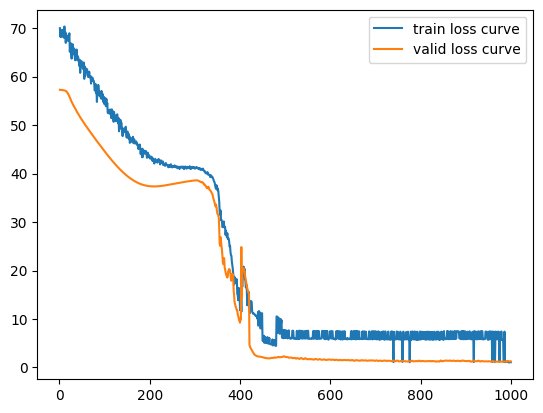

In [256]:
plt.plot(range(1, NUM_EPOCHS + 1), results['train_loss']);
plt.plot(range(1, NUM_EPOCHS + 1), results['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])

In [257]:
# Put model in evaluation mode
model.eval()

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for data, targets in test_dataloader:
        # Send data to target device
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        predictions = model(data)

        # Calculate and accumulate loss
        loss = loss_fn(targets, predictions)

In [258]:
pd.DataFrame(
    {
        'targets': targets.cpu().squeeze(),
        'predictions': predictions.cpu().squeeze()
    },
    index=range(len(targets.cpu()))
)

,targets,predictions
0,100.000000,99.899574
1,100.000000,99.885498
2,100.000000,98.711197
3,97.142860,98.823586
4,100.000000,98.720619
5,14.285714,14.507937
6,14.285714,13.760584


In [33]:
# Load dataframe
data = pd.read_csv(os.path.join(processed_data, 'OneRepMaxData_240324.csv'))

exp_data = pd.concat(
    [
        data.loc[data['PercentageMaxLoad'] <= 20.],
        data.loc[data['PercentageMaxLoad'] >= 95.]
    ]
)

In [40]:
exp_data = exp_data.filter(regex='FileId|Y$|PercentageMaxLoad|MaxFrequency')

In [97]:
mean = 1
std = 0.25

tmp = pd.DataFrame()

for _, file_data in exp_data.groupby(by='FileId'):
    seq_length = len(file_data)
    if file_data.iloc[0]['PercentageMaxLoad'] <= 20:
        for column in file_data.filter(regex='Y$').columns:
            file_data[column] = np.linspace(1, 0, seq_length) + np.random.randn(1) * std + mean

    elif file_data.iloc[0]['PercentageMaxLoad'] > 20:
        for column in file_data.filter(regex='Y$').columns:
            file_data[column] = np.linspace(0, 1, seq_length) + np.random.randn(1) * std + mean

    tmp = pd.concat([tmp, file_data])

exp_data_2 =  tmp.copy()

In [98]:
# Get dictionary of file ids assingned to different datasets
file_ids = split_data(exp_data_2, [0.8, 0.15, 0.05])

# Setup hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    data=exp_data_2,
    file_ids=file_ids,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

In [105]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup hyperparameters
INPUT_SIZE = 19
HIDDEN_SIZE = 16
NUM_LAYERS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize RNN model class instance
model = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS)

# Send model to device
model = model.to(device=DEVICE)

In [106]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = RMSELoss()

In [107]:
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  6%|▌         | 6/100 [00:00<00:03, 26.75it/s]

Epoch: 1 | train loss: 64.2033 | validation loss: 79.1637
Epoch: 2 | train loss: 64.5547 | validation loss: 79.1108
Epoch: 3 | train loss: 67.0442 | validation loss: 79.0527
Epoch: 4 | train loss: 60.7758 | validation loss: 78.9859
Epoch: 5 | train loss: 60.8513 | validation loss: 78.9090
Epoch: 6 | train loss: 68.6988 | validation loss: 78.8162


  9%|▉         | 9/100 [00:00<00:03, 26.34it/s]

Epoch: 7 | train loss: 63.2807 | validation loss: 78.6998
Epoch: 8 | train loss: 66.4276 | validation loss: 78.5550
Epoch: 9 | train loss: 66.6277 | validation loss: 78.3744
Epoch: 10 | train loss: 68.0626 | validation loss: 78.1512
Epoch: 11 | train loss: 63.3710 | validation loss: 77.8777
Epoch: 12 | train loss: 69.2644 | validation loss: 77.5416


 18%|█▊        | 18/100 [00:00<00:03, 26.74it/s]

Epoch: 13 | train loss: 62.8069 | validation loss: 77.1213
Epoch: 14 | train loss: 65.1507 | validation loss: 76.6294
Epoch: 15 | train loss: 59.0055 | validation loss: 76.0599
Epoch: 16 | train loss: 61.4139 | validation loss: 75.4121
Epoch: 17 | train loss: 63.1459 | validation loss: 74.6819
Epoch: 18 | train loss: 62.6191 | validation loss: 73.8659


 21%|██        | 21/100 [00:00<00:03, 26.22it/s]

Epoch: 19 | train loss: 64.0392 | validation loss: 72.9722
Epoch: 20 | train loss: 64.5194 | validation loss: 72.0130
Epoch: 21 | train loss: 60.2087 | validation loss: 71.0008
Epoch: 22 | train loss: 61.0075 | validation loss: 69.9506
Epoch: 23 | train loss: 55.6405 | validation loss: 68.8609
Epoch: 24 | train loss: 52.1966 | validation loss: 67.7551


 27%|██▋       | 27/100 [00:01<00:03, 21.67it/s]

Epoch: 25 | train loss: 56.5436 | validation loss: 66.6337
Epoch: 26 | train loss: 42.8382 | validation loss: 65.4870
Epoch: 27 | train loss: 54.5292 | validation loss: 64.3377
Epoch: 28 | train loss: 53.2734 | validation loss: 63.1655


 33%|███▎      | 33/100 [00:01<00:02, 24.02it/s]

Epoch: 29 | train loss: 50.4088 | validation loss: 61.9679
Epoch: 30 | train loss: 51.7683 | validation loss: 60.7719
Epoch: 31 | train loss: 46.1244 | validation loss: 59.5699
Epoch: 32 | train loss: 49.7612 | validation loss: 58.4034
Epoch: 33 | train loss: 44.3973 | validation loss: 57.2260
Epoch: 34 | train loss: 47.7077 | validation loss: 56.0750


 39%|███▉      | 39/100 [00:01<00:02, 25.78it/s]

Epoch: 35 | train loss: 46.7540 | validation loss: 54.8887
Epoch: 36 | train loss: 47.1996 | validation loss: 53.6654
Epoch: 37 | train loss: 45.1020 | validation loss: 52.3946
Epoch: 38 | train loss: 42.3567 | validation loss: 51.0710
Epoch: 39 | train loss: 45.0366 | validation loss: 49.6149
Epoch: 40 | train loss: 39.7025 | validation loss: 47.8149


 45%|████▌     | 45/100 [00:01<00:02, 25.78it/s]

Epoch: 41 | train loss: 36.4054 | validation loss: 46.2067
Epoch: 42 | train loss: 39.0800 | validation loss: 44.6875
Epoch: 43 | train loss: 35.4054 | validation loss: 42.9579
Epoch: 44 | train loss: 34.0482 | validation loss: 41.1181
Epoch: 45 | train loss: 33.9923 | validation loss: 39.3264
Epoch: 46 | train loss: 33.5210 | validation loss: 37.4213


 51%|█████     | 51/100 [00:02<00:01, 25.82it/s]

Epoch: 47 | train loss: 29.3523 | validation loss: 35.3944
Epoch: 48 | train loss: 29.1994 | validation loss: 33.3463
Epoch: 49 | train loss: 27.9870 | validation loss: 31.2525
Epoch: 50 | train loss: 25.6010 | validation loss: 29.1117
Epoch: 51 | train loss: 22.7138 | validation loss: 26.9530
Epoch: 52 | train loss: 21.9378 | validation loss: 24.7474


 57%|█████▋    | 57/100 [00:02<00:01, 26.71it/s]

Epoch: 53 | train loss: 16.5040 | validation loss: 22.5668
Epoch: 54 | train loss: 16.9701 | validation loss: 20.6241
Epoch: 55 | train loss: 16.0062 | validation loss: 18.4092
Epoch: 56 | train loss: 14.4508 | validation loss: 16.1739
Epoch: 57 | train loss: 13.3106 | validation loss: 13.9175
Epoch: 58 | train loss: 9.7923 | validation loss: 11.5905


 63%|██████▎   | 63/100 [00:02<00:01, 26.93it/s]

Epoch: 59 | train loss: 9.2748 | validation loss: 9.3271
Epoch: 60 | train loss: 7.6099 | validation loss: 6.8801
Epoch: 61 | train loss: 5.2857 | validation loss: 4.4911
Epoch: 62 | train loss: 3.2519 | validation loss: 2.3654
Epoch: 63 | train loss: 2.1698 | validation loss: 1.5543
Epoch: 64 | train loss: 2.4024 | validation loss: 1.9999
Epoch: 65 | train loss: 2.8838 | validation loss: 2.3667


 69%|██████▉   | 69/100 [00:02<00:01, 27.39it/s]

Epoch: 66 | train loss: 2.7952 | validation loss: 2.0094
Epoch: 67 | train loss: 2.1100 | validation loss: 1.7441
Epoch: 68 | train loss: 2.1824 | validation loss: 1.5074
Epoch: 69 | train loss: 1.9944 | validation loss: 1.5730
Epoch: 70 | train loss: 1.9865 | validation loss: 1.7116
Epoch: 71 | train loss: 1.9948 | validation loss: 1.6418


 75%|███████▌  | 75/100 [00:02<00:00, 27.43it/s]

Epoch: 72 | train loss: 2.1032 | validation loss: 1.6271
Epoch: 73 | train loss: 1.7662 | validation loss: 1.5211
Epoch: 74 | train loss: 1.8682 | validation loss: 1.5322
Epoch: 75 | train loss: 1.9897 | validation loss: 1.6088
Epoch: 76 | train loss: 2.0731 | validation loss: 1.7369
Epoch: 77 | train loss: 1.7208 | validation loss: 1.5413


 81%|████████  | 81/100 [00:03<00:00, 26.68it/s]

Epoch: 78 | train loss: 1.9021 | validation loss: 1.5293
Epoch: 79 | train loss: 2.0645 | validation loss: 1.6653
Epoch: 80 | train loss: 2.1330 | validation loss: 1.7571
Epoch: 81 | train loss: 2.0836 | validation loss: 1.5466
Epoch: 82 | train loss: 2.0147 | validation loss: 1.5671
Epoch: 83 | train loss: 1.9040 | validation loss: 1.6380


 87%|████████▋ | 87/100 [00:03<00:00, 26.90it/s]

Epoch: 84 | train loss: 1.8307 | validation loss: 1.6491
Epoch: 85 | train loss: 1.7090 | validation loss: 1.5423
Epoch: 86 | train loss: 1.8266 | validation loss: 1.6067
Epoch: 87 | train loss: 1.9904 | validation loss: 1.6525
Epoch: 88 | train loss: 1.9192 | validation loss: 1.6415
Epoch: 89 | train loss: 1.8820 | validation loss: 1.5584


 93%|█████████▎| 93/100 [00:03<00:00, 27.44it/s]

Epoch: 90 | train loss: 2.0264 | validation loss: 1.5345
Epoch: 91 | train loss: 1.9378 | validation loss: 1.6073
Epoch: 92 | train loss: 1.6778 | validation loss: 1.5590
Epoch: 93 | train loss: 1.5856 | validation loss: 1.5616
Epoch: 94 | train loss: 1.6780 | validation loss: 1.5857
Epoch: 95 | train loss: 2.2179 | validation loss: 1.5978


100%|██████████| 100/100 [00:03<00:00, 26.27it/s]

Epoch: 96 | train loss: 1.9758 | validation loss: 1.6070
Epoch: 97 | train loss: 2.0325 | validation loss: 1.5244
Epoch: 98 | train loss: 1.6774 | validation loss: 1.5192
Epoch: 99 | train loss: 1.7125 | validation loss: 1.5658
Epoch: 100 | train loss: 1.7382 | validation loss: 1.5789


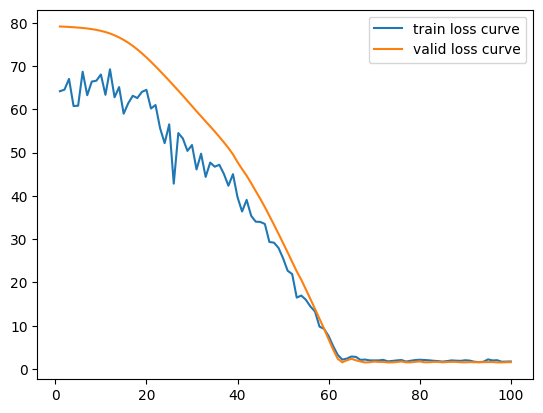

In [108]:
plt.plot(range(1, NUM_EPOCHS + 1), results['train_loss']);
plt.plot(range(1, NUM_EPOCHS + 1), results['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])

In [110]:
# Put model in evaluation mode
model.eval()

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for data, targets in test_dataloader:
        # Send data to target device
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        predictions = model(data)

        # Calculate and accumulate loss
        loss = loss_fn(targets, predictions)

pd.DataFrame(
    {
        'targets': targets.cpu().squeeze(),
        'predictions': predictions.cpu().squeeze()
    },
    index=range(len(targets.cpu()))
)

,targets,predictions
0,100.000000,98.508263
1,16.129032,17.463148
2,16.129032,17.494783
3,16.129032,15.729931
4,100.000000,98.515388
5,19.230770,16.155376
6,97.826088,98.519753


In [122]:
# Load dataframe
data = pd.read_csv(os.path.join(processed_data, 'OneRepMaxData_240324.csv'))

exp_data = pd.concat(
    [
        data.loc[data['PercentageMaxLoad'] <= 20.],
        data.loc[data['PercentageMaxLoad'] >= 95.]
    ]
)

In [123]:
exp_data = exp_data.filter(regex='FileId|X$|Y$|Z$|PercentageMaxLoad|MaxFrequency')

In [125]:
mean = 1
std = 0.25

tmp = pd.DataFrame()

for _, file_data in exp_data.groupby(by='FileId'):
    seq_length = len(file_data)
    if file_data.iloc[0]['PercentageMaxLoad'] <= 20:
        for column in file_data.filter(regex='Y$').columns:
            file_data[column] = np.linspace(1, 0, seq_length) + np.random.randn(1) * std + mean

    elif file_data.iloc[0]['PercentageMaxLoad'] > 20:
        for column in file_data.filter(regex='Y$').columns:
            file_data[column] = np.linspace(0, 1, seq_length) + np.random.randn(1) * std + mean

    tmp = pd.concat([tmp, file_data])

exp_data_2 =  tmp.copy()

In [164]:
# Get dictionary of file ids assingned to different datasets
file_ids = split_data(exp_data_2, [0.8, 0.15, 0.05])

# Setup hyperparameters
BATCH_SIZE = 16
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    data=exp_data_2,
    file_ids=file_ids,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

In [172]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup hyperparameters
INPUT_SIZE = 57
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize RNN model class instance
model = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS)

# Send model to device
model = model.to(device=DEVICE)

In [173]:
NUM_EPOCHS = 250
LEARNING_RATE = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = RMSELoss()

In [174]:
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  0%|          | 1/250 [00:00<00:35,  7.04it/s]

Epoch: 1 | train loss: 65.1844 | validation loss: 65.3531
Epoch: 2 | train loss: 65.4829 | validation loss: 65.3338
Epoch: 3 | train loss: 66.6525 | validation loss: 65.3131


  2%|▏         | 5/250 [00:00<00:23, 10.59it/s]

Epoch: 4 | train loss: 69.7226 | validation loss: 65.2920
Epoch: 5 | train loss: 68.5271 | validation loss: 65.2673
Epoch: 6 | train loss: 68.6082 | validation loss: 65.2388


  3%|▎         | 7/250 [00:00<00:22, 10.73it/s]

Epoch: 7 | train loss: 68.2186 | validation loss: 65.2015
Epoch: 8 | train loss: 65.3509 | validation loss: 65.1508
Epoch: 9 | train loss: 67.7018 | validation loss: 65.0842


  4%|▍         | 11/250 [00:01<00:21, 10.96it/s]

Epoch: 10 | train loss: 68.5924 | validation loss: 64.9990
Epoch: 11 | train loss: 67.7420 | validation loss: 64.8933
Epoch: 12 | train loss: 66.2101 | validation loss: 64.7664


  5%|▌         | 13/250 [00:01<00:21, 10.93it/s]

Epoch: 13 | train loss: 67.5861 | validation loss: 64.6228
Epoch: 14 | train loss: 68.4772 | validation loss: 64.4671
Epoch: 15 | train loss: 67.3920 | validation loss: 64.3018


  7%|▋         | 17/250 [00:01<00:21, 10.79it/s]

Epoch: 16 | train loss: 67.7159 | validation loss: 64.1308
Epoch: 17 | train loss: 65.3147 | validation loss: 63.9561


  8%|▊         | 19/250 [00:01<00:21, 10.87it/s]

Epoch: 18 | train loss: 66.5469 | validation loss: 63.7820
Epoch: 19 | train loss: 66.2095 | validation loss: 63.6080
Epoch: 20 | train loss: 66.1613 | validation loss: 63.4358


  8%|▊         | 21/250 [00:01<00:20, 11.11it/s]

Epoch: 21 | train loss: 66.3502 | validation loss: 63.2635
Epoch: 22 | train loss: 60.0886 | validation loss: 63.0906
Epoch: 23 | train loss: 62.9993 | validation loss: 62.9178


 10%|█         | 25/250 [00:02<00:20, 11.14it/s]

Epoch: 24 | train loss: 64.0476 | validation loss: 62.7490
Epoch: 25 | train loss: 65.6658 | validation loss: 62.5798
Epoch: 26 | train loss: 64.2900 | validation loss: 62.4106


 12%|█▏        | 29/250 [00:02<00:19, 11.11it/s]

Epoch: 27 | train loss: 64.6976 | validation loss: 62.2417
Epoch: 28 | train loss: 66.6034 | validation loss: 62.0725
Epoch: 29 | train loss: 63.6439 | validation loss: 61.9008


 12%|█▏        | 31/250 [00:02<00:19, 11.20it/s]

Epoch: 30 | train loss: 63.4932 | validation loss: 61.7295
Epoch: 31 | train loss: 62.9663 | validation loss: 61.5575
Epoch: 32 | train loss: 65.3684 | validation loss: 61.3861


 14%|█▍        | 35/250 [00:03<00:18, 11.44it/s]

Epoch: 33 | train loss: 63.8514 | validation loss: 61.2119
Epoch: 34 | train loss: 63.8727 | validation loss: 61.0374
Epoch: 35 | train loss: 64.3688 | validation loss: 60.8618


 15%|█▍        | 37/250 [00:03<00:18, 11.51it/s]

Epoch: 36 | train loss: 62.2200 | validation loss: 60.6841
Epoch: 37 | train loss: 62.3942 | validation loss: 60.5056
Epoch: 38 | train loss: 62.2445 | validation loss: 60.3276


 16%|█▋        | 41/250 [00:03<00:17, 11.99it/s]

Epoch: 39 | train loss: 62.6088 | validation loss: 60.1490
Epoch: 40 | train loss: 59.6184 | validation loss: 59.9675
Epoch: 41 | train loss: 61.4866 | validation loss: 59.7851


 17%|█▋        | 43/250 [00:03<00:17, 12.11it/s]

Epoch: 42 | train loss: 63.4794 | validation loss: 59.6030
Epoch: 43 | train loss: 61.2389 | validation loss: 59.4164
Epoch: 44 | train loss: 59.2770 | validation loss: 59.2300


 19%|█▉        | 47/250 [00:04<00:16, 12.23it/s]

Epoch: 45 | train loss: 58.7842 | validation loss: 59.0453
Epoch: 46 | train loss: 61.5311 | validation loss: 58.8581
Epoch: 47 | train loss: 62.2981 | validation loss: 58.6690


 20%|█▉        | 49/250 [00:04<00:16, 12.29it/s]

Epoch: 48 | train loss: 58.6283 | validation loss: 58.4758
Epoch: 49 | train loss: 59.7571 | validation loss: 58.2839
Epoch: 50 | train loss: 60.7870 | validation loss: 58.0898


 21%|██        | 53/250 [00:04<00:16, 12.12it/s]

Epoch: 51 | train loss: 58.3343 | validation loss: 57.8937
Epoch: 52 | train loss: 60.5526 | validation loss: 57.7002
Epoch: 53 | train loss: 60.2894 | validation loss: 57.5022


 22%|██▏       | 55/250 [00:04<00:16, 12.07it/s]

Epoch: 54 | train loss: 58.7578 | validation loss: 57.3022
Epoch: 55 | train loss: 60.1249 | validation loss: 57.1022
Epoch: 56 | train loss: 58.5025 | validation loss: 56.9017


 24%|██▎       | 59/250 [00:05<00:15, 12.15it/s]

Epoch: 57 | train loss: 56.9101 | validation loss: 56.6997
Epoch: 58 | train loss: 57.8067 | validation loss: 56.4993
Epoch: 59 | train loss: 60.3066 | validation loss: 56.2966


 24%|██▍       | 61/250 [00:05<00:15, 12.03it/s]

Epoch: 60 | train loss: 58.8835 | validation loss: 56.0897
Epoch: 61 | train loss: 58.4848 | validation loss: 55.8820
Epoch: 62 | train loss: 57.3323 | validation loss: 55.6748


 25%|██▌       | 63/250 [00:05<00:15, 12.01it/s]

Epoch: 63 | train loss: 58.8103 | validation loss: 55.4645
Epoch: 64 | train loss: 56.8072 | validation loss: 55.2535


 27%|██▋       | 67/250 [00:05<00:16, 10.78it/s]

Epoch: 65 | train loss: 59.3294 | validation loss: 55.0458
Epoch: 66 | train loss: 55.0973 | validation loss: 54.8322
Epoch: 67 | train loss: 57.4924 | validation loss: 54.6214


 28%|██▊       | 69/250 [00:06<00:16, 10.88it/s]

Epoch: 68 | train loss: 55.6527 | validation loss: 54.4085
Epoch: 69 | train loss: 57.6022 | validation loss: 54.1980
Epoch: 70 | train loss: 55.5660 | validation loss: 53.9852


 29%|██▉       | 73/250 [00:06<00:15, 11.47it/s]

Epoch: 71 | train loss: 53.8251 | validation loss: 53.7757
Epoch: 72 | train loss: 56.2026 | validation loss: 53.5668
Epoch: 73 | train loss: 54.6124 | validation loss: 53.3555


 30%|███       | 75/250 [00:06<00:15, 11.64it/s]

Epoch: 74 | train loss: 49.3747 | validation loss: 53.1496
Epoch: 75 | train loss: 55.4923 | validation loss: 52.9677
Epoch: 76 | train loss: 56.1583 | validation loss: 52.7706


 32%|███▏      | 79/250 [00:06<00:14, 11.72it/s]

Epoch: 77 | train loss: 54.8594 | validation loss: 52.5603
Epoch: 78 | train loss: 54.1116 | validation loss: 52.3490
Epoch: 79 | train loss: 53.5548 | validation loss: 52.1390


 32%|███▏      | 81/250 [00:07<00:14, 11.73it/s]

Epoch: 80 | train loss: 54.9275 | validation loss: 51.9292
Epoch: 81 | train loss: 54.1557 | validation loss: 51.7190
Epoch: 82 | train loss: 53.4541 | validation loss: 51.5045


 34%|███▍      | 85/250 [00:07<00:13, 11.98it/s]

Epoch: 83 | train loss: 53.9221 | validation loss: 51.2934
Epoch: 84 | train loss: 53.7114 | validation loss: 51.0805
Epoch: 85 | train loss: 53.4208 | validation loss: 50.8700


 35%|███▍      | 87/250 [00:07<00:13, 12.07it/s]

Epoch: 86 | train loss: 52.1458 | validation loss: 50.6544
Epoch: 87 | train loss: 53.1038 | validation loss: 50.4475
Epoch: 88 | train loss: 52.8475 | validation loss: 50.2362


 36%|███▋      | 91/250 [00:07<00:12, 12.24it/s]

Epoch: 89 | train loss: 52.5893 | validation loss: 50.0298
Epoch: 90 | train loss: 51.5435 | validation loss: 49.8180
Epoch: 91 | train loss: 50.9146 | validation loss: 49.6160


 37%|███▋      | 93/250 [00:08<00:12, 12.13it/s]

Epoch: 92 | train loss: 52.4494 | validation loss: 49.4141
Epoch: 93 | train loss: 52.9649 | validation loss: 49.2085
Epoch: 94 | train loss: 51.5525 | validation loss: 49.0014


 39%|███▉      | 97/250 [00:08<00:12, 12.32it/s]

Epoch: 95 | train loss: 52.0139 | validation loss: 48.7950
Epoch: 96 | train loss: 51.2773 | validation loss: 48.5868
Epoch: 97 | train loss: 50.9163 | validation loss: 48.3858


 40%|███▉      | 99/250 [00:08<00:12, 12.28it/s]

Epoch: 98 | train loss: 49.7410 | validation loss: 48.1885
Epoch: 99 | train loss: 48.3863 | validation loss: 47.9905
Epoch: 100 | train loss: 50.8644 | validation loss: 47.8053


 41%|████      | 103/250 [00:08<00:12, 12.21it/s]

Epoch: 101 | train loss: 49.1281 | validation loss: 47.6125
Epoch: 102 | train loss: 49.6157 | validation loss: 47.4259
Epoch: 103 | train loss: 50.7956 | validation loss: 47.2410


 42%|████▏     | 105/250 [00:09<00:12, 12.05it/s]

Epoch: 104 | train loss: 48.5315 | validation loss: 47.0482
Epoch: 105 | train loss: 49.3476 | validation loss: 46.8612
Epoch: 106 | train loss: 49.7788 | validation loss: 46.6768


 44%|████▎     | 109/250 [00:09<00:11, 12.03it/s]

Epoch: 107 | train loss: 49.4003 | validation loss: 46.4911
Epoch: 108 | train loss: 48.7259 | validation loss: 46.3083
Epoch: 109 | train loss: 47.2629 | validation loss: 46.1330


 44%|████▍     | 111/250 [00:09<00:11, 12.08it/s]

Epoch: 110 | train loss: 49.1875 | validation loss: 45.9649
Epoch: 111 | train loss: 47.9596 | validation loss: 45.7878
Epoch: 112 | train loss: 46.0815 | validation loss: 45.6175


 46%|████▌     | 115/250 [00:09<00:11, 12.25it/s]

Epoch: 113 | train loss: 46.9363 | validation loss: 45.4557
Epoch: 114 | train loss: 45.4924 | validation loss: 45.3013
Epoch: 115 | train loss: 47.4102 | validation loss: 45.1526


 47%|████▋     | 117/250 [00:10<00:10, 12.30it/s]

Epoch: 116 | train loss: 47.1384 | validation loss: 44.9966
Epoch: 117 | train loss: 45.0669 | validation loss: 44.8434
Epoch: 118 | train loss: 46.7909 | validation loss: 44.6984


 48%|████▊     | 121/250 [00:10<00:10, 12.14it/s]

Epoch: 119 | train loss: 46.4034 | validation loss: 44.5496
Epoch: 120 | train loss: 46.2924 | validation loss: 44.4015
Epoch: 121 | train loss: 46.8485 | validation loss: 44.2557


 49%|████▉     | 123/250 [00:10<00:10, 12.13it/s]

Epoch: 122 | train loss: 46.6552 | validation loss: 44.1121
Epoch: 123 | train loss: 45.8355 | validation loss: 43.9644
Epoch: 124 | train loss: 46.3936 | validation loss: 43.8253


 51%|█████     | 127/250 [00:10<00:10, 12.27it/s]

Epoch: 125 | train loss: 45.7192 | validation loss: 43.6868
Epoch: 126 | train loss: 43.8955 | validation loss: 43.5511
Epoch: 127 | train loss: 45.5995 | validation loss: 43.4322


 52%|█████▏    | 129/250 [00:11<00:09, 12.27it/s]

Epoch: 128 | train loss: 45.1062 | validation loss: 43.3137
Epoch: 129 | train loss: 45.1465 | validation loss: 43.1914
Epoch: 130 | train loss: 44.2359 | validation loss: 43.0743


 53%|█████▎    | 133/250 [00:11<00:09, 12.45it/s]

Epoch: 131 | train loss: 45.3309 | validation loss: 42.9657
Epoch: 132 | train loss: 44.6035 | validation loss: 42.8531
Epoch: 133 | train loss: 43.1785 | validation loss: 42.7422


 54%|█████▍    | 135/250 [00:11<00:10, 11.11it/s]

Epoch: 134 | train loss: 44.8908 | validation loss: 42.6406
Epoch: 135 | train loss: 44.2137 | validation loss: 42.5425
Epoch: 136 | train loss: 44.6752 | validation loss: 42.4445


 56%|█████▌    | 139/250 [00:11<00:09, 11.70it/s]

Epoch: 137 | train loss: 44.5141 | validation loss: 42.3414
Epoch: 138 | train loss: 43.9718 | validation loss: 42.2434
Epoch: 139 | train loss: 44.3669 | validation loss: 42.1464


 56%|█████▋    | 141/250 [00:12<00:09, 11.78it/s]

Epoch: 140 | train loss: 44.1571 | validation loss: 42.0517
Epoch: 141 | train loss: 44.3112 | validation loss: 41.9669
Epoch: 142 | train loss: 42.4859 | validation loss: 41.8742


 58%|█████▊    | 145/250 [00:12<00:08, 12.02it/s]

Epoch: 143 | train loss: 42.3117 | validation loss: 41.8009
Epoch: 144 | train loss: 43.0896 | validation loss: 41.7360
Epoch: 145 | train loss: 43.6258 | validation loss: 41.6680


 59%|█████▉    | 147/250 [00:12<00:08, 12.14it/s]

Epoch: 146 | train loss: 41.9634 | validation loss: 41.5929
Epoch: 147 | train loss: 43.1079 | validation loss: 41.5340
Epoch: 148 | train loss: 42.5378 | validation loss: 41.4698


 60%|██████    | 151/250 [00:12<00:08, 12.00it/s]

Epoch: 149 | train loss: 43.1843 | validation loss: 41.4150
Epoch: 150 | train loss: 42.4709 | validation loss: 41.3513
Epoch: 151 | train loss: 43.2102 | validation loss: 41.2979


 61%|██████    | 153/250 [00:13<00:08, 11.66it/s]

Epoch: 152 | train loss: 42.3295 | validation loss: 41.2403
Epoch: 153 | train loss: 42.7148 | validation loss: 41.1948
Epoch: 154 | train loss: 42.5365 | validation loss: 41.1400


 63%|██████▎   | 157/250 [00:13<00:07, 11.69it/s]

Epoch: 155 | train loss: 41.4943 | validation loss: 41.0923
Epoch: 156 | train loss: 41.3957 | validation loss: 41.0528
Epoch: 157 | train loss: 41.4750 | validation loss: 41.0162


 64%|██████▎   | 159/250 [00:13<00:08, 11.09it/s]

Epoch: 158 | train loss: 41.9615 | validation loss: 40.9795
Epoch: 159 | train loss: 42.1134 | validation loss: 40.9479


 64%|██████▍   | 161/250 [00:13<00:08, 10.24it/s]

Epoch: 160 | train loss: 41.8012 | validation loss: 40.9103
Epoch: 161 | train loss: 42.0609 | validation loss: 40.8728
Epoch: 162 | train loss: 41.6383 | validation loss: 40.8413


 65%|██████▌   | 163/250 [00:13<00:08, 10.74it/s]

Epoch: 163 | train loss: 41.1472 | validation loss: 40.8101
Epoch: 164 | train loss: 41.2941 | validation loss: 40.7839
Epoch: 165 | train loss: 42.6941 | validation loss: 40.7612


 67%|██████▋   | 167/250 [00:14<00:07, 11.07it/s]

Epoch: 166 | train loss: 42.1707 | validation loss: 40.7305
Epoch: 167 | train loss: 42.4869 | validation loss: 40.6995
Epoch: 168 | train loss: 41.5995 | validation loss: 40.6683


 68%|██████▊   | 169/250 [00:14<00:07, 10.81it/s]

Epoch: 169 | train loss: 42.0069 | validation loss: 40.6459
Epoch: 170 | train loss: 41.4428 | validation loss: 40.6194
Epoch: 171 | train loss: 41.6834 | validation loss: 40.5986


 69%|██████▉   | 173/250 [00:14<00:07, 10.93it/s]

Epoch: 172 | train loss: 42.0053 | validation loss: 40.5770
Epoch: 173 | train loss: 40.9648 | validation loss: 40.5541
Epoch: 174 | train loss: 41.9377 | validation loss: 40.5387


 70%|███████   | 175/250 [00:15<00:06, 10.82it/s]

Epoch: 175 | train loss: 41.8414 | validation loss: 40.5196
Epoch: 176 | train loss: 41.5832 | validation loss: 40.5007
Epoch: 177 | train loss: 41.6681 | validation loss: 40.4828


 71%|███████   | 177/250 [00:15<00:06, 10.79it/s]

Epoch: 178 | train loss: 41.1422 | validation loss: 40.4513


 72%|███████▏  | 179/250 [00:15<00:08,  7.97it/s]

Epoch: 179 | train loss: 41.1885 | validation loss: 40.2785


 72%|███████▏  | 180/250 [00:15<00:10,  6.68it/s]

Epoch: 180 | train loss: 40.9163 | validation loss: 39.8433


 73%|███████▎  | 182/250 [00:16<00:10,  6.19it/s]

Epoch: 181 | train loss: 41.1043 | validation loss: 38.8604
Epoch: 182 | train loss: 39.1186 | validation loss: 37.6533


 74%|███████▎  | 184/250 [00:16<00:10,  6.60it/s]

Epoch: 183 | train loss: 38.6867 | validation loss: 36.5759
Epoch: 184 | train loss: 40.1233 | validation loss: 36.5919


 74%|███████▍  | 186/250 [00:16<00:07,  8.09it/s]

Epoch: 185 | train loss: 38.0077 | validation loss: 37.8908
Epoch: 186 | train loss: 39.2513 | validation loss: 37.1560
Epoch: 187 | train loss: 37.7500 | validation loss: 34.6961


 76%|███████▌  | 190/250 [00:17<00:06,  9.77it/s]

Epoch: 188 | train loss: 37.7384 | validation loss: 34.1586
Epoch: 189 | train loss: 37.9702 | validation loss: 34.0087
Epoch: 190 | train loss: 36.6467 | validation loss: 33.9104


 77%|███████▋  | 192/250 [00:17<00:05, 10.39it/s]

Epoch: 191 | train loss: 35.7993 | validation loss: 31.4773
Epoch: 192 | train loss: 33.2351 | validation loss: 31.6688
Epoch: 193 | train loss: 34.8708 | validation loss: 30.4496


 78%|███████▊  | 194/250 [00:17<00:05, 10.70it/s]

Epoch: 194 | train loss: 33.9830 | validation loss: 30.1622
Epoch: 195 | train loss: 34.0125 | validation loss: 29.6263
Epoch: 196 | train loss: 33.2879 | validation loss: 29.3951


 79%|███████▉  | 198/250 [00:17<00:04, 10.96it/s]

Epoch: 197 | train loss: 33.2092 | validation loss: 28.9408
Epoch: 198 | train loss: 31.7225 | validation loss: 28.7678
Epoch: 199 | train loss: 31.5227 | validation loss: 27.6070


 81%|████████  | 202/250 [00:18<00:04, 10.87it/s]

Epoch: 200 | train loss: 31.4090 | validation loss: 26.9711
Epoch: 201 | train loss: 29.1777 | validation loss: 26.8364
Epoch: 202 | train loss: 28.5132 | validation loss: 26.1185


 82%|████████▏ | 204/250 [00:18<00:04, 10.85it/s]

Epoch: 203 | train loss: 27.8736 | validation loss: 25.5818
Epoch: 204 | train loss: 26.8930 | validation loss: 25.1179


 82%|████████▏ | 206/250 [00:18<00:04, 10.39it/s]

Epoch: 205 | train loss: 26.9386 | validation loss: 24.7326
Epoch: 206 | train loss: 25.9394 | validation loss: 24.1736
Epoch: 207 | train loss: 25.6971 | validation loss: 23.6982


 83%|████████▎ | 208/250 [00:18<00:03, 10.57it/s]

Epoch: 208 | train loss: 24.4435 | validation loss: 23.2145
Epoch: 209 | train loss: 23.4005 | validation loss: 22.6605
Epoch: 210 | train loss: 22.5140 | validation loss: 22.1871


 85%|████████▍ | 212/250 [00:19<00:03, 10.48it/s]

Epoch: 211 | train loss: 22.6932 | validation loss: 21.5907
Epoch: 212 | train loss: 21.5891 | validation loss: 21.0551
Epoch: 213 | train loss: 21.9171 | validation loss: 21.0174


 86%|████████▌ | 214/250 [00:19<00:03, 10.46it/s]

Epoch: 214 | train loss: 22.5129 | validation loss: 20.1052
Epoch: 215 | train loss: 23.9153 | validation loss: 25.7065
Epoch: 216 | train loss: 23.6881 | validation loss: 19.5586


 87%|████████▋ | 218/250 [00:19<00:03, 10.60it/s]

Epoch: 217 | train loss: 21.3340 | validation loss: 18.6197
Epoch: 218 | train loss: 20.0702 | validation loss: 18.2169
Epoch: 219 | train loss: 21.6369 | validation loss: 17.7380


 88%|████████▊ | 220/250 [00:19<00:02, 10.65it/s]

Epoch: 220 | train loss: 19.6186 | validation loss: 17.4155
Epoch: 221 | train loss: 19.8232 | validation loss: 18.7440
Epoch: 222 | train loss: 22.6078 | validation loss: 17.8810


 90%|████████▉ | 224/250 [00:20<00:02, 10.64it/s]

Epoch: 223 | train loss: 19.4578 | validation loss: 16.2815
Epoch: 224 | train loss: 18.3665 | validation loss: 15.9921
Epoch: 225 | train loss: 18.8222 | validation loss: 15.2586


 90%|█████████ | 226/250 [00:20<00:02, 10.85it/s]

Epoch: 226 | train loss: 16.2597 | validation loss: 14.5033
Epoch: 227 | train loss: 15.8865 | validation loss: 14.0119
Epoch: 228 | train loss: 14.5258 | validation loss: 13.6061


 92%|█████████▏| 230/250 [00:20<00:01, 10.93it/s]

Epoch: 229 | train loss: 13.8848 | validation loss: 15.1241
Epoch: 230 | train loss: 12.6141 | validation loss: 15.4598
Epoch: 231 | train loss: 12.3829 | validation loss: 12.8497


 94%|█████████▎| 234/250 [00:21<00:01, 10.84it/s]

Epoch: 232 | train loss: 11.9638 | validation loss: 11.4773
Epoch: 233 | train loss: 11.5310 | validation loss: 10.8635
Epoch: 234 | train loss: 10.2855 | validation loss: 10.2934


 94%|█████████▍| 236/250 [00:21<00:01, 10.97it/s]

Epoch: 235 | train loss: 9.9779 | validation loss: 9.6586
Epoch: 236 | train loss: 9.4067 | validation loss: 9.1301
Epoch: 237 | train loss: 8.7805 | validation loss: 8.5839


 95%|█████████▌| 238/250 [00:21<00:01, 10.66it/s]

Epoch: 238 | train loss: 8.2147 | validation loss: 7.9714
Epoch: 239 | train loss: 7.3897 | validation loss: 7.4078


 97%|█████████▋| 242/250 [00:22<00:00,  9.94it/s]

Epoch: 240 | train loss: 6.9935 | validation loss: 6.8946
Epoch: 241 | train loss: 6.3362 | validation loss: 6.2864
Epoch: 242 | train loss: 5.6212 | validation loss: 5.7157


 98%|█████████▊| 244/250 [00:22<00:00, 10.22it/s]

Epoch: 243 | train loss: 5.0612 | validation loss: 5.1712
Epoch: 244 | train loss: 4.4967 | validation loss: 4.6513
Epoch: 245 | train loss: 3.8890 | validation loss: 4.2064


 98%|█████████▊| 246/250 [00:22<00:00, 10.40it/s]

Epoch: 246 | train loss: 3.4870 | validation loss: 3.8025
Epoch: 247 | train loss: 2.9468 | validation loss: 3.1565
Epoch: 248 | train loss: 2.5505 | validation loss: 2.7560


100%|██████████| 250/250 [00:22<00:00, 10.99it/s]


Epoch: 249 | train loss: 2.0264 | validation loss: 2.6696
Epoch: 250 | train loss: 1.8253 | validation loss: 2.6142


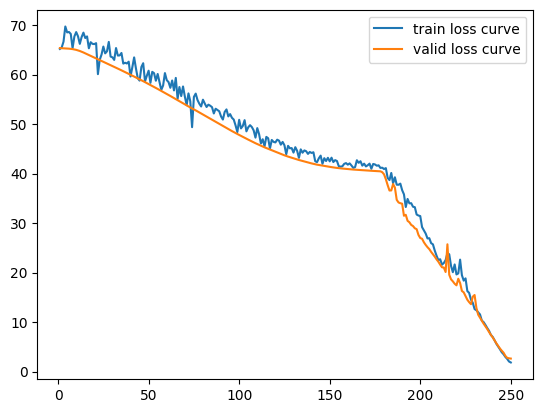

In [175]:
plt.plot(range(1, NUM_EPOCHS + 1), results['train_loss']);
plt.plot(range(1, NUM_EPOCHS + 1), results['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])

In [176]:
# Put model in evaluation mode
model.eval()

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for data, targets in test_dataloader:
        # Send data to target device
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        predictions = model(data)

        # Calculate and accumulate loss
        loss = loss_fn(targets, predictions)

pd.DataFrame(
    {
        'targets': targets.cpu().squeeze(),
        'predictions': predictions.cpu().squeeze()
    },
    index=range(len(targets.cpu()))
)

,targets,predictions
0,100.000000,97.965492
1,16.129032,20.854130
2,100.000000,95.850182
3,19.230770,18.808428
4,19.230770,21.158974
5,19.230770,27.163931
6,96.153847,97.862961


In [111]:
# Load dataframe
data = pd.read_csv(os.path.join(processed_data, 'OneRepMaxData_240324.csv'))

exp_data = pd.concat(
    [
        data.loc[data['PercentageMaxLoad'] <= 20.],
        data.loc[data['PercentageMaxLoad'] >= 95.]
    ]
)

In [112]:
exp_data = exp_data.filter(regex='FileId|Y$|PercentageMaxLoad|MaxFrequency')

In [114]:
# Get dictionary of file ids assingned to different datasets
file_ids = split_data(exp_data, [0.8, 0.15, 0.05])

# Setup hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    data=exp_data,
    file_ids=file_ids,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

In [115]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup hyperparameters
INPUT_SIZE = 19
HIDDEN_SIZE = 16
NUM_LAYERS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize RNN model class instance
model = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS)

# Send model to device
model = model.to(device=DEVICE)

In [116]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = RMSELoss()

In [117]:
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  3%|▎         | 3/100 [00:00<00:08, 11.91it/s]

Epoch: 1 | train loss: 64.3121 | validation loss: 76.1078
Epoch: 2 | train loss: 66.7714 | validation loss: 76.0482
Epoch: 3 | train loss: 66.4115 | validation loss: 75.9830
Epoch: 4 | train loss: 61.0268 | validation loss: 75.9088
Epoch: 5 | train loss: 60.7929 | validation loss: 75.8159


  9%|▉         | 9/100 [00:00<00:04, 19.07it/s]

Epoch: 6 | train loss: 67.8103 | validation loss: 75.6997
Epoch: 7 | train loss: 65.7623 | validation loss: 75.5507
Epoch: 8 | train loss: 66.2591 | validation loss: 75.3653
Epoch: 9 | train loss: 65.9872 | validation loss: 75.1419
Epoch: 10 | train loss: 65.8215 | validation loss: 74.8768


 15%|█▌        | 15/100 [00:00<00:03, 21.39it/s]

Epoch: 11 | train loss: 62.8449 | validation loss: 74.5608
Epoch: 12 | train loss: 67.4426 | validation loss: 74.1815
Epoch: 13 | train loss: 59.1885 | validation loss: 73.7213
Epoch: 14 | train loss: 66.4538 | validation loss: 73.1901
Epoch: 15 | train loss: 61.3555 | validation loss: 72.5974


 18%|█▊        | 18/100 [00:00<00:03, 22.10it/s]

Epoch: 16 | train loss: 60.9404 | validation loss: 71.9551
Epoch: 17 | train loss: 56.8005 | validation loss: 71.2724
Epoch: 18 | train loss: 59.8094 | validation loss: 70.5519
Epoch: 19 | train loss: 63.1118 | validation loss: 69.7898
Epoch: 20 | train loss: 60.9317 | validation loss: 68.9874


 24%|██▍       | 24/100 [00:01<00:03, 21.96it/s]

Epoch: 21 | train loss: 57.6572 | validation loss: 68.1567
Epoch: 22 | train loss: 60.9188 | validation loss: 67.3002
Epoch: 23 | train loss: 58.0678 | validation loss: 66.4113
Epoch: 24 | train loss: 55.3677 | validation loss: 65.4994
Epoch: 25 | train loss: 56.8771 | validation loss: 64.5727


 27%|██▋       | 27/100 [00:01<00:03, 22.46it/s]

Epoch: 26 | train loss: 55.8650 | validation loss: 63.6212
Epoch: 27 | train loss: 58.2075 | validation loss: 62.6494
Epoch: 28 | train loss: 52.0979 | validation loss: 61.6579
Epoch: 29 | train loss: 48.5611 | validation loss: 60.6717
Epoch: 30 | train loss: 54.2696 | validation loss: 59.6989


 33%|███▎      | 33/100 [00:01<00:03, 22.07it/s]

Epoch: 31 | train loss: 51.7034 | validation loss: 58.7031
Epoch: 32 | train loss: 48.8798 | validation loss: 57.7036
Epoch: 33 | train loss: 48.1193 | validation loss: 56.7208
Epoch: 34 | train loss: 49.2098 | validation loss: 55.7465
Epoch: 35 | train loss: 44.4253 | validation loss: 54.7893
Epoch: 36 | train loss: 48.8787 | validation loss: 53.8785


 39%|███▉      | 39/100 [00:01<00:02, 22.96it/s]

Epoch: 37 | train loss: 46.8079 | validation loss: 52.9519
Epoch: 38 | train loss: 44.5478 | validation loss: 52.0512
Epoch: 39 | train loss: 45.5826 | validation loss: 51.1914
Epoch: 40 | train loss: 43.4302 | validation loss: 50.3553
Epoch: 41 | train loss: 38.4437 | validation loss: 49.6242
Epoch: 42 | train loss: 42.4203 | validation loss: 49.0944


 45%|████▌     | 45/100 [00:02<00:02, 23.59it/s]

Epoch: 43 | train loss: 43.6734 | validation loss: 48.5409
Epoch: 44 | train loss: 42.0291 | validation loss: 47.9617
Epoch: 45 | train loss: 42.8291 | validation loss: 47.4102
Epoch: 46 | train loss: 43.4790 | validation loss: 46.8668
Epoch: 47 | train loss: 40.2732 | validation loss: 46.3316
Epoch: 48 | train loss: 42.8314 | validation loss: 45.9021


 51%|█████     | 51/100 [00:02<00:02, 23.50it/s]

Epoch: 49 | train loss: 40.9215 | validation loss: 45.4672
Epoch: 50 | train loss: 41.8635 | validation loss: 45.0874
Epoch: 51 | train loss: 41.5485 | validation loss: 44.7446
Epoch: 52 | train loss: 39.6380 | validation loss: 44.4415
Epoch: 53 | train loss: 40.7723 | validation loss: 44.2251


 57%|█████▋    | 57/100 [00:02<00:01, 22.65it/s]

Epoch: 54 | train loss: 39.6858 | validation loss: 44.0604
Epoch: 55 | train loss: 39.5732 | validation loss: 43.9587
Epoch: 56 | train loss: 39.7763 | validation loss: 43.9225
Epoch: 57 | train loss: 42.1926 | validation loss: 43.8691
Epoch: 58 | train loss: 41.1431 | validation loss: 43.7435


 63%|██████▎   | 63/100 [00:02<00:01, 22.97it/s]

Epoch: 59 | train loss: 40.8642 | validation loss: 43.5954
Epoch: 60 | train loss: 40.0747 | validation loss: 43.4685
Epoch: 61 | train loss: 40.9463 | validation loss: 43.3653
Epoch: 62 | train loss: 40.3988 | validation loss: 43.2593
Epoch: 63 | train loss: 40.1490 | validation loss: 43.1865
Epoch: 64 | train loss: 40.6920 | validation loss: 43.1258


 66%|██████▌   | 66/100 [00:03<00:01, 22.43it/s]

Epoch: 65 | train loss: 40.9168 | validation loss: 43.0565
Epoch: 66 | train loss: 40.0452 | validation loss: 42.9821
Epoch: 67 | train loss: 41.5712 | validation loss: 42.9296
Epoch: 68 | train loss: 40.0862 | validation loss: 42.8345
Epoch: 69 | train loss: 40.9425 | validation loss: 42.8114


 72%|███████▏  | 72/100 [00:03<00:01, 22.84it/s]

Epoch: 70 | train loss: 39.8917 | validation loss: 42.7839
Epoch: 71 | train loss: 40.0687 | validation loss: 42.8341
Epoch: 72 | train loss: 39.6088 | validation loss: 42.9214
Epoch: 73 | train loss: 40.7366 | validation loss: 43.0236
Epoch: 74 | train loss: 40.3964 | validation loss: 43.0497


 78%|███████▊  | 78/100 [00:03<00:00, 23.07it/s]

Epoch: 75 | train loss: 40.4778 | validation loss: 43.0684
Epoch: 76 | train loss: 40.4955 | validation loss: 43.0959
Epoch: 77 | train loss: 39.5830 | validation loss: 43.1296
Epoch: 78 | train loss: 40.2185 | validation loss: 43.1855
Epoch: 79 | train loss: 40.7045 | validation loss: 43.2342


 84%|████████▍ | 84/100 [00:03<00:00, 23.52it/s]

Epoch: 80 | train loss: 40.8879 | validation loss: 43.2168
Epoch: 81 | train loss: 40.2273 | validation loss: 43.1772
Epoch: 82 | train loss: 40.4661 | validation loss: 43.1605
Epoch: 83 | train loss: 40.5581 | validation loss: 43.1388
Epoch: 84 | train loss: 40.8896 | validation loss: 43.1258


 87%|████████▋ | 87/100 [00:03<00:00, 22.64it/s]

Epoch: 85 | train loss: 40.7690 | validation loss: 43.0812
Epoch: 86 | train loss: 40.4133 | validation loss: 43.0305
Epoch: 87 | train loss: 39.8143 | validation loss: 43.0089


 90%|█████████ | 90/100 [00:04<00:00, 18.41it/s]

Epoch: 88 | train loss: 40.5807 | validation loss: 43.0287
Epoch: 89 | train loss: 40.9832 | validation loss: 43.0533
Epoch: 90 | train loss: 40.1115 | validation loss: 43.0582
Epoch: 91 | train loss: 41.2831 | validation loss: 43.0816


 96%|█████████▌| 96/100 [00:04<00:00, 20.27it/s]

Epoch: 92 | train loss: 41.3155 | validation loss: 43.0252
Epoch: 93 | train loss: 40.2130 | validation loss: 42.9537
Epoch: 94 | train loss: 40.2151 | validation loss: 42.9427
Epoch: 95 | train loss: 40.6509 | validation loss: 42.9462
Epoch: 96 | train loss: 40.5801 | validation loss: 42.9545


100%|██████████| 100/100 [00:04<00:00, 21.57it/s]

Epoch: 97 | train loss: 39.9645 | validation loss: 42.9419
Epoch: 98 | train loss: 40.7606 | validation loss: 42.9664
Epoch: 99 | train loss: 40.8947 | validation loss: 42.9421
Epoch: 100 | train loss: 41.3719 | validation loss: 42.8996


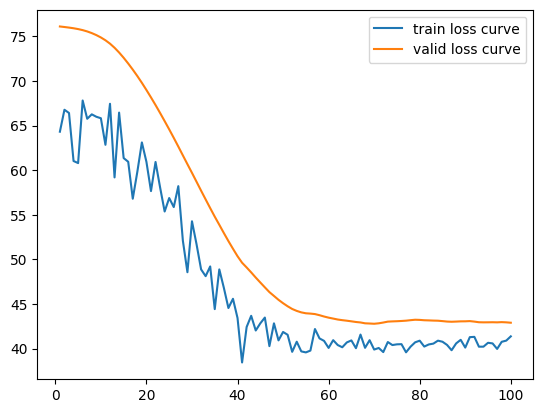

In [118]:
plt.plot(range(1, NUM_EPOCHS + 1), results['train_loss']);
plt.plot(range(1, NUM_EPOCHS + 1), results['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])

In [259]:
# Prepare paths
data_path = '../data/'
processed_data = os.path.join(data_path, 'processed')

# Load dataframe
data = pd.read_csv(os.path.join(processed_data, 'OneRepMaxData_240324.csv'))

In [263]:
exp_data = pd.concat(
    [
        data.loc[data['PercentageMaxLoad'] <= 40.],
        data.loc[data['PercentageMaxLoad'] >= 80.]
    ]
)

In [266]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from custom_dataset import CustomDataset


class Norm(object):
    """
    
    """
    def __call__(self, tensor):
        # Calculate minimal and maximal values contained in tensor
        min_value = tensor.min()
        max_value = tensor.max()

        # Normalization procedure
        normalized = 2 * (tensor - min_value) / (max_value - min_value) - 1

        return normalized
    

class AddGaussianNoise(object):
    """ 
    
    """
    def __init__(self, p=0.5, n_cols=57, mean=0., std=1.):
        self.p = p
        self.n_cols = n_cols
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        if self.p >= torch.rand(1):
            # Split the tensor for augmentation and for save
            tensor_1, tensor_2 = tensor.split(split_size=self.n_cols, dim=1)

            # Add Gaussian noise to the landmark coordinates data
            tensor_1 = tensor_1 + torch.randn_like(tensor_1) * self.std + self.mean
            # Concatenate noised and saved tensors
            tensor = torch.cat((tensor_1, tensor_2), dim=1)
        
        return tensor
    

def create_dataloaders(data, file_ids, batch_size, num_workers, pin_memory):
    """
    
    """
    # Calculate max frequency needed for a padding
    max_frequency = data.groupby(by='FileId').size().max()
    
    # Get a dataframe, dataset, and dataloader for train file ids
    train_data = data.loc[
        data['FileId'].isin(file_ids["train"])]

    train_dataset = CustomDataset(
        train_data,
        max_frequency,
        transform=transforms.Compose(
            [
                Norm(),
                AddGaussianNoise(p=0.5, mean=0., std=0.05)
            ]
        )
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    # Get a dataframe, dataset, and dataloader for validation file ids
    valid_data = data.loc[
        data['FileId'].isin(file_ids["validation"])]
    
    valid_dataset = CustomDataset(
        valid_data, max_frequency, transform=Norm())

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    # Get a dataframe, dataset, and dataloader for test file ids
    test_data = data.loc[
        data['FileId'].isin(file_ids["test"])]
    
    test_dataset = CustomDataset(
        test_data, max_frequency, transform=Norm())

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    return train_dataloader, valid_dataloader, test_dataloader

In [328]:
# Get dictionary of file ids assingned to different datasets
file_ids = split_data(exp_data, [0.75, 0.15, 0.1])

# Setup hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    data=exp_data,
    file_ids=file_ids,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

In [335]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup hyperparameters
INPUT_SIZE = 78
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize RNN model class instance
model = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS)

# Send model to device
model = model.to(device=DEVICE)

In [336]:
NUM_EPOCHS = 1000
LEARNING_RATE = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = RMSELoss()

In [337]:
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  0%|          | 1/1000 [00:00<08:17,  2.01it/s]

Epoch: 1 | train loss: 65.4139 | validation loss: 66.3731


  0%|          | 2/1000 [00:00<06:10,  2.70it/s]

Epoch: 2 | train loss: 66.3248 | validation loss: 66.3464


  0%|          | 3/1000 [00:01<05:29,  3.02it/s]

Epoch: 3 | train loss: 66.7079 | validation loss: 66.3130


  0%|          | 4/1000 [00:01<05:07,  3.24it/s]

Epoch: 4 | train loss: 65.3712 | validation loss: 66.2634


  0%|          | 5/1000 [00:01<04:52,  3.40it/s]

Epoch: 5 | train loss: 65.1026 | validation loss: 66.1789


  1%|          | 6/1000 [00:01<04:42,  3.51it/s]

Epoch: 6 | train loss: 65.6888 | validation loss: 66.0132


  1%|          | 7/1000 [00:02<04:38,  3.57it/s]

Epoch: 7 | train loss: 64.6950 | validation loss: 65.6661


  1%|          | 8/1000 [00:02<04:36,  3.59it/s]

Epoch: 8 | train loss: 62.6477 | validation loss: 65.0816


  1%|          | 9/1000 [00:02<04:33,  3.62it/s]

Epoch: 9 | train loss: 63.1709 | validation loss: 64.4196


  1%|          | 10/1000 [00:02<04:33,  3.63it/s]

Epoch: 10 | train loss: 59.1725 | validation loss: 63.8424


  1%|          | 11/1000 [00:03<04:42,  3.50it/s]

Epoch: 11 | train loss: 61.8632 | validation loss: 63.3370


  1%|          | 12/1000 [00:03<04:57,  3.32it/s]

Epoch: 12 | train loss: 62.8683 | validation loss: 62.8576


  1%|▏         | 13/1000 [00:03<04:49,  3.41it/s]

Epoch: 13 | train loss: 64.1519 | validation loss: 62.3926


  1%|▏         | 14/1000 [00:04<04:49,  3.40it/s]

Epoch: 14 | train loss: 62.1480 | validation loss: 61.9433


  2%|▏         | 15/1000 [00:04<04:47,  3.43it/s]

Epoch: 15 | train loss: 59.5546 | validation loss: 61.5068


  2%|▏         | 16/1000 [00:04<04:45,  3.45it/s]

Epoch: 16 | train loss: 58.9336 | validation loss: 61.0773


  2%|▏         | 17/1000 [00:05<05:22,  3.04it/s]

Epoch: 17 | train loss: 58.7080 | validation loss: 60.6029


  2%|▏         | 18/1000 [00:05<05:07,  3.19it/s]

Epoch: 18 | train loss: 57.6849 | validation loss: 60.1842


  2%|▏         | 19/1000 [00:05<04:54,  3.33it/s]

Epoch: 19 | train loss: 57.6347 | validation loss: 59.7720


  2%|▏         | 20/1000 [00:05<04:47,  3.41it/s]

Epoch: 20 | train loss: 58.8939 | validation loss: 59.3585


  2%|▏         | 21/1000 [00:06<04:43,  3.45it/s]

Epoch: 21 | train loss: 58.2539 | validation loss: 58.9543


  2%|▏         | 22/1000 [00:06<04:41,  3.47it/s]

Epoch: 22 | train loss: 54.4211 | validation loss: 58.5504


  2%|▏         | 23/1000 [00:06<04:48,  3.39it/s]

Epoch: 23 | train loss: 54.4475 | validation loss: 58.1478


  2%|▏         | 24/1000 [00:07<04:44,  3.44it/s]

Epoch: 24 | train loss: 52.6200 | validation loss: 57.7479


  2%|▎         | 25/1000 [00:07<04:57,  3.28it/s]

Epoch: 25 | train loss: 57.1282 | validation loss: 57.3498


  3%|▎         | 26/1000 [00:07<04:49,  3.36it/s]

Epoch: 26 | train loss: 57.9547 | validation loss: 56.9455


  3%|▎         | 27/1000 [00:08<04:44,  3.42it/s]

Epoch: 27 | train loss: 55.7832 | validation loss: 56.5365


  3%|▎         | 28/1000 [00:08<04:39,  3.48it/s]

Epoch: 28 | train loss: 52.0380 | validation loss: 56.1284


  3%|▎         | 29/1000 [00:08<04:46,  3.39it/s]

Epoch: 29 | train loss: 53.0887 | validation loss: 55.7216


  3%|▎         | 30/1000 [00:08<04:48,  3.36it/s]

Epoch: 30 | train loss: 54.9431 | validation loss: 55.3130


  3%|▎         | 31/1000 [00:09<04:50,  3.34it/s]

Epoch: 31 | train loss: 54.9349 | validation loss: 54.8999


  3%|▎         | 32/1000 [00:09<04:45,  3.39it/s]

Epoch: 32 | train loss: 54.6507 | validation loss: 54.4843


  3%|▎         | 33/1000 [00:09<04:42,  3.43it/s]

Epoch: 33 | train loss: 55.4722 | validation loss: 54.0673


  3%|▎         | 34/1000 [00:10<04:36,  3.49it/s]

Epoch: 34 | train loss: 49.6138 | validation loss: 53.6489


  4%|▎         | 35/1000 [00:10<04:30,  3.56it/s]

Epoch: 35 | train loss: 52.3369 | validation loss: 53.2355


  4%|▎         | 36/1000 [00:10<04:31,  3.55it/s]

Epoch: 36 | train loss: 50.3116 | validation loss: 52.8211


  4%|▎         | 37/1000 [00:10<04:29,  3.57it/s]

Epoch: 37 | train loss: 50.5012 | validation loss: 52.4069


  4%|▍         | 38/1000 [00:11<04:26,  3.61it/s]

Epoch: 38 | train loss: 50.4359 | validation loss: 51.9954


  4%|▍         | 39/1000 [00:11<04:24,  3.63it/s]

Epoch: 39 | train loss: 52.2810 | validation loss: 51.5832


  4%|▍         | 40/1000 [00:11<04:25,  3.61it/s]

Epoch: 40 | train loss: 52.1769 | validation loss: 51.1650


  4%|▍         | 41/1000 [00:12<04:28,  3.57it/s]

Epoch: 41 | train loss: 47.6301 | validation loss: 50.7464


  4%|▍         | 42/1000 [00:12<04:30,  3.54it/s]

Epoch: 42 | train loss: 50.5309 | validation loss: 50.3324


  4%|▍         | 43/1000 [00:12<04:27,  3.57it/s]

Epoch: 43 | train loss: 48.7116 | validation loss: 49.9157


  4%|▍         | 44/1000 [00:12<04:31,  3.52it/s]

Epoch: 44 | train loss: 48.2463 | validation loss: 49.5001


  4%|▍         | 45/1000 [00:13<04:32,  3.51it/s]

Epoch: 45 | train loss: 48.8155 | validation loss: 49.0834


  5%|▍         | 46/1000 [00:13<04:34,  3.47it/s]

Epoch: 46 | train loss: 46.3099 | validation loss: 48.6684


  5%|▍         | 47/1000 [00:13<04:42,  3.37it/s]

Epoch: 47 | train loss: 44.0980 | validation loss: 48.2547


  5%|▍         | 48/1000 [00:14<04:56,  3.21it/s]

Epoch: 48 | train loss: 47.5293 | validation loss: 47.8440


  5%|▍         | 49/1000 [00:14<04:44,  3.34it/s]

Epoch: 49 | train loss: 47.4086 | validation loss: 47.4332


  5%|▌         | 50/1000 [00:14<04:40,  3.38it/s]

Epoch: 50 | train loss: 46.2371 | validation loss: 47.0191


  5%|▌         | 51/1000 [00:14<04:44,  3.34it/s]

Epoch: 51 | train loss: 42.7400 | validation loss: 46.6170


  5%|▌         | 52/1000 [00:15<04:36,  3.42it/s]

Epoch: 52 | train loss: 46.4798 | validation loss: 46.2215


  5%|▌         | 53/1000 [00:15<04:28,  3.53it/s]

Epoch: 53 | train loss: 42.3695 | validation loss: 45.8189


  5%|▌         | 54/1000 [00:15<04:26,  3.55it/s]

Epoch: 54 | train loss: 44.7628 | validation loss: 45.4230


  6%|▌         | 55/1000 [00:16<04:23,  3.59it/s]

Epoch: 55 | train loss: 43.6367 | validation loss: 45.0277


  6%|▌         | 56/1000 [00:16<04:19,  3.63it/s]

Epoch: 56 | train loss: 40.3466 | validation loss: 44.6362


  6%|▌         | 57/1000 [00:16<04:18,  3.65it/s]

Epoch: 57 | train loss: 43.8633 | validation loss: 44.2591


  6%|▌         | 58/1000 [00:16<04:17,  3.65it/s]

Epoch: 58 | train loss: 44.0739 | validation loss: 43.8824


  6%|▌         | 59/1000 [00:17<04:15,  3.68it/s]

Epoch: 59 | train loss: 41.7798 | validation loss: 43.5018


  6%|▌         | 60/1000 [00:17<04:15,  3.68it/s]

Epoch: 60 | train loss: 41.8221 | validation loss: 43.1241


  6%|▌         | 61/1000 [00:17<04:13,  3.70it/s]

Epoch: 61 | train loss: 39.2215 | validation loss: 42.7562


  6%|▌         | 62/1000 [00:17<04:10,  3.74it/s]

Epoch: 62 | train loss: 41.5255 | validation loss: 42.4020


  6%|▋         | 63/1000 [00:18<04:10,  3.74it/s]

Epoch: 63 | train loss: 39.6564 | validation loss: 42.0486


  6%|▋         | 64/1000 [00:18<04:08,  3.77it/s]

Epoch: 64 | train loss: 40.2932 | validation loss: 41.7016


  6%|▋         | 65/1000 [00:18<04:06,  3.79it/s]

Epoch: 65 | train loss: 39.2052 | validation loss: 41.3637


  7%|▋         | 66/1000 [00:19<04:06,  3.80it/s]

Epoch: 66 | train loss: 40.2387 | validation loss: 41.0395


  7%|▋         | 67/1000 [00:19<04:10,  3.73it/s]

Epoch: 67 | train loss: 38.9709 | validation loss: 40.7193


  7%|▋         | 68/1000 [00:19<04:12,  3.70it/s]

Epoch: 68 | train loss: 38.5428 | validation loss: 40.4056


  7%|▋         | 69/1000 [00:19<04:13,  3.67it/s]

Epoch: 69 | train loss: 40.2844 | validation loss: 40.1051


  7%|▋         | 70/1000 [00:20<04:17,  3.62it/s]

Epoch: 70 | train loss: 41.1345 | validation loss: 39.8000


  7%|▋         | 71/1000 [00:20<04:15,  3.64it/s]

Epoch: 71 | train loss: 38.9138 | validation loss: 39.4927


  7%|▋         | 72/1000 [00:20<04:13,  3.65it/s]

Epoch: 72 | train loss: 38.7427 | validation loss: 39.1954


  7%|▋         | 73/1000 [00:20<04:15,  3.63it/s]

Epoch: 73 | train loss: 38.0390 | validation loss: 38.9064


  7%|▋         | 74/1000 [00:21<04:16,  3.62it/s]

Epoch: 74 | train loss: 37.6765 | validation loss: 38.6327


  8%|▊         | 75/1000 [00:21<04:12,  3.66it/s]

Epoch: 75 | train loss: 37.6043 | validation loss: 38.3655


  8%|▊         | 76/1000 [00:21<04:11,  3.67it/s]

Epoch: 76 | train loss: 36.2173 | validation loss: 38.1065


  8%|▊         | 77/1000 [00:22<04:11,  3.67it/s]

Epoch: 77 | train loss: 36.0406 | validation loss: 37.8635


  8%|▊         | 78/1000 [00:22<04:10,  3.68it/s]

Epoch: 78 | train loss: 36.4085 | validation loss: 37.6462


  8%|▊         | 79/1000 [00:22<04:09,  3.69it/s]

Epoch: 79 | train loss: 36.3434 | validation loss: 37.4337


  8%|▊         | 80/1000 [00:22<04:37,  3.32it/s]

Epoch: 80 | train loss: 36.3157 | validation loss: 37.2270


  8%|▊         | 81/1000 [00:23<04:29,  3.41it/s]

Epoch: 81 | train loss: 33.3866 | validation loss: 37.0317


  8%|▊         | 82/1000 [00:23<04:25,  3.46it/s]

Epoch: 82 | train loss: 34.4499 | validation loss: 36.8645


  8%|▊         | 83/1000 [00:23<04:20,  3.51it/s]

Epoch: 83 | train loss: 36.3865 | validation loss: 36.7106


  8%|▊         | 84/1000 [00:24<04:22,  3.49it/s]

Epoch: 84 | train loss: 34.9973 | validation loss: 36.5591


  8%|▊         | 85/1000 [00:24<04:20,  3.52it/s]

Epoch: 85 | train loss: 36.0978 | validation loss: 36.4133


  9%|▊         | 86/1000 [00:24<04:16,  3.56it/s]

Epoch: 86 | train loss: 35.4748 | validation loss: 36.2576


  9%|▊         | 87/1000 [00:24<04:14,  3.59it/s]

Epoch: 87 | train loss: 34.4896 | validation loss: 36.1059


  9%|▉         | 88/1000 [00:25<04:11,  3.62it/s]

Epoch: 88 | train loss: 35.7021 | validation loss: 35.9732


  9%|▉         | 89/1000 [00:25<04:09,  3.65it/s]

Epoch: 89 | train loss: 35.2897 | validation loss: 35.8445


  9%|▉         | 90/1000 [00:25<04:15,  3.57it/s]

Epoch: 90 | train loss: 34.9834 | validation loss: 35.7263


  9%|▉         | 91/1000 [00:26<04:14,  3.57it/s]

Epoch: 91 | train loss: 35.1607 | validation loss: 35.6150


  9%|▉         | 92/1000 [00:26<04:13,  3.59it/s]

Epoch: 92 | train loss: 35.0294 | validation loss: 35.5030


  9%|▉         | 93/1000 [00:26<04:12,  3.59it/s]

Epoch: 93 | train loss: 35.4307 | validation loss: 35.4037


  9%|▉         | 94/1000 [00:26<04:09,  3.62it/s]

Epoch: 94 | train loss: 33.8034 | validation loss: 35.3069


 10%|▉         | 95/1000 [00:27<04:31,  3.34it/s]

Epoch: 95 | train loss: 34.9701 | validation loss: 35.2197


 10%|▉         | 96/1000 [00:27<04:23,  3.43it/s]

Epoch: 96 | train loss: 33.4902 | validation loss: 35.1373


 10%|▉         | 97/1000 [00:27<04:21,  3.45it/s]

Epoch: 97 | train loss: 33.1977 | validation loss: 35.0643


 10%|▉         | 98/1000 [00:28<04:27,  3.37it/s]

Epoch: 98 | train loss: 33.7473 | validation loss: 35.0129


 10%|▉         | 99/1000 [00:28<04:20,  3.45it/s]

Epoch: 99 | train loss: 34.2357 | validation loss: 34.9540


 10%|█         | 100/1000 [00:28<04:15,  3.52it/s]

Epoch: 100 | train loss: 34.0436 | validation loss: 34.8982


 10%|█         | 101/1000 [00:28<04:15,  3.51it/s]

Epoch: 101 | train loss: 32.9464 | validation loss: 34.8461


 10%|█         | 102/1000 [00:29<04:19,  3.46it/s]

Epoch: 102 | train loss: 34.2036 | validation loss: 34.8069


 10%|█         | 103/1000 [00:29<04:16,  3.50it/s]

Epoch: 103 | train loss: 34.1437 | validation loss: 34.7639


 10%|█         | 104/1000 [00:29<04:14,  3.51it/s]

Epoch: 104 | train loss: 34.7332 | validation loss: 34.7261


 10%|█         | 105/1000 [00:30<04:17,  3.48it/s]

Epoch: 105 | train loss: 34.9319 | validation loss: 34.6814


 11%|█         | 106/1000 [00:30<04:21,  3.42it/s]

Epoch: 106 | train loss: 34.3527 | validation loss: 34.6368


 11%|█         | 107/1000 [00:30<04:22,  3.40it/s]

Epoch: 107 | train loss: 34.8762 | validation loss: 34.5996


 11%|█         | 108/1000 [00:30<04:16,  3.47it/s]

Epoch: 108 | train loss: 33.0949 | validation loss: 34.5672


 11%|█         | 109/1000 [00:31<04:12,  3.53it/s]

Epoch: 109 | train loss: 34.2171 | validation loss: 34.5472


 11%|█         | 110/1000 [00:31<04:09,  3.57it/s]

Epoch: 110 | train loss: 34.2453 | validation loss: 34.5244


 11%|█         | 111/1000 [00:31<04:05,  3.62it/s]

Epoch: 111 | train loss: 33.8101 | validation loss: 34.5002


 11%|█         | 112/1000 [00:32<04:06,  3.60it/s]

Epoch: 112 | train loss: 33.0055 | validation loss: 34.4846


 11%|█▏        | 113/1000 [00:32<04:04,  3.62it/s]

Epoch: 113 | train loss: 34.2825 | validation loss: 34.4678


 11%|█▏        | 114/1000 [00:32<04:03,  3.64it/s]

Epoch: 114 | train loss: 34.3517 | validation loss: 34.4440


 12%|█▏        | 115/1000 [00:32<04:03,  3.64it/s]

Epoch: 115 | train loss: 33.4812 | validation loss: 34.4204


 12%|█▏        | 116/1000 [00:33<04:04,  3.62it/s]

Epoch: 116 | train loss: 33.8387 | validation loss: 34.4053


 12%|█▏        | 117/1000 [00:33<04:04,  3.61it/s]

Epoch: 117 | train loss: 33.1179 | validation loss: 34.3921


 12%|█▏        | 118/1000 [00:33<04:05,  3.60it/s]

Epoch: 118 | train loss: 33.2609 | validation loss: 34.3819


 12%|█▏        | 119/1000 [00:33<04:04,  3.61it/s]

Epoch: 119 | train loss: 33.8919 | validation loss: 34.3737


 12%|█▏        | 120/1000 [00:34<04:06,  3.57it/s]

Epoch: 120 | train loss: 33.4188 | validation loss: 34.3664


 12%|█▏        | 121/1000 [00:34<04:08,  3.53it/s]

Epoch: 121 | train loss: 33.8125 | validation loss: 34.3556


 12%|█▏        | 122/1000 [00:34<04:16,  3.42it/s]

Epoch: 122 | train loss: 33.7599 | validation loss: 34.3448


 12%|█▏        | 123/1000 [00:35<04:14,  3.45it/s]

Epoch: 123 | train loss: 33.5529 | validation loss: 34.3402


 12%|█▏        | 124/1000 [00:35<04:13,  3.45it/s]

Epoch: 124 | train loss: 33.6201 | validation loss: 34.3340


 12%|█▎        | 125/1000 [00:35<04:11,  3.47it/s]

Epoch: 125 | train loss: 33.3863 | validation loss: 34.3283


 13%|█▎        | 126/1000 [00:35<04:08,  3.51it/s]

Epoch: 126 | train loss: 33.2660 | validation loss: 34.3225


 13%|█▎        | 127/1000 [00:36<04:07,  3.53it/s]

Epoch: 127 | train loss: 33.5002 | validation loss: 34.3198


 13%|█▎        | 128/1000 [00:36<04:05,  3.54it/s]

Epoch: 128 | train loss: 33.1466 | validation loss: 34.3210


 13%|█▎        | 129/1000 [00:36<04:04,  3.56it/s]

Epoch: 129 | train loss: 33.6978 | validation loss: 34.3152


 13%|█▎        | 130/1000 [00:37<04:03,  3.57it/s]

Epoch: 130 | train loss: 33.2764 | validation loss: 34.3100


 13%|█▎        | 131/1000 [00:37<04:01,  3.59it/s]

Epoch: 131 | train loss: 32.7258 | validation loss: 34.3089


 13%|█▎        | 132/1000 [00:37<04:00,  3.60it/s]

Epoch: 132 | train loss: 32.8647 | validation loss: 34.3087


 13%|█▎        | 133/1000 [00:37<04:11,  3.45it/s]

Epoch: 133 | train loss: 33.9411 | validation loss: 34.3084


 13%|█▎        | 134/1000 [00:38<04:05,  3.52it/s]

Epoch: 134 | train loss: 33.4075 | validation loss: 34.3010


 14%|█▎        | 135/1000 [00:38<04:06,  3.51it/s]

Epoch: 135 | train loss: 33.2379 | validation loss: 34.2935


 14%|█▎        | 136/1000 [00:38<04:25,  3.26it/s]

Epoch: 136 | train loss: 32.7427 | validation loss: 34.2926


 14%|█▎        | 137/1000 [00:39<04:15,  3.38it/s]

Epoch: 137 | train loss: 33.8548 | validation loss: 34.2906


 14%|█▍        | 138/1000 [00:39<04:12,  3.42it/s]

Epoch: 138 | train loss: 32.1934 | validation loss: 34.2887


 14%|█▍        | 139/1000 [00:39<04:06,  3.50it/s]

Epoch: 139 | train loss: 32.6013 | validation loss: 34.2874


 14%|█▍        | 140/1000 [00:39<04:02,  3.55it/s]

Epoch: 140 | train loss: 33.7299 | validation loss: 34.2896


 14%|█▍        | 141/1000 [00:40<03:58,  3.60it/s]

Epoch: 141 | train loss: 33.8223 | validation loss: 34.2870


 14%|█▍        | 142/1000 [00:40<03:57,  3.61it/s]

Epoch: 142 | train loss: 32.5527 | validation loss: 34.2813


 14%|█▍        | 143/1000 [00:40<03:54,  3.65it/s]

Epoch: 143 | train loss: 33.4895 | validation loss: 34.2825


 14%|█▍        | 144/1000 [00:41<03:56,  3.61it/s]

Epoch: 144 | train loss: 32.9810 | validation loss: 34.2781


 14%|█▍        | 145/1000 [00:41<03:56,  3.62it/s]

Epoch: 145 | train loss: 33.1739 | validation loss: 34.2751


 15%|█▍        | 146/1000 [00:41<03:53,  3.65it/s]

Epoch: 146 | train loss: 33.6725 | validation loss: 34.2742


 15%|█▍        | 147/1000 [00:41<03:54,  3.64it/s]

Epoch: 147 | train loss: 32.4593 | validation loss: 34.2725


 15%|█▍        | 148/1000 [00:42<03:55,  3.61it/s]

Epoch: 148 | train loss: 33.7388 | validation loss: 34.2775


 15%|█▍        | 149/1000 [00:42<03:55,  3.61it/s]

Epoch: 149 | train loss: 33.3944 | validation loss: 34.2780


 15%|█▌        | 150/1000 [00:42<04:00,  3.54it/s]

Epoch: 150 | train loss: 33.5440 | validation loss: 34.2756


 15%|█▌        | 151/1000 [00:43<04:02,  3.50it/s]

Epoch: 151 | train loss: 33.9134 | validation loss: 34.2687


 15%|█▌        | 152/1000 [00:43<04:01,  3.51it/s]

Epoch: 152 | train loss: 32.6542 | validation loss: 34.2496


 15%|█▌        | 153/1000 [00:43<03:59,  3.54it/s]

Epoch: 153 | train loss: 33.0177 | validation loss: 34.2442


 15%|█▌        | 154/1000 [00:43<03:57,  3.57it/s]

Epoch: 154 | train loss: 34.0934 | validation loss: 34.1628


 16%|█▌        | 155/1000 [00:44<03:54,  3.60it/s]

Epoch: 155 | train loss: 33.5997 | validation loss: 34.0641


 16%|█▌        | 156/1000 [00:44<03:53,  3.62it/s]

Epoch: 156 | train loss: 33.4136 | validation loss: 33.9818


 16%|█▌        | 157/1000 [00:44<03:53,  3.61it/s]

Epoch: 157 | train loss: 32.2625 | validation loss: 34.1340


 16%|█▌        | 158/1000 [00:44<03:52,  3.63it/s]

Epoch: 158 | train loss: 32.6331 | validation loss: 33.9898


 16%|█▌        | 159/1000 [00:45<03:52,  3.61it/s]

Epoch: 159 | train loss: 32.9078 | validation loss: 34.0791


 16%|█▌        | 160/1000 [00:45<03:58,  3.52it/s]

Epoch: 160 | train loss: 34.0845 | validation loss: 33.8506


 16%|█▌        | 161/1000 [00:45<03:58,  3.51it/s]

Epoch: 161 | train loss: 32.8544 | validation loss: 33.9134


 16%|█▌        | 162/1000 [00:46<04:07,  3.38it/s]

Epoch: 162 | train loss: 34.1874 | validation loss: 33.8146


 16%|█▋        | 163/1000 [00:46<04:23,  3.18it/s]

Epoch: 163 | train loss: 33.3357 | validation loss: 33.8447


 16%|█▋        | 164/1000 [00:46<04:18,  3.23it/s]

Epoch: 164 | train loss: 33.3848 | validation loss: 33.9410


 16%|█▋        | 165/1000 [00:47<04:14,  3.28it/s]

Epoch: 165 | train loss: 32.7260 | validation loss: 33.6587


 17%|█▋        | 166/1000 [00:47<04:08,  3.35it/s]

Epoch: 166 | train loss: 33.9346 | validation loss: 33.2074


 17%|█▋        | 167/1000 [00:47<04:03,  3.42it/s]

Epoch: 167 | train loss: 32.2092 | validation loss: 33.1832


 17%|█▋        | 168/1000 [00:47<03:58,  3.49it/s]

Epoch: 168 | train loss: 32.6567 | validation loss: 32.8839


 17%|█▋        | 169/1000 [00:48<03:57,  3.49it/s]

Epoch: 169 | train loss: 31.8376 | validation loss: 32.6908


 17%|█▋        | 170/1000 [00:48<03:56,  3.50it/s]

Epoch: 170 | train loss: 31.9871 | validation loss: 32.4269


 17%|█▋        | 171/1000 [00:48<03:55,  3.51it/s]

Epoch: 171 | train loss: 31.5192 | validation loss: 31.6929


 17%|█▋        | 172/1000 [00:49<03:53,  3.54it/s]

Epoch: 172 | train loss: 30.9879 | validation loss: 31.1906


 17%|█▋        | 173/1000 [00:49<03:50,  3.59it/s]

Epoch: 173 | train loss: 29.5556 | validation loss: 29.6247


 17%|█▋        | 174/1000 [00:49<03:48,  3.61it/s]

Epoch: 174 | train loss: 28.9979 | validation loss: 29.9221


 18%|█▊        | 175/1000 [00:49<03:51,  3.57it/s]

Epoch: 175 | train loss: 29.0969 | validation loss: 29.9311


 18%|█▊        | 176/1000 [00:50<04:02,  3.39it/s]

Epoch: 176 | train loss: 28.5625 | validation loss: 26.7448


 18%|█▊        | 177/1000 [00:50<04:03,  3.38it/s]

Epoch: 177 | train loss: 26.3830 | validation loss: 26.2953


 18%|█▊        | 178/1000 [00:50<03:55,  3.48it/s]

Epoch: 178 | train loss: 27.2152 | validation loss: 28.5092


 18%|█▊        | 179/1000 [00:51<03:50,  3.56it/s]

Epoch: 179 | train loss: 23.2226 | validation loss: 31.6475


 18%|█▊        | 180/1000 [00:51<03:46,  3.62it/s]

Epoch: 180 | train loss: 29.3586 | validation loss: 31.6005


 18%|█▊        | 181/1000 [00:51<03:44,  3.66it/s]

Epoch: 181 | train loss: 29.8985 | validation loss: 29.0711


 18%|█▊        | 182/1000 [00:51<03:40,  3.70it/s]

Epoch: 182 | train loss: 28.6353 | validation loss: 28.1870


 18%|█▊        | 183/1000 [00:52<03:39,  3.72it/s]

Epoch: 183 | train loss: 28.5901 | validation loss: 26.1431


 18%|█▊        | 184/1000 [00:52<03:38,  3.73it/s]

Epoch: 184 | train loss: 26.3155 | validation loss: 26.2623


 18%|█▊        | 185/1000 [00:52<03:38,  3.73it/s]

Epoch: 185 | train loss: 26.3170 | validation loss: 26.9448


 19%|█▊        | 186/1000 [00:52<03:37,  3.75it/s]

Epoch: 186 | train loss: 24.9651 | validation loss: 25.9142


 19%|█▊        | 187/1000 [00:53<03:48,  3.56it/s]

Epoch: 187 | train loss: 24.4704 | validation loss: 25.4186


 19%|█▉        | 188/1000 [00:53<03:50,  3.52it/s]

Epoch: 188 | train loss: 25.1412 | validation loss: 24.2428


 19%|█▉        | 189/1000 [00:53<03:45,  3.59it/s]

Epoch: 189 | train loss: 26.2594 | validation loss: 25.3235


 19%|█▉        | 190/1000 [00:54<03:43,  3.62it/s]

Epoch: 190 | train loss: 24.0074 | validation loss: 26.2854


 19%|█▉        | 191/1000 [00:54<03:40,  3.67it/s]

Epoch: 191 | train loss: 25.5117 | validation loss: 25.3308


 19%|█▉        | 192/1000 [00:54<03:39,  3.69it/s]

Epoch: 192 | train loss: 23.4409 | validation loss: 23.0617


 19%|█▉        | 193/1000 [00:54<03:36,  3.72it/s]

Epoch: 193 | train loss: 25.0028 | validation loss: 23.4187


 19%|█▉        | 194/1000 [00:55<03:36,  3.72it/s]

Epoch: 194 | train loss: 23.9115 | validation loss: 23.0299


 20%|█▉        | 195/1000 [00:55<03:37,  3.69it/s]

Epoch: 195 | train loss: 22.8784 | validation loss: 22.0572


 20%|█▉        | 196/1000 [00:55<03:46,  3.55it/s]

Epoch: 196 | train loss: 21.7403 | validation loss: 21.4665


 20%|█▉        | 197/1000 [00:55<03:44,  3.58it/s]

Epoch: 197 | train loss: 22.3045 | validation loss: 29.6450


 20%|█▉        | 198/1000 [00:56<03:43,  3.59it/s]

Epoch: 198 | train loss: 27.7209 | validation loss: 24.6004


 20%|█▉        | 199/1000 [00:56<03:42,  3.60it/s]

Epoch: 199 | train loss: 23.5441 | validation loss: 23.1632


 20%|██        | 200/1000 [00:56<03:39,  3.64it/s]

Epoch: 200 | train loss: 25.9907 | validation loss: 23.9144


 20%|██        | 201/1000 [00:57<03:38,  3.65it/s]

Epoch: 201 | train loss: 21.9669 | validation loss: 23.5000


 20%|██        | 202/1000 [00:57<03:38,  3.65it/s]

Epoch: 202 | train loss: 22.0255 | validation loss: 22.6565


 20%|██        | 203/1000 [00:57<03:38,  3.64it/s]

Epoch: 203 | train loss: 21.3787 | validation loss: 21.9655


 20%|██        | 204/1000 [00:57<03:37,  3.66it/s]

Epoch: 204 | train loss: 20.1007 | validation loss: 21.0859


 20%|██        | 205/1000 [00:58<03:35,  3.69it/s]

Epoch: 205 | train loss: 20.2216 | validation loss: 20.6305


 21%|██        | 206/1000 [00:58<03:34,  3.71it/s]

Epoch: 206 | train loss: 20.5867 | validation loss: 20.8821


 21%|██        | 207/1000 [00:58<03:34,  3.69it/s]

Epoch: 207 | train loss: 18.5759 | validation loss: 19.5083


 21%|██        | 208/1000 [00:58<03:34,  3.70it/s]

Epoch: 208 | train loss: 21.5999 | validation loss: 18.9125


 21%|██        | 209/1000 [00:59<03:35,  3.67it/s]

Epoch: 209 | train loss: 21.4279 | validation loss: 19.8427


 21%|██        | 210/1000 [00:59<03:40,  3.58it/s]

Epoch: 210 | train loss: 19.6431 | validation loss: 19.0692


 21%|██        | 211/1000 [00:59<03:40,  3.58it/s]

Epoch: 211 | train loss: 19.2255 | validation loss: 18.6817


 21%|██        | 212/1000 [01:00<03:51,  3.40it/s]

Epoch: 212 | train loss: 20.3411 | validation loss: 18.6443


 21%|██▏       | 213/1000 [01:00<03:55,  3.34it/s]

Epoch: 213 | train loss: 18.4349 | validation loss: 22.5982


 21%|██▏       | 214/1000 [01:00<03:50,  3.41it/s]

Epoch: 214 | train loss: 20.3430 | validation loss: 22.2019


 22%|██▏       | 215/1000 [01:00<03:44,  3.50it/s]

Epoch: 215 | train loss: 17.2641 | validation loss: 16.2211


 22%|██▏       | 216/1000 [01:01<03:40,  3.55it/s]

Epoch: 216 | train loss: 19.2363 | validation loss: 21.4964


 22%|██▏       | 217/1000 [01:01<03:41,  3.54it/s]

Epoch: 217 | train loss: 19.5564 | validation loss: 18.6835


 22%|██▏       | 218/1000 [01:01<03:40,  3.55it/s]

Epoch: 218 | train loss: 20.0048 | validation loss: 15.0356


 22%|██▏       | 219/1000 [01:02<03:40,  3.54it/s]

Epoch: 219 | train loss: 14.5511 | validation loss: 13.4377


 22%|██▏       | 220/1000 [01:02<03:40,  3.54it/s]

Epoch: 220 | train loss: 12.7881 | validation loss: 14.3928


 22%|██▏       | 221/1000 [01:02<03:40,  3.53it/s]

Epoch: 221 | train loss: 13.8964 | validation loss: 30.3054


 22%|██▏       | 222/1000 [01:02<03:40,  3.53it/s]

Epoch: 222 | train loss: 29.6666 | validation loss: 30.1837


 22%|██▏       | 223/1000 [01:03<03:36,  3.58it/s]

Epoch: 223 | train loss: 27.0446 | validation loss: 32.1471


 22%|██▏       | 224/1000 [01:03<03:33,  3.63it/s]

Epoch: 224 | train loss: 32.1688 | validation loss: 32.8188


 22%|██▎       | 225/1000 [01:03<03:33,  3.62it/s]

Epoch: 225 | train loss: 32.7042 | validation loss: 28.9522


 23%|██▎       | 226/1000 [01:04<03:31,  3.65it/s]

Epoch: 226 | train loss: 27.6280 | validation loss: 23.2078


 23%|██▎       | 227/1000 [01:04<03:31,  3.65it/s]

Epoch: 227 | train loss: 21.8074 | validation loss: 24.2333


 23%|██▎       | 228/1000 [01:04<03:30,  3.67it/s]

Epoch: 228 | train loss: 24.7415 | validation loss: 24.8457


 23%|██▎       | 229/1000 [01:04<03:31,  3.64it/s]

Epoch: 229 | train loss: 22.7465 | validation loss: 21.8316


 23%|██▎       | 230/1000 [01:05<03:33,  3.61it/s]

Epoch: 230 | train loss: 19.4648 | validation loss: 21.3119


 23%|██▎       | 231/1000 [01:05<03:33,  3.60it/s]

Epoch: 231 | train loss: 17.2610 | validation loss: 21.2322


 23%|██▎       | 232/1000 [01:05<03:55,  3.26it/s]

Epoch: 232 | train loss: 18.3278 | validation loss: 17.5247


 23%|██▎       | 233/1000 [01:06<03:46,  3.38it/s]

Epoch: 233 | train loss: 14.0493 | validation loss: 18.8430


 23%|██▎       | 234/1000 [01:06<03:43,  3.43it/s]

Epoch: 234 | train loss: 17.9140 | validation loss: 18.9589


 24%|██▎       | 235/1000 [01:06<03:49,  3.33it/s]

Epoch: 235 | train loss: 13.6382 | validation loss: 18.7981


 24%|██▎       | 236/1000 [01:06<03:42,  3.44it/s]

Epoch: 236 | train loss: 12.5242 | validation loss: 18.6949


 24%|██▎       | 237/1000 [01:07<03:40,  3.47it/s]

Epoch: 237 | train loss: 12.8649 | validation loss: 16.6000


 24%|██▍       | 238/1000 [01:07<03:35,  3.54it/s]

Epoch: 238 | train loss: 12.1947 | validation loss: 15.1487


 24%|██▍       | 239/1000 [01:07<03:34,  3.55it/s]

Epoch: 239 | train loss: 14.1523 | validation loss: 15.1815


 24%|██▍       | 240/1000 [01:08<03:31,  3.59it/s]

Epoch: 240 | train loss: 11.7169 | validation loss: 15.1079


 24%|██▍       | 241/1000 [01:08<03:28,  3.65it/s]

Epoch: 241 | train loss: 12.1043 | validation loss: 16.5467


 24%|██▍       | 242/1000 [01:08<03:27,  3.66it/s]

Epoch: 242 | train loss: 12.2039 | validation loss: 16.5210


 24%|██▍       | 243/1000 [01:08<03:28,  3.63it/s]

Epoch: 243 | train loss: 15.5772 | validation loss: 18.7229


 24%|██▍       | 244/1000 [01:09<03:26,  3.66it/s]

Epoch: 244 | train loss: 14.5437 | validation loss: 16.5494


 24%|██▍       | 245/1000 [01:09<03:25,  3.67it/s]

Epoch: 245 | train loss: 12.6581 | validation loss: 16.5650


 25%|██▍       | 246/1000 [01:09<03:26,  3.65it/s]

Epoch: 246 | train loss: 13.8374 | validation loss: 16.5649


 25%|██▍       | 247/1000 [01:09<03:27,  3.62it/s]

Epoch: 247 | train loss: 11.5065 | validation loss: 16.5584


 25%|██▍       | 248/1000 [01:10<03:27,  3.63it/s]

Epoch: 248 | train loss: 14.8010 | validation loss: 15.0867


 25%|██▍       | 249/1000 [01:10<03:26,  3.64it/s]

Epoch: 249 | train loss: 11.8713 | validation loss: 15.0496


 25%|██▌       | 250/1000 [01:10<03:25,  3.65it/s]

Epoch: 250 | train loss: 11.6051 | validation loss: 15.0145


 25%|██▌       | 251/1000 [01:11<03:24,  3.66it/s]

Epoch: 251 | train loss: 11.7978 | validation loss: 15.0190


 25%|██▌       | 252/1000 [01:11<03:24,  3.66it/s]

Epoch: 252 | train loss: 14.3652 | validation loss: 15.0211


 25%|██▌       | 253/1000 [01:11<03:24,  3.66it/s]

Epoch: 253 | train loss: 14.6072 | validation loss: 15.0073


 25%|██▌       | 254/1000 [01:11<03:23,  3.66it/s]

Epoch: 254 | train loss: 13.4386 | validation loss: 15.0018


 26%|██▌       | 255/1000 [01:12<03:24,  3.64it/s]

Epoch: 255 | train loss: 13.8260 | validation loss: 16.5575


 26%|██▌       | 256/1000 [01:12<03:24,  3.64it/s]

Epoch: 256 | train loss: 13.8715 | validation loss: 16.5275


 26%|██▌       | 257/1000 [01:12<03:23,  3.65it/s]

Epoch: 257 | train loss: 13.9468 | validation loss: 16.5084


 26%|██▌       | 258/1000 [01:12<03:26,  3.60it/s]

Epoch: 258 | train loss: 12.4607 | validation loss: 16.5029


 26%|██▌       | 259/1000 [01:13<03:23,  3.64it/s]

Epoch: 259 | train loss: 12.2811 | validation loss: 16.5152


 26%|██▌       | 260/1000 [01:13<03:22,  3.66it/s]

Epoch: 260 | train loss: 12.1506 | validation loss: 16.4748


 26%|██▌       | 261/1000 [01:13<03:22,  3.65it/s]

Epoch: 261 | train loss: 12.2091 | validation loss: 18.6919


 26%|██▌       | 262/1000 [01:14<03:21,  3.66it/s]

Epoch: 262 | train loss: 16.4757 | validation loss: 18.6762


 26%|██▋       | 263/1000 [01:14<03:21,  3.66it/s]

Epoch: 263 | train loss: 11.9898 | validation loss: 18.6514


 26%|██▋       | 264/1000 [01:14<03:20,  3.68it/s]

Epoch: 264 | train loss: 11.8981 | validation loss: 18.6422


 26%|██▋       | 265/1000 [01:14<03:20,  3.66it/s]

Epoch: 265 | train loss: 14.2411 | validation loss: 18.6531


 27%|██▋       | 266/1000 [01:15<03:20,  3.66it/s]

Epoch: 266 | train loss: 13.9123 | validation loss: 18.6881


 27%|██▋       | 267/1000 [01:15<03:34,  3.41it/s]

Epoch: 267 | train loss: 11.8127 | validation loss: 18.7375


 27%|██▋       | 268/1000 [01:15<03:35,  3.40it/s]

Epoch: 268 | train loss: 11.9395 | validation loss: 16.6738


 27%|██▋       | 269/1000 [01:16<03:32,  3.45it/s]

Epoch: 269 | train loss: 14.0843 | validation loss: 18.8321


 27%|██▋       | 270/1000 [01:16<03:30,  3.47it/s]

Epoch: 270 | train loss: 12.2580 | validation loss: 18.6955


 27%|██▋       | 271/1000 [01:16<03:30,  3.47it/s]

Epoch: 271 | train loss: 12.1032 | validation loss: 18.6645


 27%|██▋       | 272/1000 [01:16<03:29,  3.48it/s]

Epoch: 272 | train loss: 12.7698 | validation loss: 18.6884


 27%|██▋       | 273/1000 [01:17<03:25,  3.53it/s]

Epoch: 273 | train loss: 12.3844 | validation loss: 18.7607


 27%|██▋       | 274/1000 [01:17<03:24,  3.55it/s]

Epoch: 274 | train loss: 11.7780 | validation loss: 18.7986


 28%|██▊       | 275/1000 [01:17<03:24,  3.55it/s]

Epoch: 275 | train loss: 15.4222 | validation loss: 18.7229


 28%|██▊       | 276/1000 [01:18<03:22,  3.58it/s]

Epoch: 276 | train loss: 13.0845 | validation loss: 18.6611


 28%|██▊       | 277/1000 [01:18<03:22,  3.56it/s]

Epoch: 277 | train loss: 15.7307 | validation loss: 18.6895


 28%|██▊       | 278/1000 [01:18<03:20,  3.59it/s]

Epoch: 278 | train loss: 15.8498 | validation loss: 18.6798


 28%|██▊       | 279/1000 [01:18<03:19,  3.62it/s]

Epoch: 279 | train loss: 14.3376 | validation loss: 18.6331


 28%|██▊       | 280/1000 [01:19<03:18,  3.64it/s]

Epoch: 280 | train loss: 12.7250 | validation loss: 18.5595


 28%|██▊       | 281/1000 [01:19<03:17,  3.64it/s]

Epoch: 281 | train loss: 12.7455 | validation loss: 18.5220


 28%|██▊       | 282/1000 [01:19<03:18,  3.61it/s]

Epoch: 282 | train loss: 13.2419 | validation loss: 18.5264


 28%|██▊       | 283/1000 [01:20<03:29,  3.43it/s]

Epoch: 283 | train loss: 14.1141 | validation loss: 18.5463


 28%|██▊       | 284/1000 [01:20<03:27,  3.44it/s]

Epoch: 284 | train loss: 16.0638 | validation loss: 18.5050


 28%|██▊       | 285/1000 [01:20<03:35,  3.32it/s]

Epoch: 285 | train loss: 15.3429 | validation loss: 18.5051


 29%|██▊       | 286/1000 [01:20<03:30,  3.39it/s]

Epoch: 286 | train loss: 13.0432 | validation loss: 18.6631


 29%|██▊       | 287/1000 [01:21<03:30,  3.38it/s]

Epoch: 287 | train loss: 11.9607 | validation loss: 18.6385


 29%|██▉       | 288/1000 [01:21<03:29,  3.39it/s]

Epoch: 288 | train loss: 12.5196 | validation loss: 18.5396


 29%|██▉       | 289/1000 [01:21<03:36,  3.29it/s]

Epoch: 289 | train loss: 12.2649 | validation loss: 18.5394


 29%|██▉       | 290/1000 [01:22<03:37,  3.27it/s]

Epoch: 290 | train loss: 13.4165 | validation loss: 18.5058


 29%|██▉       | 291/1000 [01:22<03:32,  3.34it/s]

Epoch: 291 | train loss: 14.0166 | validation loss: 18.5357


 29%|██▉       | 292/1000 [01:22<03:27,  3.41it/s]

Epoch: 292 | train loss: 12.9271 | validation loss: 18.6176


 29%|██▉       | 293/1000 [01:23<03:26,  3.42it/s]

Epoch: 293 | train loss: 16.3116 | validation loss: 18.6415


 29%|██▉       | 294/1000 [01:23<03:24,  3.45it/s]

Epoch: 294 | train loss: 12.8812 | validation loss: 18.5151


 30%|██▉       | 295/1000 [01:23<03:27,  3.39it/s]

Epoch: 295 | train loss: 13.1492 | validation loss: 18.4960


 30%|██▉       | 296/1000 [01:23<03:28,  3.38it/s]

Epoch: 296 | train loss: 12.8167 | validation loss: 18.5784


 30%|██▉       | 297/1000 [01:24<03:22,  3.48it/s]

Epoch: 297 | train loss: 13.5178 | validation loss: 18.6430


 30%|██▉       | 298/1000 [01:24<03:18,  3.54it/s]

Epoch: 298 | train loss: 15.6396 | validation loss: 18.6671


 30%|██▉       | 299/1000 [01:24<03:16,  3.58it/s]

Epoch: 299 | train loss: 15.3190 | validation loss: 18.4970


 30%|███       | 300/1000 [01:24<03:15,  3.58it/s]

Epoch: 300 | train loss: 17.9089 | validation loss: 18.4482


 30%|███       | 301/1000 [01:25<03:14,  3.60it/s]

Epoch: 301 | train loss: 16.2880 | validation loss: 18.4084


 30%|███       | 302/1000 [01:25<03:12,  3.62it/s]

Epoch: 302 | train loss: 13.6107 | validation loss: 18.3808


 30%|███       | 303/1000 [01:25<03:23,  3.43it/s]

Epoch: 303 | train loss: 15.7348 | validation loss: 18.3496


 30%|███       | 304/1000 [01:26<03:20,  3.48it/s]

Epoch: 304 | train loss: 12.0891 | validation loss: 18.3580


 30%|███       | 305/1000 [01:26<03:35,  3.23it/s]

Epoch: 305 | train loss: 12.4744 | validation loss: 16.1787


 31%|███       | 306/1000 [01:26<03:30,  3.30it/s]

Epoch: 306 | train loss: 12.1686 | validation loss: 16.2141


 31%|███       | 307/1000 [01:27<03:30,  3.30it/s]

Epoch: 307 | train loss: 13.8909 | validation loss: 16.2132


 31%|███       | 308/1000 [01:27<03:34,  3.22it/s]

Epoch: 308 | train loss: 11.3805 | validation loss: 16.4121


 31%|███       | 309/1000 [01:27<03:33,  3.23it/s]

Epoch: 309 | train loss: 12.6911 | validation loss: 16.2100


 31%|███       | 310/1000 [01:28<03:33,  3.23it/s]

Epoch: 310 | train loss: 13.8683 | validation loss: 18.4287


 31%|███       | 311/1000 [01:28<03:40,  3.13it/s]

Epoch: 311 | train loss: 16.0800 | validation loss: 16.2844


 31%|███       | 312/1000 [01:28<03:29,  3.29it/s]

Epoch: 312 | train loss: 12.5169 | validation loss: 16.2835


 31%|███▏      | 313/1000 [01:28<03:22,  3.39it/s]

Epoch: 313 | train loss: 12.0622 | validation loss: 16.2093


 31%|███▏      | 314/1000 [01:29<03:19,  3.43it/s]

Epoch: 314 | train loss: 14.6537 | validation loss: 18.4069


 32%|███▏      | 315/1000 [01:29<03:15,  3.51it/s]

Epoch: 315 | train loss: 14.9824 | validation loss: 16.2296


 32%|███▏      | 316/1000 [01:29<03:12,  3.55it/s]

Epoch: 316 | train loss: 14.4053 | validation loss: 16.2749


 32%|███▏      | 317/1000 [01:30<03:09,  3.61it/s]

Epoch: 317 | train loss: 14.9356 | validation loss: 18.3898


 32%|███▏      | 318/1000 [01:30<03:08,  3.61it/s]

Epoch: 318 | train loss: 15.4943 | validation loss: 18.3538


 32%|███▏      | 319/1000 [01:30<03:09,  3.60it/s]

Epoch: 319 | train loss: 12.2304 | validation loss: 18.3377


 32%|███▏      | 320/1000 [01:30<03:07,  3.63it/s]

Epoch: 320 | train loss: 13.4176 | validation loss: 16.1726


 32%|███▏      | 321/1000 [01:31<03:07,  3.63it/s]

Epoch: 321 | train loss: 11.6867 | validation loss: 16.1778


 32%|███▏      | 322/1000 [01:31<03:06,  3.64it/s]

Epoch: 322 | train loss: 13.0336 | validation loss: 18.4158


 32%|███▏      | 323/1000 [01:31<03:05,  3.65it/s]

Epoch: 323 | train loss: 13.8588 | validation loss: 18.4389


 32%|███▏      | 324/1000 [01:31<03:04,  3.67it/s]

Epoch: 324 | train loss: 16.1810 | validation loss: 18.6377


 32%|███▎      | 325/1000 [01:32<03:04,  3.66it/s]

Epoch: 325 | train loss: 17.6757 | validation loss: 18.4180


 33%|███▎      | 326/1000 [01:32<03:04,  3.66it/s]

Epoch: 326 | train loss: 15.9742 | validation loss: 18.3941


 33%|███▎      | 327/1000 [01:32<03:02,  3.68it/s]

Epoch: 327 | train loss: 15.7060 | validation loss: 18.4427


 33%|███▎      | 328/1000 [01:33<03:02,  3.68it/s]

Epoch: 328 | train loss: 13.1013 | validation loss: 18.3944


 33%|███▎      | 329/1000 [01:33<03:03,  3.66it/s]

Epoch: 329 | train loss: 13.9661 | validation loss: 18.3427


 33%|███▎      | 330/1000 [01:33<03:03,  3.66it/s]

Epoch: 330 | train loss: 18.1141 | validation loss: 18.3197


 33%|███▎      | 331/1000 [01:33<03:01,  3.68it/s]

Epoch: 331 | train loss: 16.8308 | validation loss: 18.4278


 33%|███▎      | 332/1000 [01:34<03:01,  3.68it/s]

Epoch: 332 | train loss: 17.7914 | validation loss: 18.3080


 33%|███▎      | 333/1000 [01:34<03:01,  3.67it/s]

Epoch: 333 | train loss: 15.1945 | validation loss: 18.2132


 33%|███▎      | 334/1000 [01:34<03:02,  3.66it/s]

Epoch: 334 | train loss: 14.9133 | validation loss: 18.2691


 34%|███▎      | 335/1000 [01:34<03:02,  3.64it/s]

Epoch: 335 | train loss: 14.8704 | validation loss: 18.3459


 34%|███▎      | 336/1000 [01:35<03:08,  3.52it/s]

Epoch: 336 | train loss: 15.7145 | validation loss: 18.2401


 34%|███▎      | 337/1000 [01:35<03:09,  3.50it/s]

Epoch: 337 | train loss: 16.8466 | validation loss: 18.2561


 34%|███▍      | 338/1000 [01:35<03:36,  3.05it/s]

Epoch: 338 | train loss: 15.2030 | validation loss: 18.3557


 34%|███▍      | 339/1000 [01:36<03:32,  3.11it/s]

Epoch: 339 | train loss: 14.6921 | validation loss: 18.2972


 34%|███▍      | 340/1000 [01:36<03:25,  3.21it/s]

Epoch: 340 | train loss: 14.7448 | validation loss: 18.2633


 34%|███▍      | 341/1000 [01:36<03:18,  3.32it/s]

Epoch: 341 | train loss: 18.5090 | validation loss: 18.3274


 34%|███▍      | 342/1000 [01:37<03:16,  3.35it/s]

Epoch: 342 | train loss: 14.8519 | validation loss: 18.2819


 34%|███▍      | 343/1000 [01:37<03:17,  3.32it/s]

Epoch: 343 | train loss: 14.7009 | validation loss: 18.2572


 34%|███▍      | 344/1000 [01:37<03:13,  3.39it/s]

Epoch: 344 | train loss: 14.5049 | validation loss: 18.3011


 34%|███▍      | 345/1000 [01:38<03:13,  3.38it/s]

Epoch: 345 | train loss: 18.5034 | validation loss: 18.3188


 35%|███▍      | 346/1000 [01:38<03:10,  3.43it/s]

Epoch: 346 | train loss: 14.4083 | validation loss: 18.2552


 35%|███▍      | 347/1000 [01:38<03:07,  3.48it/s]

Epoch: 347 | train loss: 14.6143 | validation loss: 18.3286


 35%|███▍      | 348/1000 [01:38<03:02,  3.57it/s]

Epoch: 348 | train loss: 16.9134 | validation loss: 18.3849


 35%|███▍      | 349/1000 [01:39<03:07,  3.48it/s]

Epoch: 349 | train loss: 14.6632 | validation loss: 18.3135


 35%|███▌      | 350/1000 [01:39<03:08,  3.45it/s]

Epoch: 350 | train loss: 16.6083 | validation loss: 18.2748


 35%|███▌      | 351/1000 [01:39<03:17,  3.28it/s]

Epoch: 351 | train loss: 16.5357 | validation loss: 18.3012


 35%|███▌      | 352/1000 [01:40<03:11,  3.38it/s]

Epoch: 352 | train loss: 17.6635 | validation loss: 18.3339


 35%|███▌      | 353/1000 [01:40<03:09,  3.41it/s]

Epoch: 353 | train loss: 14.3890 | validation loss: 18.2867


 35%|███▌      | 354/1000 [01:40<03:08,  3.43it/s]

Epoch: 354 | train loss: 15.0306 | validation loss: 18.2566


 36%|███▌      | 355/1000 [01:40<03:04,  3.50it/s]

Epoch: 355 | train loss: 15.2761 | validation loss: 18.2443


 36%|███▌      | 356/1000 [01:41<03:01,  3.55it/s]

Epoch: 356 | train loss: 17.6998 | validation loss: 18.2651


 36%|███▌      | 357/1000 [01:41<03:18,  3.24it/s]

Epoch: 357 | train loss: 16.8310 | validation loss: 18.2645


 36%|███▌      | 358/1000 [01:41<03:17,  3.26it/s]

Epoch: 358 | train loss: 14.8598 | validation loss: 18.2393


 36%|███▌      | 359/1000 [01:42<03:15,  3.28it/s]

Epoch: 359 | train loss: 14.4496 | validation loss: 18.2367


 36%|███▌      | 360/1000 [01:42<03:15,  3.27it/s]

Epoch: 360 | train loss: 15.1576 | validation loss: 18.2537


 36%|███▌      | 361/1000 [01:42<03:13,  3.31it/s]

Epoch: 361 | train loss: 16.8000 | validation loss: 18.2827


 36%|███▌      | 362/1000 [01:43<03:10,  3.35it/s]

Epoch: 362 | train loss: 18.4579 | validation loss: 18.2681


 36%|███▋      | 363/1000 [01:43<03:33,  2.98it/s]

Epoch: 363 | train loss: 14.8154 | validation loss: 18.2674


 36%|███▋      | 364/1000 [01:43<03:25,  3.09it/s]

Epoch: 364 | train loss: 16.4735 | validation loss: 18.2493


 36%|███▋      | 365/1000 [01:44<03:23,  3.12it/s]

Epoch: 365 | train loss: 17.6751 | validation loss: 18.2022


 37%|███▋      | 366/1000 [01:44<03:13,  3.27it/s]

Epoch: 366 | train loss: 14.7719 | validation loss: 18.2531


 37%|███▋      | 367/1000 [01:44<03:06,  3.39it/s]

Epoch: 367 | train loss: 13.9529 | validation loss: 18.2496


 37%|███▋      | 368/1000 [01:44<03:03,  3.44it/s]

Epoch: 368 | train loss: 14.1314 | validation loss: 18.2375


 37%|███▋      | 369/1000 [01:45<03:02,  3.46it/s]

Epoch: 369 | train loss: 17.4865 | validation loss: 18.2411


 37%|███▋      | 370/1000 [01:45<03:01,  3.46it/s]

Epoch: 370 | train loss: 17.8595 | validation loss: 18.2551


 37%|███▋      | 371/1000 [01:45<03:00,  3.48it/s]

Epoch: 371 | train loss: 14.3089 | validation loss: 18.2445


 37%|███▋      | 372/1000 [01:46<03:04,  3.40it/s]

Epoch: 372 | train loss: 17.1800 | validation loss: 18.2383


 37%|███▋      | 373/1000 [01:46<03:02,  3.44it/s]

Epoch: 373 | train loss: 16.5374 | validation loss: 18.2256


 37%|███▋      | 374/1000 [01:46<02:59,  3.48it/s]

Epoch: 374 | train loss: 15.7950 | validation loss: 18.2312


 38%|███▊      | 375/1000 [01:46<02:57,  3.52it/s]

Epoch: 375 | train loss: 14.5550 | validation loss: 18.2207


 38%|███▊      | 376/1000 [01:47<02:55,  3.55it/s]

Epoch: 376 | train loss: 17.4814 | validation loss: 18.2218


 38%|███▊      | 377/1000 [01:47<02:55,  3.56it/s]

Epoch: 377 | train loss: 14.4761 | validation loss: 18.2580


 38%|███▊      | 378/1000 [01:47<02:53,  3.58it/s]

Epoch: 378 | train loss: 14.9611 | validation loss: 18.2523


 38%|███▊      | 379/1000 [01:47<02:53,  3.58it/s]

Epoch: 379 | train loss: 14.1726 | validation loss: 18.2353


 38%|███▊      | 380/1000 [01:48<02:54,  3.55it/s]

Epoch: 380 | train loss: 15.2014 | validation loss: 18.2726


 38%|███▊      | 381/1000 [01:48<02:53,  3.58it/s]

Epoch: 381 | train loss: 13.4753 | validation loss: 18.2650


 38%|███▊      | 382/1000 [01:48<02:53,  3.57it/s]

Epoch: 382 | train loss: 13.6403 | validation loss: 18.2783


 38%|███▊      | 383/1000 [01:49<02:52,  3.58it/s]

Epoch: 383 | train loss: 17.3641 | validation loss: 18.4256


 38%|███▊      | 384/1000 [01:49<02:53,  3.56it/s]

Epoch: 384 | train loss: 18.0685 | validation loss: 18.3062


 38%|███▊      | 385/1000 [01:49<02:53,  3.54it/s]

Epoch: 385 | train loss: 18.0855 | validation loss: 18.2572


 39%|███▊      | 386/1000 [01:50<03:14,  3.15it/s]

Epoch: 386 | train loss: 16.7910 | validation loss: 18.2522


 39%|███▊      | 387/1000 [01:50<03:08,  3.26it/s]

Epoch: 387 | train loss: 16.6436 | validation loss: 18.2370


 39%|███▉      | 388/1000 [01:50<03:03,  3.33it/s]

Epoch: 388 | train loss: 17.3897 | validation loss: 18.2027


 39%|███▉      | 389/1000 [01:50<03:00,  3.39it/s]

Epoch: 389 | train loss: 16.4080 | validation loss: 18.1916


 39%|███▉      | 390/1000 [01:51<02:56,  3.45it/s]

Epoch: 390 | train loss: 13.8833 | validation loss: 18.1813


 39%|███▉      | 391/1000 [01:51<02:54,  3.49it/s]

Epoch: 391 | train loss: 15.5369 | validation loss: 18.1861


 39%|███▉      | 392/1000 [01:51<02:53,  3.51it/s]

Epoch: 392 | train loss: 14.1949 | validation loss: 18.2128


 39%|███▉      | 393/1000 [01:52<02:53,  3.51it/s]

Epoch: 393 | train loss: 16.5148 | validation loss: 18.2295


 39%|███▉      | 394/1000 [01:52<02:52,  3.51it/s]

Epoch: 394 | train loss: 16.5680 | validation loss: 18.2364


 40%|███▉      | 395/1000 [01:52<02:51,  3.52it/s]

Epoch: 395 | train loss: 14.5865 | validation loss: 18.2424


 40%|███▉      | 396/1000 [01:52<02:51,  3.52it/s]

Epoch: 396 | train loss: 17.7437 | validation loss: 18.2327


 40%|███▉      | 397/1000 [01:53<02:51,  3.52it/s]

Epoch: 397 | train loss: 14.6725 | validation loss: 18.2185


 40%|███▉      | 398/1000 [01:53<02:50,  3.53it/s]

Epoch: 398 | train loss: 15.1926 | validation loss: 18.2255


 40%|███▉      | 399/1000 [01:53<02:50,  3.52it/s]

Epoch: 399 | train loss: 16.2158 | validation loss: 18.2355


 40%|████      | 400/1000 [01:54<02:52,  3.48it/s]

Epoch: 400 | train loss: 15.4202 | validation loss: 18.2303


 40%|████      | 401/1000 [01:54<02:53,  3.46it/s]

Epoch: 401 | train loss: 14.5928 | validation loss: 18.2357


 40%|████      | 402/1000 [01:54<02:50,  3.51it/s]

Epoch: 402 | train loss: 15.7925 | validation loss: 18.2504


 40%|████      | 403/1000 [01:54<02:49,  3.52it/s]

Epoch: 403 | train loss: 18.0430 | validation loss: 18.2387


 40%|████      | 404/1000 [01:55<02:50,  3.50it/s]

Epoch: 404 | train loss: 16.3445 | validation loss: 18.2240


 40%|████      | 405/1000 [01:55<02:51,  3.46it/s]

Epoch: 405 | train loss: 17.5752 | validation loss: 18.2137


 41%|████      | 406/1000 [01:55<02:50,  3.49it/s]

Epoch: 406 | train loss: 15.5179 | validation loss: 18.1942


 41%|████      | 407/1000 [01:56<02:50,  3.49it/s]

Epoch: 407 | train loss: 17.8881 | validation loss: 18.1986


 41%|████      | 408/1000 [01:56<03:06,  3.18it/s]

Epoch: 408 | train loss: 14.4672 | validation loss: 18.2017


 41%|████      | 409/1000 [01:56<02:59,  3.29it/s]

Epoch: 409 | train loss: 15.7622 | validation loss: 18.2056


 41%|████      | 410/1000 [01:57<02:57,  3.32it/s]

Epoch: 410 | train loss: 14.8504 | validation loss: 18.1884


 41%|████      | 411/1000 [01:57<02:54,  3.39it/s]

Epoch: 411 | train loss: 17.5107 | validation loss: 18.2048


 41%|████      | 412/1000 [01:57<02:51,  3.43it/s]

Epoch: 412 | train loss: 17.7977 | validation loss: 18.1963


 41%|████▏     | 413/1000 [01:57<02:50,  3.45it/s]

Epoch: 413 | train loss: 13.8129 | validation loss: 18.1801


 41%|████▏     | 414/1000 [01:58<02:49,  3.46it/s]

Epoch: 414 | train loss: 17.4631 | validation loss: 18.1807


 42%|████▏     | 415/1000 [01:58<02:49,  3.46it/s]

Epoch: 415 | train loss: 16.9693 | validation loss: 18.1777


 42%|████▏     | 416/1000 [01:58<02:47,  3.49it/s]

Epoch: 416 | train loss: 14.6966 | validation loss: 18.1699


 42%|████▏     | 417/1000 [01:59<02:46,  3.50it/s]

Epoch: 417 | train loss: 17.7540 | validation loss: 18.1680


 42%|████▏     | 418/1000 [01:59<02:46,  3.50it/s]

Epoch: 418 | train loss: 15.0875 | validation loss: 18.1985


 42%|████▏     | 419/1000 [01:59<02:47,  3.48it/s]

Epoch: 419 | train loss: 16.5417 | validation loss: 18.1643


 42%|████▏     | 420/1000 [01:59<02:47,  3.47it/s]

Epoch: 420 | train loss: 17.5583 | validation loss: 18.1628


 42%|████▏     | 421/1000 [02:00<02:47,  3.46it/s]

Epoch: 421 | train loss: 16.8743 | validation loss: 18.1740


 42%|████▏     | 422/1000 [02:00<02:48,  3.44it/s]

Epoch: 422 | train loss: 18.4109 | validation loss: 18.1677


 42%|████▏     | 423/1000 [02:00<02:47,  3.44it/s]

Epoch: 423 | train loss: 14.8793 | validation loss: 18.1543


 42%|████▏     | 424/1000 [02:01<02:47,  3.44it/s]

Epoch: 424 | train loss: 14.4648 | validation loss: 18.1459


 42%|████▎     | 425/1000 [02:01<02:46,  3.45it/s]

Epoch: 425 | train loss: 15.8540 | validation loss: 18.1782


 43%|████▎     | 426/1000 [02:01<02:48,  3.42it/s]

Epoch: 426 | train loss: 13.4029 | validation loss: 16.1372


 43%|████▎     | 427/1000 [02:01<02:48,  3.41it/s]

Epoch: 427 | train loss: 12.2708 | validation loss: 16.1478


 43%|████▎     | 428/1000 [02:02<02:48,  3.39it/s]

Epoch: 428 | train loss: 11.6000 | validation loss: 16.1368


 43%|████▎     | 429/1000 [02:02<02:49,  3.37it/s]

Epoch: 429 | train loss: 12.2179 | validation loss: 16.2169


 43%|████▎     | 430/1000 [02:02<02:47,  3.39it/s]

Epoch: 430 | train loss: 12.0196 | validation loss: 16.1724


 43%|████▎     | 431/1000 [02:03<02:47,  3.40it/s]

Epoch: 431 | train loss: 11.3874 | validation loss: 16.1468


 43%|████▎     | 432/1000 [02:03<02:49,  3.34it/s]

Epoch: 432 | train loss: 15.5877 | validation loss: 18.3707


 43%|████▎     | 433/1000 [02:03<02:53,  3.26it/s]

Epoch: 433 | train loss: 13.7322 | validation loss: 16.2402


 43%|████▎     | 434/1000 [02:04<02:56,  3.20it/s]

Epoch: 434 | train loss: 12.0980 | validation loss: 16.1385


 44%|████▎     | 435/1000 [02:04<03:49,  2.46it/s]

Epoch: 435 | train loss: 13.3508 | validation loss: 16.1450


 44%|████▎     | 436/1000 [02:05<03:37,  2.59it/s]

Epoch: 436 | train loss: 14.7593 | validation loss: 16.0981


 44%|████▎     | 437/1000 [02:05<03:29,  2.68it/s]

Epoch: 437 | train loss: 14.4739 | validation loss: 16.0722


 44%|████▍     | 438/1000 [02:05<03:14,  2.89it/s]

Epoch: 438 | train loss: 14.4178 | validation loss: 18.2011


 44%|████▍     | 439/1000 [02:05<03:03,  3.05it/s]

Epoch: 439 | train loss: 16.9854 | validation loss: 18.1978


 44%|████▍     | 440/1000 [02:06<02:54,  3.21it/s]

Epoch: 440 | train loss: 16.2475 | validation loss: 18.2041


 44%|████▍     | 441/1000 [02:06<02:48,  3.31it/s]

Epoch: 441 | train loss: 13.7239 | validation loss: 18.2333


 44%|████▍     | 442/1000 [02:06<02:43,  3.41it/s]

Epoch: 442 | train loss: 15.9387 | validation loss: 18.2136


 44%|████▍     | 443/1000 [02:07<02:40,  3.46it/s]

Epoch: 443 | train loss: 14.3475 | validation loss: 18.2151


 44%|████▍     | 444/1000 [02:07<02:37,  3.53it/s]

Epoch: 444 | train loss: 17.0018 | validation loss: 18.2057


 44%|████▍     | 445/1000 [02:07<02:59,  3.10it/s]

Epoch: 445 | train loss: 15.0069 | validation loss: 18.1955


 45%|████▍     | 446/1000 [02:08<02:56,  3.14it/s]

Epoch: 446 | train loss: 12.9993 | validation loss: 18.1005


 45%|████▍     | 447/1000 [02:08<02:53,  3.19it/s]

Epoch: 447 | train loss: 15.0493 | validation loss: 18.0958


 45%|████▍     | 448/1000 [02:08<02:49,  3.25it/s]

Epoch: 448 | train loss: 13.7417 | validation loss: 16.2564


 45%|████▍     | 449/1000 [02:08<02:50,  3.23it/s]

Epoch: 449 | train loss: 12.9886 | validation loss: 16.1642


 45%|████▌     | 450/1000 [02:09<02:50,  3.22it/s]

Epoch: 450 | train loss: 14.7444 | validation loss: 18.5912


 45%|████▌     | 451/1000 [02:09<02:47,  3.27it/s]

Epoch: 451 | train loss: 17.5306 | validation loss: 18.3271


 45%|████▌     | 452/1000 [02:09<02:47,  3.28it/s]

Epoch: 452 | train loss: 20.4777 | validation loss: 18.3876


 45%|████▌     | 453/1000 [02:10<02:46,  3.29it/s]

Epoch: 453 | train loss: 19.4603 | validation loss: 18.4589


 45%|████▌     | 454/1000 [02:10<02:47,  3.26it/s]

Epoch: 454 | train loss: 19.0318 | validation loss: 18.3680


 46%|████▌     | 455/1000 [02:10<02:49,  3.22it/s]

Epoch: 455 | train loss: 16.6553 | validation loss: 18.2283


 46%|████▌     | 456/1000 [02:11<02:57,  3.06it/s]

Epoch: 456 | train loss: 19.9302 | validation loss: 19.4497


 46%|████▌     | 457/1000 [02:11<02:55,  3.09it/s]

Epoch: 457 | train loss: 17.2533 | validation loss: 18.1551


 46%|████▌     | 458/1000 [02:11<02:55,  3.09it/s]

Epoch: 458 | train loss: 16.7689 | validation loss: 18.1644


 46%|████▌     | 459/1000 [02:12<02:52,  3.13it/s]

Epoch: 459 | train loss: 17.3804 | validation loss: 18.2334


 46%|████▌     | 460/1000 [02:12<02:52,  3.12it/s]

Epoch: 460 | train loss: 16.9375 | validation loss: 18.2661


 46%|████▌     | 461/1000 [02:12<02:46,  3.24it/s]

Epoch: 461 | train loss: 18.2163 | validation loss: 18.2718


 46%|████▌     | 462/1000 [02:12<02:42,  3.32it/s]

Epoch: 462 | train loss: 16.0826 | validation loss: 18.1843


 46%|████▋     | 463/1000 [02:13<03:03,  2.92it/s]

Epoch: 463 | train loss: 16.2406 | validation loss: 18.1512


 46%|████▋     | 464/1000 [02:13<03:08,  2.84it/s]

Epoch: 464 | train loss: 16.9679 | validation loss: 18.1528


 46%|████▋     | 465/1000 [02:14<03:04,  2.89it/s]

Epoch: 465 | train loss: 19.1192 | validation loss: 18.1686


 47%|████▋     | 466/1000 [02:14<02:59,  2.98it/s]

Epoch: 466 | train loss: 16.4301 | validation loss: 18.1743


 47%|████▋     | 467/1000 [02:14<02:52,  3.08it/s]

Epoch: 467 | train loss: 18.2638 | validation loss: 18.1660


 47%|████▋     | 468/1000 [02:15<02:48,  3.15it/s]

Epoch: 468 | train loss: 20.0816 | validation loss: 18.1595


 47%|████▋     | 469/1000 [02:15<02:44,  3.23it/s]

Epoch: 469 | train loss: 18.2612 | validation loss: 18.1543


 47%|████▋     | 470/1000 [02:15<02:42,  3.26it/s]

Epoch: 470 | train loss: 15.4902 | validation loss: 18.1503


 47%|████▋     | 471/1000 [02:15<02:38,  3.33it/s]

Epoch: 471 | train loss: 18.4055 | validation loss: 18.1460


 47%|████▋     | 472/1000 [02:16<02:37,  3.35it/s]

Epoch: 472 | train loss: 18.8428 | validation loss: 18.1478


 47%|████▋     | 473/1000 [02:16<02:42,  3.25it/s]

Epoch: 473 | train loss: 15.8000 | validation loss: 18.1523


 47%|████▋     | 474/1000 [02:16<02:39,  3.30it/s]

Epoch: 474 | train loss: 17.4876 | validation loss: 18.1456


 48%|████▊     | 475/1000 [02:17<02:38,  3.31it/s]

Epoch: 475 | train loss: 18.3039 | validation loss: 18.1406


 48%|████▊     | 476/1000 [02:17<02:37,  3.33it/s]

Epoch: 476 | train loss: 18.3858 | validation loss: 18.1464


 48%|████▊     | 477/1000 [02:17<02:36,  3.35it/s]

Epoch: 477 | train loss: 17.6330 | validation loss: 18.1477


 48%|████▊     | 478/1000 [02:18<02:35,  3.35it/s]

Epoch: 478 | train loss: 16.4040 | validation loss: 18.1447


 48%|████▊     | 479/1000 [02:18<02:36,  3.33it/s]

Epoch: 479 | train loss: 20.2344 | validation loss: 18.1244


 48%|████▊     | 480/1000 [02:18<02:35,  3.35it/s]

Epoch: 480 | train loss: 17.5141 | validation loss: 18.1239


 48%|████▊     | 481/1000 [02:18<02:34,  3.37it/s]

Epoch: 481 | train loss: 15.5618 | validation loss: 18.1231


 48%|████▊     | 482/1000 [02:19<02:35,  3.34it/s]

Epoch: 482 | train loss: 20.1636 | validation loss: 18.1169


 48%|████▊     | 483/1000 [02:19<02:34,  3.35it/s]

Epoch: 483 | train loss: 17.3130 | validation loss: 18.1050


 48%|████▊     | 484/1000 [02:19<02:35,  3.32it/s]

Epoch: 484 | train loss: 19.4423 | validation loss: 18.1080


 48%|████▊     | 485/1000 [02:20<02:37,  3.27it/s]

Epoch: 485 | train loss: 18.9020 | validation loss: 18.0981


 49%|████▊     | 486/1000 [02:20<02:36,  3.29it/s]

Epoch: 486 | train loss: 15.7773 | validation loss: 18.0806


 49%|████▊     | 487/1000 [02:20<02:34,  3.31it/s]

Epoch: 487 | train loss: 15.9273 | validation loss: 18.0781


 49%|████▉     | 488/1000 [02:21<02:34,  3.30it/s]

Epoch: 488 | train loss: 20.0243 | validation loss: 18.0466


 49%|████▉     | 489/1000 [02:21<02:41,  3.16it/s]

Epoch: 489 | train loss: 14.7908 | validation loss: 18.1135


 49%|████▉     | 490/1000 [02:21<02:44,  3.11it/s]

Epoch: 490 | train loss: 14.8990 | validation loss: 18.0612


 49%|████▉     | 491/1000 [02:22<02:41,  3.15it/s]

Epoch: 491 | train loss: 15.1155 | validation loss: 18.0914


 49%|████▉     | 492/1000 [02:22<02:40,  3.17it/s]

Epoch: 492 | train loss: 15.9384 | validation loss: 18.0893


 49%|████▉     | 493/1000 [02:22<02:38,  3.21it/s]

Epoch: 493 | train loss: 17.7909 | validation loss: 18.0821


 49%|████▉     | 494/1000 [02:22<02:37,  3.22it/s]

Epoch: 494 | train loss: 17.8273 | validation loss: 18.0580


 50%|████▉     | 495/1000 [02:23<02:34,  3.26it/s]

Epoch: 495 | train loss: 18.0672 | validation loss: 18.0365


 50%|████▉     | 496/1000 [02:23<02:34,  3.26it/s]

Epoch: 496 | train loss: 18.0809 | validation loss: 18.0178


 50%|████▉     | 497/1000 [02:23<02:33,  3.27it/s]

Epoch: 497 | train loss: 15.7238 | validation loss: 18.0177


 50%|████▉     | 498/1000 [02:24<02:32,  3.29it/s]

Epoch: 498 | train loss: 15.6469 | validation loss: 18.2498


 50%|████▉     | 499/1000 [02:24<02:31,  3.31it/s]

Epoch: 499 | train loss: 15.3615 | validation loss: 18.0073


 50%|█████     | 500/1000 [02:24<02:31,  3.31it/s]

Epoch: 500 | train loss: 16.1592 | validation loss: 17.9290


 50%|█████     | 501/1000 [02:25<02:32,  3.28it/s]

Epoch: 501 | train loss: 18.2107 | validation loss: 17.8911


 50%|█████     | 502/1000 [02:25<02:31,  3.29it/s]

Epoch: 502 | train loss: 15.6130 | validation loss: 17.8511


 50%|█████     | 503/1000 [02:25<02:28,  3.35it/s]

Epoch: 503 | train loss: 18.7413 | validation loss: 17.8475


 50%|█████     | 504/1000 [02:25<02:27,  3.35it/s]

Epoch: 504 | train loss: 19.9086 | validation loss: 17.9675


 50%|█████     | 505/1000 [02:26<02:26,  3.38it/s]

Epoch: 505 | train loss: 18.9322 | validation loss: 17.9191


 51%|█████     | 506/1000 [02:26<02:24,  3.42it/s]

Epoch: 506 | train loss: 16.2975 | validation loss: 17.9700


 51%|█████     | 507/1000 [02:26<02:24,  3.41it/s]

Epoch: 507 | train loss: 15.7384 | validation loss: 17.9935


 51%|█████     | 508/1000 [02:27<02:25,  3.39it/s]

Epoch: 508 | train loss: 19.1456 | validation loss: 18.0596


 51%|█████     | 509/1000 [02:27<02:24,  3.39it/s]

Epoch: 509 | train loss: 16.7162 | validation loss: 17.9686


 51%|█████     | 510/1000 [02:27<02:24,  3.39it/s]

Epoch: 510 | train loss: 18.7757 | validation loss: 17.9692


 51%|█████     | 511/1000 [02:28<02:23,  3.42it/s]

Epoch: 511 | train loss: 18.3791 | validation loss: 19.0951


 51%|█████     | 512/1000 [02:28<02:22,  3.43it/s]

Epoch: 512 | train loss: 20.4306 | validation loss: 19.0328


 51%|█████▏    | 513/1000 [02:28<02:22,  3.41it/s]

Epoch: 513 | train loss: 18.3490 | validation loss: 19.0165


 51%|█████▏    | 514/1000 [02:28<02:21,  3.43it/s]

Epoch: 514 | train loss: 14.0012 | validation loss: 26.4560


 52%|█████▏    | 515/1000 [02:29<02:20,  3.45it/s]

Epoch: 515 | train loss: 22.2789 | validation loss: 24.1343


 52%|█████▏    | 516/1000 [02:29<02:20,  3.45it/s]

Epoch: 516 | train loss: 18.3467 | validation loss: 18.7468


 52%|█████▏    | 517/1000 [02:29<02:20,  3.44it/s]

Epoch: 517 | train loss: 17.1796 | validation loss: 15.4078


 52%|█████▏    | 518/1000 [02:30<02:21,  3.41it/s]

Epoch: 518 | train loss: 14.7322 | validation loss: 11.8469


 52%|█████▏    | 519/1000 [02:30<02:22,  3.37it/s]

Epoch: 519 | train loss: 9.3988 | validation loss: 10.5742


 52%|█████▏    | 520/1000 [02:30<02:24,  3.32it/s]

Epoch: 520 | train loss: 9.4677 | validation loss: 14.0924


 52%|█████▏    | 521/1000 [02:30<02:24,  3.30it/s]

Epoch: 521 | train loss: 16.1139 | validation loss: 21.3355


 52%|█████▏    | 522/1000 [02:31<02:25,  3.28it/s]

Epoch: 522 | train loss: 16.7395 | validation loss: 20.0562


 52%|█████▏    | 523/1000 [02:31<02:24,  3.29it/s]

Epoch: 523 | train loss: 14.4928 | validation loss: 18.6871


 52%|█████▏    | 524/1000 [02:31<02:25,  3.27it/s]

Epoch: 524 | train loss: 14.2974 | validation loss: 18.5436


 52%|█████▎    | 525/1000 [02:32<02:26,  3.24it/s]

Epoch: 525 | train loss: 16.3521 | validation loss: 18.5154


 53%|█████▎    | 526/1000 [02:32<02:24,  3.28it/s]

Epoch: 526 | train loss: 19.6920 | validation loss: 18.4706


 53%|█████▎    | 527/1000 [02:32<02:25,  3.24it/s]

Epoch: 527 | train loss: 18.0080 | validation loss: 18.4171


 53%|█████▎    | 528/1000 [02:33<02:32,  3.10it/s]

Epoch: 528 | train loss: 15.9473 | validation loss: 18.3938


 53%|█████▎    | 529/1000 [02:33<02:28,  3.18it/s]

Epoch: 529 | train loss: 12.4119 | validation loss: 18.3759


 53%|█████▎    | 530/1000 [02:33<02:26,  3.21it/s]

Epoch: 530 | train loss: 11.6471 | validation loss: 18.3693


 53%|█████▎    | 531/1000 [02:34<02:25,  3.21it/s]

Epoch: 531 | train loss: 16.0945 | validation loss: 18.2942


 53%|█████▎    | 532/1000 [02:34<02:29,  3.13it/s]

Epoch: 532 | train loss: 18.5178 | validation loss: 18.2684


 53%|█████▎    | 533/1000 [02:34<02:30,  3.09it/s]

Epoch: 533 | train loss: 15.0823 | validation loss: 18.2683


 53%|█████▎    | 534/1000 [02:35<02:29,  3.12it/s]

Epoch: 534 | train loss: 14.6096 | validation loss: 18.3250


 54%|█████▎    | 535/1000 [02:35<02:28,  3.12it/s]

Epoch: 535 | train loss: 14.6066 | validation loss: 16.2760


 54%|█████▎    | 536/1000 [02:35<02:25,  3.19it/s]

Epoch: 536 | train loss: 13.7843 | validation loss: 16.1886


 54%|█████▎    | 537/1000 [02:35<02:23,  3.22it/s]

Epoch: 537 | train loss: 11.3206 | validation loss: 16.1539


 54%|█████▍    | 538/1000 [02:36<02:23,  3.22it/s]

Epoch: 538 | train loss: 11.4042 | validation loss: 16.1509


 54%|█████▍    | 539/1000 [02:36<02:22,  3.24it/s]

Epoch: 539 | train loss: 14.3191 | validation loss: 16.1825


 54%|█████▍    | 540/1000 [02:36<02:22,  3.23it/s]

Epoch: 540 | train loss: 11.3349 | validation loss: 16.2097


 54%|█████▍    | 541/1000 [02:37<02:23,  3.20it/s]

Epoch: 541 | train loss: 11.5551 | validation loss: 16.2106


 54%|█████▍    | 542/1000 [02:37<02:21,  3.24it/s]

Epoch: 542 | train loss: 11.1765 | validation loss: 16.1823


 54%|█████▍    | 543/1000 [02:37<02:19,  3.29it/s]

Epoch: 543 | train loss: 11.6807 | validation loss: 16.2030


 54%|█████▍    | 544/1000 [02:38<02:17,  3.31it/s]

Epoch: 544 | train loss: 15.6569 | validation loss: 16.2244


 55%|█████▍    | 545/1000 [02:38<02:20,  3.23it/s]

Epoch: 545 | train loss: 12.8518 | validation loss: 16.2516


 55%|█████▍    | 546/1000 [02:38<02:18,  3.29it/s]

Epoch: 546 | train loss: 11.2912 | validation loss: 16.2338


 55%|█████▍    | 547/1000 [02:39<02:17,  3.29it/s]

Epoch: 547 | train loss: 11.8652 | validation loss: 16.2189


 55%|█████▍    | 548/1000 [02:39<02:20,  3.22it/s]

Epoch: 548 | train loss: 12.2992 | validation loss: 16.1914


 55%|█████▍    | 549/1000 [02:39<02:19,  3.24it/s]

Epoch: 549 | train loss: 11.6929 | validation loss: 16.2107


 55%|█████▌    | 550/1000 [02:40<02:19,  3.22it/s]

Epoch: 550 | train loss: 11.9164 | validation loss: 16.2248


 55%|█████▌    | 551/1000 [02:40<02:24,  3.10it/s]

Epoch: 551 | train loss: 10.5963 | validation loss: 16.2496


 55%|█████▌    | 552/1000 [02:40<02:31,  2.95it/s]

Epoch: 552 | train loss: 14.8883 | validation loss: 18.5801


 55%|█████▌    | 553/1000 [02:41<02:28,  3.02it/s]

Epoch: 553 | train loss: 12.0254 | validation loss: 16.3181


 55%|█████▌    | 554/1000 [02:41<02:27,  3.02it/s]

Epoch: 554 | train loss: 14.8325 | validation loss: 16.3021


 56%|█████▌    | 555/1000 [02:41<02:24,  3.09it/s]

Epoch: 555 | train loss: 12.9610 | validation loss: 16.2816


 56%|█████▌    | 556/1000 [02:42<02:23,  3.10it/s]

Epoch: 556 | train loss: 11.0560 | validation loss: 16.2802


 56%|█████▌    | 557/1000 [02:42<02:22,  3.12it/s]

Epoch: 557 | train loss: 15.9097 | validation loss: 16.3108


 56%|█████▌    | 558/1000 [02:42<02:20,  3.14it/s]

Epoch: 558 | train loss: 11.9334 | validation loss: 16.3266


 56%|█████▌    | 559/1000 [02:42<02:19,  3.17it/s]

Epoch: 559 | train loss: 11.6321 | validation loss: 13.5974


 56%|█████▌    | 560/1000 [02:43<02:16,  3.21it/s]

Epoch: 560 | train loss: 11.7401 | validation loss: 16.2359


 56%|█████▌    | 561/1000 [02:43<02:26,  3.00it/s]

Epoch: 561 | train loss: 15.8975 | validation loss: 13.5558


 56%|█████▌    | 562/1000 [02:43<02:20,  3.11it/s]

Epoch: 562 | train loss: 13.6170 | validation loss: 13.5438


 56%|█████▋    | 563/1000 [02:44<02:17,  3.17it/s]

Epoch: 563 | train loss: 11.8669 | validation loss: 11.6143


 56%|█████▋    | 564/1000 [02:44<02:15,  3.23it/s]

Epoch: 564 | train loss: 14.5398 | validation loss: 13.5403


 56%|█████▋    | 565/1000 [02:44<02:12,  3.29it/s]

Epoch: 565 | train loss: 11.7296 | validation loss: 16.2335


 57%|█████▋    | 566/1000 [02:45<02:12,  3.29it/s]

Epoch: 566 | train loss: 12.4545 | validation loss: 13.5423


 57%|█████▋    | 567/1000 [02:45<02:12,  3.27it/s]

Epoch: 567 | train loss: 11.4134 | validation loss: 16.2404


 57%|█████▋    | 568/1000 [02:45<02:11,  3.30it/s]

Epoch: 568 | train loss: 14.6574 | validation loss: 16.2760


 57%|█████▋    | 569/1000 [02:46<02:15,  3.17it/s]

Epoch: 569 | train loss: 11.2044 | validation loss: 9.3240


 57%|█████▋    | 570/1000 [02:46<02:13,  3.21it/s]

Epoch: 570 | train loss: 9.8342 | validation loss: 9.3608


 57%|█████▋    | 571/1000 [02:46<02:11,  3.26it/s]

Epoch: 571 | train loss: 11.2729 | validation loss: 16.3170


 57%|█████▋    | 572/1000 [02:46<02:08,  3.32it/s]

Epoch: 572 | train loss: 12.6226 | validation loss: 16.2523


 57%|█████▋    | 573/1000 [02:47<02:07,  3.36it/s]

Epoch: 573 | train loss: 15.6320 | validation loss: 13.6914


 57%|█████▋    | 574/1000 [02:47<02:05,  3.40it/s]

Epoch: 574 | train loss: 14.0950 | validation loss: 13.6949


 57%|█████▊    | 575/1000 [02:47<02:03,  3.44it/s]

Epoch: 575 | train loss: 12.3385 | validation loss: 16.2160


 58%|█████▊    | 576/1000 [02:48<02:04,  3.42it/s]

Epoch: 576 | train loss: 13.7271 | validation loss: 13.5312


 58%|█████▊    | 577/1000 [02:48<02:05,  3.37it/s]

Epoch: 577 | train loss: 11.5580 | validation loss: 11.6081


 58%|█████▊    | 578/1000 [02:48<02:08,  3.27it/s]

Epoch: 578 | train loss: 10.1736 | validation loss: 11.5878


 58%|█████▊    | 579/1000 [02:49<02:06,  3.33it/s]

Epoch: 579 | train loss: 12.8585 | validation loss: 11.5649


 58%|█████▊    | 580/1000 [02:49<02:06,  3.31it/s]

Epoch: 580 | train loss: 10.1562 | validation loss: 11.5601


 58%|█████▊    | 581/1000 [02:49<02:05,  3.34it/s]

Epoch: 581 | train loss: 13.7941 | validation loss: 11.5833


 58%|█████▊    | 582/1000 [02:49<02:03,  3.38it/s]

Epoch: 582 | train loss: 9.9247 | validation loss: 16.2077


 58%|█████▊    | 583/1000 [02:50<02:04,  3.36it/s]

Epoch: 583 | train loss: 12.2157 | validation loss: 16.2654


 58%|█████▊    | 584/1000 [02:50<02:03,  3.36it/s]

Epoch: 584 | train loss: 12.5272 | validation loss: 16.2662


 58%|█████▊    | 585/1000 [02:50<02:04,  3.33it/s]

Epoch: 585 | train loss: 13.9924 | validation loss: 11.6581


 59%|█████▊    | 586/1000 [02:51<02:04,  3.32it/s]

Epoch: 586 | train loss: 11.6864 | validation loss: 9.2548


 59%|█████▊    | 587/1000 [02:51<02:04,  3.32it/s]

Epoch: 587 | train loss: 11.3997 | validation loss: 9.1593


 59%|█████▉    | 588/1000 [02:51<02:05,  3.30it/s]

Epoch: 588 | train loss: 12.4167 | validation loss: 9.1366


 59%|█████▉    | 589/1000 [02:52<02:03,  3.32it/s]

Epoch: 589 | train loss: 12.0960 | validation loss: 9.1581


 59%|█████▉    | 590/1000 [02:52<02:07,  3.20it/s]

Epoch: 590 | train loss: 9.5578 | validation loss: 11.5474


 59%|█████▉    | 591/1000 [02:52<02:15,  3.02it/s]

Epoch: 591 | train loss: 10.7248 | validation loss: 11.5590


 59%|█████▉    | 592/1000 [02:53<02:15,  3.02it/s]

Epoch: 592 | train loss: 13.4120 | validation loss: 13.6310


 59%|█████▉    | 593/1000 [02:53<02:08,  3.17it/s]

Epoch: 593 | train loss: 11.0897 | validation loss: 9.2098


 59%|█████▉    | 594/1000 [02:53<02:05,  3.22it/s]

Epoch: 594 | train loss: 9.8111 | validation loss: 13.5434


 60%|█████▉    | 595/1000 [02:54<02:18,  2.92it/s]

Epoch: 595 | train loss: 16.0166 | validation loss: 16.3210


 60%|█████▉    | 596/1000 [02:54<02:34,  2.61it/s]

Epoch: 596 | train loss: 15.5870 | validation loss: 16.2962


 60%|█████▉    | 597/1000 [02:54<02:28,  2.72it/s]

Epoch: 597 | train loss: 13.1157 | validation loss: 16.2566


 60%|█████▉    | 598/1000 [02:55<02:21,  2.85it/s]

Epoch: 598 | train loss: 14.6720 | validation loss: 16.2106


 60%|█████▉    | 599/1000 [02:55<02:26,  2.75it/s]

Epoch: 599 | train loss: 11.7518 | validation loss: 16.1821


 60%|██████    | 600/1000 [02:56<02:33,  2.60it/s]

Epoch: 600 | train loss: 15.3565 | validation loss: 18.3915


 60%|██████    | 601/1000 [02:56<03:01,  2.20it/s]

Epoch: 601 | train loss: 15.3012 | validation loss: 16.1551


 60%|██████    | 602/1000 [02:56<02:46,  2.39it/s]

Epoch: 602 | train loss: 12.1695 | validation loss: 16.1535


 60%|██████    | 603/1000 [02:57<02:31,  2.62it/s]

Epoch: 603 | train loss: 11.2779 | validation loss: 13.5691


 60%|██████    | 604/1000 [02:57<02:31,  2.61it/s]

Epoch: 604 | train loss: 10.8266 | validation loss: 9.5784


 60%|██████    | 605/1000 [02:57<02:21,  2.80it/s]

Epoch: 605 | train loss: 9.7621 | validation loss: 9.5271


 61%|██████    | 606/1000 [02:58<02:13,  2.96it/s]

Epoch: 606 | train loss: 8.5147 | validation loss: 9.4150


 61%|██████    | 607/1000 [02:58<02:08,  3.07it/s]

Epoch: 607 | train loss: 8.5801 | validation loss: 11.6477


 61%|██████    | 608/1000 [02:58<02:04,  3.15it/s]

Epoch: 608 | train loss: 12.3652 | validation loss: 9.2371


 61%|██████    | 609/1000 [02:59<02:04,  3.13it/s]

Epoch: 609 | train loss: 8.9097 | validation loss: 9.3020


 61%|██████    | 610/1000 [02:59<02:02,  3.18it/s]

Epoch: 610 | train loss: 8.8920 | validation loss: 9.0461


 61%|██████    | 611/1000 [02:59<01:59,  3.25it/s]

Epoch: 611 | train loss: 10.6972 | validation loss: 13.6122


 61%|██████    | 612/1000 [03:00<01:57,  3.29it/s]

Epoch: 612 | train loss: 10.3624 | validation loss: 8.9672


 61%|██████▏   | 613/1000 [03:00<01:57,  3.28it/s]

Epoch: 613 | train loss: 9.0170 | validation loss: 8.9923


 61%|██████▏   | 614/1000 [03:00<01:56,  3.31it/s]

Epoch: 614 | train loss: 10.9880 | validation loss: 16.4659


 62%|██████▏   | 615/1000 [03:00<01:54,  3.36it/s]

Epoch: 615 | train loss: 12.4257 | validation loss: 13.6258


 62%|██████▏   | 616/1000 [03:01<02:07,  3.00it/s]

Epoch: 616 | train loss: 10.0691 | validation loss: 9.3848


 62%|██████▏   | 617/1000 [03:01<02:05,  3.04it/s]

Epoch: 617 | train loss: 8.3958 | validation loss: 11.5787


 62%|██████▏   | 618/1000 [03:02<02:07,  3.00it/s]

Epoch: 618 | train loss: 10.0473 | validation loss: 13.6387


 62%|██████▏   | 619/1000 [03:02<02:07,  2.99it/s]

Epoch: 619 | train loss: 11.1934 | validation loss: 13.6215


 62%|██████▏   | 620/1000 [03:02<02:06,  3.00it/s]

Epoch: 620 | train loss: 10.6593 | validation loss: 13.6265


 62%|██████▏   | 621/1000 [03:03<02:04,  3.04it/s]

Epoch: 621 | train loss: 10.7262 | validation loss: 13.6232


 62%|██████▏   | 622/1000 [03:03<02:01,  3.11it/s]

Epoch: 622 | train loss: 11.5105 | validation loss: 13.6078


 62%|██████▏   | 623/1000 [03:03<02:00,  3.13it/s]

Epoch: 623 | train loss: 11.7011 | validation loss: 13.6052


 62%|██████▏   | 624/1000 [03:03<01:57,  3.19it/s]

Epoch: 624 | train loss: 11.1179 | validation loss: 13.6072


 62%|██████▎   | 625/1000 [03:04<01:56,  3.22it/s]

Epoch: 625 | train loss: 10.8821 | validation loss: 13.6146


 63%|██████▎   | 626/1000 [03:04<01:52,  3.34it/s]

Epoch: 626 | train loss: 11.5315 | validation loss: 13.6070


 63%|██████▎   | 627/1000 [03:04<01:49,  3.41it/s]

Epoch: 627 | train loss: 14.0841 | validation loss: 16.4253


 63%|██████▎   | 628/1000 [03:05<01:47,  3.47it/s]

Epoch: 628 | train loss: 14.3779 | validation loss: 16.3796


 63%|██████▎   | 629/1000 [03:05<01:51,  3.32it/s]

Epoch: 629 | train loss: 11.6013 | validation loss: 16.3301


 63%|██████▎   | 630/1000 [03:05<01:47,  3.44it/s]

Epoch: 630 | train loss: 11.8238 | validation loss: 13.5390


 63%|██████▎   | 631/1000 [03:05<01:44,  3.53it/s]

Epoch: 631 | train loss: 10.2722 | validation loss: 13.5293


 63%|██████▎   | 632/1000 [03:06<01:43,  3.56it/s]

Epoch: 632 | train loss: 11.2737 | validation loss: 16.2965


 63%|██████▎   | 633/1000 [03:06<01:42,  3.58it/s]

Epoch: 633 | train loss: 11.9695 | validation loss: 16.3265


 63%|██████▎   | 634/1000 [03:06<01:46,  3.44it/s]

Epoch: 634 | train loss: 11.4273 | validation loss: 13.5348


 64%|██████▎   | 635/1000 [03:07<01:45,  3.45it/s]

Epoch: 635 | train loss: 13.8185 | validation loss: 13.5466


 64%|██████▎   | 636/1000 [03:07<01:44,  3.47it/s]

Epoch: 636 | train loss: 13.3121 | validation loss: 13.5241


 64%|██████▎   | 637/1000 [03:07<01:44,  3.48it/s]

Epoch: 637 | train loss: 14.1874 | validation loss: 16.2599


 64%|██████▍   | 638/1000 [03:07<01:42,  3.52it/s]

Epoch: 638 | train loss: 11.3697 | validation loss: 16.2410


 64%|██████▍   | 639/1000 [03:08<01:41,  3.54it/s]

Epoch: 639 | train loss: 11.1632 | validation loss: 13.5266


 64%|██████▍   | 640/1000 [03:08<01:41,  3.56it/s]

Epoch: 640 | train loss: 11.0619 | validation loss: 13.5219


 64%|██████▍   | 641/1000 [03:08<01:48,  3.30it/s]

Epoch: 641 | train loss: 10.4057 | validation loss: 13.5199


 64%|██████▍   | 642/1000 [03:09<01:46,  3.38it/s]

Epoch: 642 | train loss: 12.6157 | validation loss: 13.5181


 64%|██████▍   | 643/1000 [03:09<01:45,  3.39it/s]

Epoch: 643 | train loss: 10.8119 | validation loss: 13.5180


 64%|██████▍   | 644/1000 [03:09<01:44,  3.41it/s]

Epoch: 644 | train loss: 11.9623 | validation loss: 13.5207


 64%|██████▍   | 645/1000 [03:09<01:42,  3.46it/s]

Epoch: 645 | train loss: 9.9918 | validation loss: 13.5218


 65%|██████▍   | 646/1000 [03:10<01:41,  3.50it/s]

Epoch: 646 | train loss: 10.2389 | validation loss: 13.5306


 65%|██████▍   | 647/1000 [03:10<01:39,  3.53it/s]

Epoch: 647 | train loss: 9.8796 | validation loss: 13.5440


 65%|██████▍   | 648/1000 [03:10<01:38,  3.58it/s]

Epoch: 648 | train loss: 9.0589 | validation loss: 11.5156


 65%|██████▍   | 649/1000 [03:11<01:37,  3.61it/s]

Epoch: 649 | train loss: 10.3375 | validation loss: 11.4911


 65%|██████▌   | 650/1000 [03:11<01:36,  3.63it/s]

Epoch: 650 | train loss: 9.2296 | validation loss: 13.5610


 65%|██████▌   | 651/1000 [03:11<01:36,  3.63it/s]

Epoch: 651 | train loss: 12.3464 | validation loss: 13.6107


 65%|██████▌   | 652/1000 [03:11<01:35,  3.63it/s]

Epoch: 652 | train loss: 9.7476 | validation loss: 13.6210


 65%|██████▌   | 653/1000 [03:12<01:39,  3.49it/s]

Epoch: 653 | train loss: 12.2312 | validation loss: 13.6083


 65%|██████▌   | 654/1000 [03:12<01:37,  3.54it/s]

Epoch: 654 | train loss: 9.6730 | validation loss: 13.5990


 66%|██████▌   | 655/1000 [03:12<01:38,  3.49it/s]

Epoch: 655 | train loss: 10.5553 | validation loss: 13.5966


 66%|██████▌   | 656/1000 [03:13<01:42,  3.36it/s]

Epoch: 656 | train loss: 10.1050 | validation loss: 11.4981


 66%|██████▌   | 657/1000 [03:13<01:42,  3.34it/s]

Epoch: 657 | train loss: 11.5130 | validation loss: 11.5018


 66%|██████▌   | 658/1000 [03:13<01:45,  3.25it/s]

Epoch: 658 | train loss: 11.8404 | validation loss: 11.4997


 66%|██████▌   | 659/1000 [03:14<01:44,  3.25it/s]

Epoch: 659 | train loss: 12.2687 | validation loss: 11.5000


 66%|██████▌   | 660/1000 [03:14<01:42,  3.33it/s]

Epoch: 660 | train loss: 9.0036 | validation loss: 11.5008


 66%|██████▌   | 661/1000 [03:14<01:40,  3.38it/s]

Epoch: 661 | train loss: 9.7097 | validation loss: 11.5102


 66%|██████▌   | 662/1000 [03:14<01:38,  3.42it/s]

Epoch: 662 | train loss: 12.1369 | validation loss: 11.5128


 66%|██████▋   | 663/1000 [03:15<01:37,  3.47it/s]

Epoch: 663 | train loss: 11.6931 | validation loss: 11.5111


 66%|██████▋   | 664/1000 [03:15<01:35,  3.53it/s]

Epoch: 664 | train loss: 9.5034 | validation loss: 11.5084


 66%|██████▋   | 665/1000 [03:15<01:40,  3.34it/s]

Epoch: 665 | train loss: 12.1317 | validation loss: 11.5039


 67%|██████▋   | 666/1000 [03:16<01:37,  3.42it/s]

Epoch: 666 | train loss: 9.0570 | validation loss: 11.5027


 67%|██████▋   | 667/1000 [03:16<01:36,  3.46it/s]

Epoch: 667 | train loss: 11.2026 | validation loss: 11.5073


 67%|██████▋   | 668/1000 [03:16<01:33,  3.54it/s]

Epoch: 668 | train loss: 11.6858 | validation loss: 11.5090


 67%|██████▋   | 669/1000 [03:16<01:32,  3.59it/s]

Epoch: 669 | train loss: 10.4584 | validation loss: 11.5055


 67%|██████▋   | 670/1000 [03:17<01:32,  3.58it/s]

Epoch: 670 | train loss: 11.3448 | validation loss: 11.4973


 67%|██████▋   | 671/1000 [03:17<01:32,  3.57it/s]

Epoch: 671 | train loss: 9.0589 | validation loss: 8.9584


 67%|██████▋   | 672/1000 [03:17<01:34,  3.48it/s]

Epoch: 672 | train loss: 11.7584 | validation loss: 8.9758


 67%|██████▋   | 673/1000 [03:18<01:32,  3.54it/s]

Epoch: 673 | train loss: 9.8109 | validation loss: 9.0087


 67%|██████▋   | 674/1000 [03:18<01:31,  3.56it/s]

Epoch: 674 | train loss: 8.9766 | validation loss: 9.0258


 68%|██████▊   | 675/1000 [03:18<01:30,  3.59it/s]

Epoch: 675 | train loss: 11.6515 | validation loss: 11.5427


 68%|██████▊   | 676/1000 [03:18<01:30,  3.59it/s]

Epoch: 676 | train loss: 9.0931 | validation loss: 11.5278


 68%|██████▊   | 677/1000 [03:19<01:29,  3.60it/s]

Epoch: 677 | train loss: 8.8364 | validation loss: 9.0168


 68%|██████▊   | 678/1000 [03:19<01:28,  3.64it/s]

Epoch: 678 | train loss: 8.7583 | validation loss: 8.9947


 68%|██████▊   | 679/1000 [03:19<01:27,  3.66it/s]

Epoch: 679 | train loss: 11.8832 | validation loss: 9.0052


 68%|██████▊   | 680/1000 [03:20<01:40,  3.20it/s]

Epoch: 680 | train loss: 11.5805 | validation loss: 9.0196


 68%|██████▊   | 681/1000 [03:20<01:37,  3.27it/s]

Epoch: 681 | train loss: 8.8902 | validation loss: 9.0162


 68%|██████▊   | 682/1000 [03:20<01:34,  3.37it/s]

Epoch: 682 | train loss: 9.4512 | validation loss: 9.0232


 68%|██████▊   | 683/1000 [03:20<01:32,  3.43it/s]

Epoch: 683 | train loss: 11.3177 | validation loss: 9.0377


 68%|██████▊   | 684/1000 [03:21<01:31,  3.46it/s]

Epoch: 684 | train loss: 11.2415 | validation loss: 9.0617


 68%|██████▊   | 685/1000 [03:21<01:30,  3.49it/s]

Epoch: 685 | train loss: 9.1933 | validation loss: 9.0891


 69%|██████▊   | 686/1000 [03:21<01:30,  3.46it/s]

Epoch: 686 | train loss: 9.6454 | validation loss: 9.0790


 69%|██████▊   | 687/1000 [03:22<01:29,  3.50it/s]

Epoch: 687 | train loss: 9.4443 | validation loss: 9.0515


 69%|██████▉   | 688/1000 [03:22<01:39,  3.13it/s]

Epoch: 688 | train loss: 9.7680 | validation loss: 9.0028


 69%|██████▉   | 689/1000 [03:22<01:36,  3.24it/s]

Epoch: 689 | train loss: 8.5277 | validation loss: 8.9546


 69%|██████▉   | 690/1000 [03:23<01:34,  3.29it/s]

Epoch: 690 | train loss: 9.7859 | validation loss: 8.9302


 69%|██████▉   | 691/1000 [03:23<01:31,  3.37it/s]

Epoch: 691 | train loss: 9.2475 | validation loss: 8.9087


 69%|██████▉   | 692/1000 [03:23<01:32,  3.34it/s]

Epoch: 692 | train loss: 12.7185 | validation loss: 8.9047


 69%|██████▉   | 693/1000 [03:23<01:35,  3.21it/s]

Epoch: 693 | train loss: 11.7535 | validation loss: 8.9123


 69%|██████▉   | 694/1000 [03:24<01:32,  3.32it/s]

Epoch: 694 | train loss: 11.7482 | validation loss: 8.9339


 70%|██████▉   | 695/1000 [03:24<01:29,  3.39it/s]

Epoch: 695 | train loss: 9.5324 | validation loss: 8.9555


 70%|██████▉   | 696/1000 [03:24<01:34,  3.23it/s]

Epoch: 696 | train loss: 8.9811 | validation loss: 8.9468


 70%|██████▉   | 697/1000 [03:25<01:32,  3.28it/s]

Epoch: 697 | train loss: 9.6397 | validation loss: 8.9418


 70%|██████▉   | 698/1000 [03:25<01:28,  3.40it/s]

Epoch: 698 | train loss: 12.2109 | validation loss: 8.9287


 70%|██████▉   | 699/1000 [03:25<01:26,  3.47it/s]

Epoch: 699 | train loss: 8.8914 | validation loss: 8.9363


 70%|███████   | 700/1000 [03:25<01:25,  3.52it/s]

Epoch: 700 | train loss: 9.0281 | validation loss: 8.9329


 70%|███████   | 701/1000 [03:26<01:23,  3.56it/s]

Epoch: 701 | train loss: 9.0101 | validation loss: 8.9047


 70%|███████   | 702/1000 [03:26<01:22,  3.60it/s]

Epoch: 702 | train loss: 9.3134 | validation loss: 8.8902


 70%|███████   | 703/1000 [03:26<01:22,  3.62it/s]

Epoch: 703 | train loss: 8.5639 | validation loss: 8.8726


 70%|███████   | 704/1000 [03:27<01:21,  3.65it/s]

Epoch: 704 | train loss: 8.3187 | validation loss: 8.8602


 70%|███████   | 705/1000 [03:27<01:20,  3.66it/s]

Epoch: 705 | train loss: 8.7276 | validation loss: 8.8674


 71%|███████   | 706/1000 [03:27<01:31,  3.22it/s]

Epoch: 706 | train loss: 8.3977 | validation loss: 8.8697


 71%|███████   | 707/1000 [03:27<01:27,  3.34it/s]

Epoch: 707 | train loss: 7.5709 | validation loss: 8.8588


 71%|███████   | 708/1000 [03:28<01:25,  3.41it/s]

Epoch: 708 | train loss: 8.9050 | validation loss: 8.8543


 71%|███████   | 709/1000 [03:28<01:23,  3.48it/s]

Epoch: 709 | train loss: 8.2288 | validation loss: 8.8461


 71%|███████   | 710/1000 [03:28<01:22,  3.52it/s]

Epoch: 710 | train loss: 7.6161 | validation loss: 8.8240


 71%|███████   | 711/1000 [03:29<01:20,  3.57it/s]

Epoch: 711 | train loss: 11.8717 | validation loss: 8.8412


 71%|███████   | 712/1000 [03:29<01:20,  3.58it/s]

Epoch: 712 | train loss: 8.4883 | validation loss: 8.8637


 71%|███████▏  | 713/1000 [03:29<01:19,  3.60it/s]

Epoch: 713 | train loss: 8.8019 | validation loss: 8.8625


 71%|███████▏  | 714/1000 [03:29<01:24,  3.39it/s]

Epoch: 714 | train loss: 7.6196 | validation loss: 8.8590


 72%|███████▏  | 715/1000 [03:30<01:23,  3.39it/s]

Epoch: 715 | train loss: 7.5913 | validation loss: 8.8528


 72%|███████▏  | 716/1000 [03:30<01:22,  3.44it/s]

Epoch: 716 | train loss: 10.7830 | validation loss: 8.8152


 72%|███████▏  | 717/1000 [03:30<01:21,  3.46it/s]

Epoch: 717 | train loss: 7.0682 | validation loss: 8.8116


 72%|███████▏  | 718/1000 [03:31<01:20,  3.49it/s]

Epoch: 718 | train loss: 7.3022 | validation loss: 8.8273


 72%|███████▏  | 719/1000 [03:31<01:19,  3.54it/s]

Epoch: 719 | train loss: 9.5438 | validation loss: 8.7984


 72%|███████▏  | 720/1000 [03:31<01:18,  3.58it/s]

Epoch: 720 | train loss: 8.0716 | validation loss: 8.7868


 72%|███████▏  | 721/1000 [03:31<01:19,  3.53it/s]

Epoch: 721 | train loss: 7.0732 | validation loss: 8.7940


 72%|███████▏  | 722/1000 [03:32<01:25,  3.25it/s]

Epoch: 722 | train loss: 6.7472 | validation loss: 8.7776


 72%|███████▏  | 723/1000 [03:32<01:22,  3.36it/s]

Epoch: 723 | train loss: 8.4963 | validation loss: 11.5583


 72%|███████▏  | 724/1000 [03:32<01:19,  3.45it/s]

Epoch: 724 | train loss: 9.2535 | validation loss: 11.5203


 72%|███████▎  | 725/1000 [03:33<01:18,  3.50it/s]

Epoch: 725 | train loss: 9.8637 | validation loss: 13.6911


 73%|███████▎  | 726/1000 [03:33<01:17,  3.52it/s]

Epoch: 726 | train loss: 11.1695 | validation loss: 13.6733


 73%|███████▎  | 727/1000 [03:33<01:16,  3.57it/s]

Epoch: 727 | train loss: 10.6106 | validation loss: 13.6475


 73%|███████▎  | 728/1000 [03:33<01:17,  3.50it/s]

Epoch: 728 | train loss: 11.2886 | validation loss: 13.6246


 73%|███████▎  | 729/1000 [03:34<01:16,  3.55it/s]

Epoch: 729 | train loss: 11.0714 | validation loss: 13.6049


 73%|███████▎  | 730/1000 [03:34<01:15,  3.56it/s]

Epoch: 730 | train loss: 12.5817 | validation loss: 13.5798


 73%|███████▎  | 731/1000 [03:34<01:20,  3.35it/s]

Epoch: 731 | train loss: 10.3120 | validation loss: 13.5525


 73%|███████▎  | 732/1000 [03:35<01:18,  3.42it/s]

Epoch: 732 | train loss: 9.9441 | validation loss: 13.5317


 73%|███████▎  | 733/1000 [03:35<01:16,  3.48it/s]

Epoch: 733 | train loss: 13.6560 | validation loss: 13.5284


 73%|███████▎  | 734/1000 [03:35<01:15,  3.53it/s]

Epoch: 734 | train loss: 12.2060 | validation loss: 13.5219


 74%|███████▎  | 735/1000 [03:35<01:15,  3.52it/s]

Epoch: 735 | train loss: 14.2292 | validation loss: 13.5131


 74%|███████▎  | 736/1000 [03:36<01:15,  3.52it/s]

Epoch: 736 | train loss: 11.2193 | validation loss: 13.5095


 74%|███████▎  | 737/1000 [03:36<01:14,  3.52it/s]

Epoch: 737 | train loss: 13.5027 | validation loss: 13.5081


 74%|███████▍  | 738/1000 [03:36<01:15,  3.49it/s]

Epoch: 738 | train loss: 11.4816 | validation loss: 13.5063


 74%|███████▍  | 739/1000 [03:37<01:21,  3.20it/s]

Epoch: 739 | train loss: 11.3409 | validation loss: 13.5060


 74%|███████▍  | 740/1000 [03:37<01:23,  3.11it/s]

Epoch: 740 | train loss: 10.7795 | validation loss: 13.5060


 74%|███████▍  | 741/1000 [03:37<01:20,  3.20it/s]

Epoch: 741 | train loss: 11.2880 | validation loss: 13.5097


 74%|███████▍  | 742/1000 [03:38<01:19,  3.23it/s]

Epoch: 742 | train loss: 11.6173 | validation loss: 13.5171


 74%|███████▍  | 743/1000 [03:38<01:17,  3.32it/s]

Epoch: 743 | train loss: 11.5565 | validation loss: 13.5245


 74%|███████▍  | 744/1000 [03:38<01:17,  3.30it/s]

Epoch: 744 | train loss: 11.8327 | validation loss: 13.5337


 74%|███████▍  | 745/1000 [03:39<01:16,  3.34it/s]

Epoch: 745 | train loss: 11.3875 | validation loss: 13.5405


 75%|███████▍  | 746/1000 [03:39<01:24,  3.02it/s]

Epoch: 746 | train loss: 9.8973 | validation loss: 11.5090


 75%|███████▍  | 747/1000 [03:39<01:20,  3.15it/s]

Epoch: 747 | train loss: 9.5711 | validation loss: 11.4913


 75%|███████▍  | 748/1000 [03:40<01:19,  3.16it/s]

Epoch: 748 | train loss: 10.3447 | validation loss: 13.6012


 75%|███████▍  | 749/1000 [03:40<01:18,  3.21it/s]

Epoch: 749 | train loss: 14.5805 | validation loss: 13.5067


 75%|███████▌  | 750/1000 [03:40<01:17,  3.23it/s]

Epoch: 750 | train loss: 13.5670 | validation loss: 13.5840


 75%|███████▌  | 751/1000 [03:40<01:19,  3.14it/s]

Epoch: 751 | train loss: 11.5728 | validation loss: 16.3447


 75%|███████▌  | 752/1000 [03:41<01:17,  3.18it/s]

Epoch: 752 | train loss: 15.2189 | validation loss: 16.3122


 75%|███████▌  | 753/1000 [03:41<01:17,  3.19it/s]

Epoch: 753 | train loss: 13.2214 | validation loss: 16.2452


 75%|███████▌  | 754/1000 [03:41<01:20,  3.06it/s]

Epoch: 754 | train loss: 11.4260 | validation loss: 13.4963


 76%|███████▌  | 755/1000 [03:42<01:17,  3.14it/s]

Epoch: 755 | train loss: 12.1825 | validation loss: 11.5899


 76%|███████▌  | 756/1000 [03:42<01:19,  3.06it/s]

Epoch: 756 | train loss: 9.9635 | validation loss: 11.5491


 76%|███████▌  | 757/1000 [03:42<01:15,  3.23it/s]

Epoch: 757 | train loss: 9.7634 | validation loss: 13.4605


 76%|███████▌  | 758/1000 [03:43<01:13,  3.31it/s]

Epoch: 758 | train loss: 11.8294 | validation loss: 13.4898


 76%|███████▌  | 759/1000 [03:43<01:10,  3.40it/s]

Epoch: 759 | train loss: 11.0859 | validation loss: 13.5273


 76%|███████▌  | 760/1000 [03:43<01:09,  3.46it/s]

Epoch: 760 | train loss: 10.8817 | validation loss: 13.5449


 76%|███████▌  | 761/1000 [03:44<01:15,  3.17it/s]

Epoch: 761 | train loss: 12.1042 | validation loss: 13.5392


 76%|███████▌  | 762/1000 [03:44<01:14,  3.21it/s]

Epoch: 762 | train loss: 10.2324 | validation loss: 13.5321


 76%|███████▋  | 763/1000 [03:44<01:11,  3.31it/s]

Epoch: 763 | train loss: 10.8643 | validation loss: 13.5364


 76%|███████▋  | 764/1000 [03:44<01:09,  3.39it/s]

Epoch: 764 | train loss: 14.1047 | validation loss: 13.5440


 76%|███████▋  | 765/1000 [03:45<01:07,  3.47it/s]

Epoch: 765 | train loss: 10.8516 | validation loss: 13.5424


 77%|███████▋  | 766/1000 [03:45<01:06,  3.53it/s]

Epoch: 766 | train loss: 10.1515 | validation loss: 13.5410


 77%|███████▋  | 767/1000 [03:45<01:05,  3.57it/s]

Epoch: 767 | train loss: 10.4993 | validation loss: 13.5431


 77%|███████▋  | 768/1000 [03:46<01:04,  3.58it/s]

Epoch: 768 | train loss: 9.8584 | validation loss: 11.4767


 77%|███████▋  | 769/1000 [03:46<01:04,  3.57it/s]

Epoch: 769 | train loss: 12.1424 | validation loss: 11.4735


 77%|███████▋  | 770/1000 [03:46<01:04,  3.56it/s]

Epoch: 770 | train loss: 11.7374 | validation loss: 11.4749


 77%|███████▋  | 771/1000 [03:46<01:04,  3.55it/s]

Epoch: 771 | train loss: 8.6460 | validation loss: 11.4884


 77%|███████▋  | 772/1000 [03:47<01:03,  3.57it/s]

Epoch: 772 | train loss: 10.0666 | validation loss: 8.9955


 77%|███████▋  | 773/1000 [03:47<01:03,  3.59it/s]

Epoch: 773 | train loss: 13.3162 | validation loss: 13.5587


 77%|███████▋  | 774/1000 [03:47<01:02,  3.61it/s]

Epoch: 774 | train loss: 12.4354 | validation loss: 16.3957


 78%|███████▊  | 775/1000 [03:47<01:01,  3.63it/s]

Epoch: 775 | train loss: 13.9928 | validation loss: 13.5583


 78%|███████▊  | 776/1000 [03:48<01:01,  3.63it/s]

Epoch: 776 | train loss: 12.4562 | validation loss: 13.5506


 78%|███████▊  | 777/1000 [03:48<01:00,  3.66it/s]

Epoch: 777 | train loss: 10.7218 | validation loss: 13.5285


 78%|███████▊  | 778/1000 [03:48<01:00,  3.66it/s]

Epoch: 778 | train loss: 12.4470 | validation loss: 13.5199


 78%|███████▊  | 779/1000 [03:49<01:00,  3.67it/s]

Epoch: 779 | train loss: 9.8113 | validation loss: 13.5222


 78%|███████▊  | 780/1000 [03:49<01:00,  3.64it/s]

Epoch: 780 | train loss: 11.5310 | validation loss: 13.5449


 78%|███████▊  | 781/1000 [03:49<00:59,  3.66it/s]

Epoch: 781 | train loss: 10.9644 | validation loss: 13.5185


 78%|███████▊  | 782/1000 [03:49<00:59,  3.67it/s]

Epoch: 782 | train loss: 13.7721 | validation loss: 13.5208


 78%|███████▊  | 783/1000 [03:50<00:58,  3.69it/s]

Epoch: 783 | train loss: 10.5629 | validation loss: 13.5181


 78%|███████▊  | 784/1000 [03:50<00:58,  3.69it/s]

Epoch: 784 | train loss: 12.2593 | validation loss: 13.5195


 78%|███████▊  | 785/1000 [03:50<00:57,  3.71it/s]

Epoch: 785 | train loss: 10.2490 | validation loss: 13.5160


 79%|███████▊  | 786/1000 [03:50<00:57,  3.71it/s]

Epoch: 786 | train loss: 11.6259 | validation loss: 9.0185


 79%|███████▊  | 787/1000 [03:51<00:57,  3.70it/s]

Epoch: 787 | train loss: 11.1061 | validation loss: 9.0115


 79%|███████▉  | 788/1000 [03:51<00:57,  3.68it/s]

Epoch: 788 | train loss: 9.0255 | validation loss: 8.9801


 79%|███████▉  | 789/1000 [03:51<00:56,  3.71it/s]

Epoch: 789 | train loss: 9.4946 | validation loss: 8.9486


 79%|███████▉  | 790/1000 [03:52<00:56,  3.73it/s]

Epoch: 790 | train loss: 9.6619 | validation loss: 8.9144


 79%|███████▉  | 791/1000 [03:52<00:55,  3.74it/s]

Epoch: 791 | train loss: 11.7558 | validation loss: 8.8955


 79%|███████▉  | 792/1000 [03:52<00:55,  3.74it/s]

Epoch: 792 | train loss: 8.8087 | validation loss: 8.8812


 79%|███████▉  | 793/1000 [03:52<00:55,  3.75it/s]

Epoch: 793 | train loss: 9.9826 | validation loss: 8.8622


 79%|███████▉  | 794/1000 [03:53<00:54,  3.76it/s]

Epoch: 794 | train loss: 9.3627 | validation loss: 8.8528


 80%|███████▉  | 795/1000 [03:53<00:54,  3.73it/s]

Epoch: 795 | train loss: 9.4118 | validation loss: 8.8451


 80%|███████▉  | 796/1000 [03:53<00:54,  3.73it/s]

Epoch: 796 | train loss: 9.2728 | validation loss: 8.8269


 80%|███████▉  | 797/1000 [03:53<00:54,  3.74it/s]

Epoch: 797 | train loss: 11.3480 | validation loss: 8.8118


 80%|███████▉  | 798/1000 [03:54<00:54,  3.72it/s]

Epoch: 798 | train loss: 9.3494 | validation loss: 8.8165


 80%|███████▉  | 799/1000 [03:54<00:53,  3.74it/s]

Epoch: 799 | train loss: 9.1348 | validation loss: 8.8297


 80%|████████  | 800/1000 [03:54<00:53,  3.74it/s]

Epoch: 800 | train loss: 10.9477 | validation loss: 8.8381


 80%|████████  | 801/1000 [03:54<00:53,  3.72it/s]

Epoch: 801 | train loss: 7.9604 | validation loss: 8.8655


 80%|████████  | 802/1000 [03:55<00:53,  3.69it/s]

Epoch: 802 | train loss: 8.8237 | validation loss: 8.8788


 80%|████████  | 803/1000 [03:55<00:53,  3.69it/s]

Epoch: 803 | train loss: 9.5481 | validation loss: 13.6098


 80%|████████  | 804/1000 [03:55<00:53,  3.66it/s]

Epoch: 804 | train loss: 12.3750 | validation loss: 8.7805


 80%|████████  | 805/1000 [03:56<00:53,  3.67it/s]

Epoch: 805 | train loss: 9.0863 | validation loss: 8.8796


 81%|████████  | 806/1000 [03:56<00:53,  3.65it/s]

Epoch: 806 | train loss: 9.2519 | validation loss: 8.8564


 81%|████████  | 807/1000 [03:56<00:52,  3.64it/s]

Epoch: 807 | train loss: 9.8085 | validation loss: 8.8130


 81%|████████  | 808/1000 [03:56<00:52,  3.66it/s]

Epoch: 808 | train loss: 9.5049 | validation loss: 11.4511


 81%|████████  | 809/1000 [03:57<00:58,  3.28it/s]

Epoch: 809 | train loss: 9.4307 | validation loss: 8.8194


 81%|████████  | 810/1000 [03:57<00:57,  3.33it/s]

Epoch: 810 | train loss: 9.3605 | validation loss: 8.7971


 81%|████████  | 811/1000 [03:57<00:55,  3.41it/s]

Epoch: 811 | train loss: 9.6333 | validation loss: 8.7816


 81%|████████  | 812/1000 [03:58<00:54,  3.46it/s]

Epoch: 812 | train loss: 11.8112 | validation loss: 8.7869


 81%|████████▏ | 813/1000 [03:58<00:53,  3.50it/s]

Epoch: 813 | train loss: 11.5541 | validation loss: 8.8169


 81%|████████▏ | 814/1000 [03:58<00:52,  3.52it/s]

Epoch: 814 | train loss: 9.0205 | validation loss: 8.8565


 82%|████████▏ | 815/1000 [03:58<00:52,  3.53it/s]

Epoch: 815 | train loss: 9.3146 | validation loss: 8.8596


 82%|████████▏ | 816/1000 [03:59<00:51,  3.55it/s]

Epoch: 816 | train loss: 9.2607 | validation loss: 8.8740


 82%|████████▏ | 817/1000 [03:59<00:50,  3.59it/s]

Epoch: 817 | train loss: 11.6786 | validation loss: 8.8840


 82%|████████▏ | 818/1000 [03:59<00:50,  3.59it/s]

Epoch: 818 | train loss: 8.7978 | validation loss: 8.8969


 82%|████████▏ | 819/1000 [04:00<00:50,  3.61it/s]

Epoch: 819 | train loss: 8.8989 | validation loss: 8.8831


 82%|████████▏ | 820/1000 [04:00<00:49,  3.61it/s]

Epoch: 820 | train loss: 9.5982 | validation loss: 8.8569


 82%|████████▏ | 821/1000 [04:00<00:49,  3.58it/s]

Epoch: 821 | train loss: 9.8502 | validation loss: 8.8435


 82%|████████▏ | 822/1000 [04:00<00:49,  3.60it/s]

Epoch: 822 | train loss: 9.6340 | validation loss: 8.8168


 82%|████████▏ | 823/1000 [04:01<00:48,  3.62it/s]

Epoch: 823 | train loss: 9.6389 | validation loss: 8.8043


 82%|████████▏ | 824/1000 [04:01<00:48,  3.61it/s]

Epoch: 824 | train loss: 8.9141 | validation loss: 8.7985


 82%|████████▎ | 825/1000 [04:01<00:48,  3.64it/s]

Epoch: 825 | train loss: 8.2915 | validation loss: 8.8367


 83%|████████▎ | 826/1000 [04:02<00:47,  3.66it/s]

Epoch: 826 | train loss: 9.4460 | validation loss: 8.8634


 83%|████████▎ | 827/1000 [04:02<00:46,  3.69it/s]

Epoch: 827 | train loss: 8.6189 | validation loss: 8.8947


 83%|████████▎ | 828/1000 [04:02<00:48,  3.58it/s]

Epoch: 828 | train loss: 6.7796 | validation loss: 8.8320


 83%|████████▎ | 829/1000 [04:02<00:47,  3.57it/s]

Epoch: 829 | train loss: 10.1037 | validation loss: 13.7513


 83%|████████▎ | 830/1000 [04:03<00:47,  3.55it/s]

Epoch: 830 | train loss: 14.8381 | validation loss: 8.8623


 83%|████████▎ | 831/1000 [04:03<00:49,  3.42it/s]

Epoch: 831 | train loss: 8.2790 | validation loss: 8.9281


 83%|████████▎ | 832/1000 [04:03<00:48,  3.48it/s]

Epoch: 832 | train loss: 8.2756 | validation loss: 11.3619


 83%|████████▎ | 833/1000 [04:03<00:47,  3.54it/s]

Epoch: 833 | train loss: 9.3466 | validation loss: 8.8375


 83%|████████▎ | 834/1000 [04:04<00:46,  3.54it/s]

Epoch: 834 | train loss: 9.4120 | validation loss: 13.6484


 84%|████████▎ | 835/1000 [04:04<00:46,  3.55it/s]

Epoch: 835 | train loss: 15.1234 | validation loss: 16.5442


 84%|████████▎ | 836/1000 [04:04<00:46,  3.55it/s]

Epoch: 836 | train loss: 13.6046 | validation loss: 16.4352


 84%|████████▎ | 837/1000 [04:05<00:45,  3.57it/s]

Epoch: 837 | train loss: 10.0276 | validation loss: 9.3009


 84%|████████▍ | 838/1000 [04:05<00:45,  3.60it/s]

Epoch: 838 | train loss: 8.4436 | validation loss: 9.2247


 84%|████████▍ | 839/1000 [04:05<00:44,  3.63it/s]

Epoch: 839 | train loss: 6.7527 | validation loss: 9.0553


 84%|████████▍ | 840/1000 [04:05<00:44,  3.62it/s]

Epoch: 840 | train loss: 6.8961 | validation loss: 8.9301


 84%|████████▍ | 841/1000 [04:06<00:43,  3.62it/s]

Epoch: 841 | train loss: 7.1577 | validation loss: 8.8806


 84%|████████▍ | 842/1000 [04:06<00:43,  3.60it/s]

Epoch: 842 | train loss: 6.8980 | validation loss: 8.8674


 84%|████████▍ | 843/1000 [04:06<00:43,  3.64it/s]

Epoch: 843 | train loss: 6.4037 | validation loss: 8.8748


 84%|████████▍ | 844/1000 [04:07<00:43,  3.62it/s]

Epoch: 844 | train loss: 6.8474 | validation loss: 8.8538


 84%|████████▍ | 845/1000 [04:07<00:43,  3.56it/s]

Epoch: 845 | train loss: 7.0152 | validation loss: 8.8473


 85%|████████▍ | 846/1000 [04:07<00:43,  3.53it/s]

Epoch: 846 | train loss: 10.1833 | validation loss: 8.8345


 85%|████████▍ | 847/1000 [04:07<00:43,  3.55it/s]

Epoch: 847 | train loss: 7.1567 | validation loss: 8.8253


 85%|████████▍ | 848/1000 [04:08<00:42,  3.55it/s]

Epoch: 848 | train loss: 9.4181 | validation loss: 8.8157


 85%|████████▍ | 849/1000 [04:08<00:42,  3.58it/s]

Epoch: 849 | train loss: 9.3798 | validation loss: 8.8005


 85%|████████▌ | 850/1000 [04:08<00:42,  3.56it/s]

Epoch: 850 | train loss: 10.9141 | validation loss: 8.8051


 85%|████████▌ | 851/1000 [04:09<00:41,  3.55it/s]

Epoch: 851 | train loss: 22.4437 | validation loss: 30.3563


 85%|████████▌ | 852/1000 [04:09<00:41,  3.58it/s]

Epoch: 852 | train loss: 34.3133 | validation loss: 32.0075


 85%|████████▌ | 853/1000 [04:09<00:40,  3.62it/s]

Epoch: 853 | train loss: 31.0400 | validation loss: 31.2844


 85%|████████▌ | 854/1000 [04:09<00:40,  3.64it/s]

Epoch: 854 | train loss: 36.7933 | validation loss: 30.5060


 86%|████████▌ | 855/1000 [04:10<00:39,  3.66it/s]

Epoch: 855 | train loss: 32.9864 | validation loss: 29.5084


 86%|████████▌ | 856/1000 [04:10<00:39,  3.66it/s]

Epoch: 856 | train loss: 33.8626 | validation loss: 28.4444


 86%|████████▌ | 857/1000 [04:10<00:38,  3.68it/s]

Epoch: 857 | train loss: 31.5418 | validation loss: 27.3912


 86%|████████▌ | 858/1000 [04:10<00:38,  3.67it/s]

Epoch: 858 | train loss: 30.8905 | validation loss: 26.6985


 86%|████████▌ | 859/1000 [04:11<00:38,  3.69it/s]

Epoch: 859 | train loss: 28.3682 | validation loss: 26.5198


 86%|████████▌ | 860/1000 [04:11<00:39,  3.54it/s]

Epoch: 860 | train loss: 28.6809 | validation loss: 26.6600


 86%|████████▌ | 861/1000 [04:11<00:38,  3.57it/s]

Epoch: 861 | train loss: 28.7882 | validation loss: 26.9837


 86%|████████▌ | 862/1000 [04:12<00:38,  3.59it/s]

Epoch: 862 | train loss: 27.3220 | validation loss: 27.1762


 86%|████████▋ | 863/1000 [04:12<00:37,  3.61it/s]

Epoch: 863 | train loss: 28.7550 | validation loss: 27.3573


 86%|████████▋ | 864/1000 [04:12<00:37,  3.62it/s]

Epoch: 864 | train loss: 28.9468 | validation loss: 26.9576


 86%|████████▋ | 865/1000 [04:12<00:37,  3.64it/s]

Epoch: 865 | train loss: 29.4972 | validation loss: 26.7799


 87%|████████▋ | 866/1000 [04:13<00:36,  3.67it/s]

Epoch: 866 | train loss: 26.6272 | validation loss: 26.5700


 87%|████████▋ | 867/1000 [04:13<00:36,  3.68it/s]

Epoch: 867 | train loss: 27.4207 | validation loss: 26.3455


 87%|████████▋ | 868/1000 [04:13<00:35,  3.69it/s]

Epoch: 868 | train loss: 27.2306 | validation loss: 26.0295


 87%|████████▋ | 869/1000 [04:13<00:35,  3.68it/s]

Epoch: 869 | train loss: 26.4126 | validation loss: 25.8836


 87%|████████▋ | 870/1000 [04:14<00:35,  3.66it/s]

Epoch: 870 | train loss: 27.0981 | validation loss: 25.6214


 87%|████████▋ | 871/1000 [04:14<00:35,  3.67it/s]

Epoch: 871 | train loss: 26.8466 | validation loss: 25.5410


 87%|████████▋ | 872/1000 [04:14<00:34,  3.71it/s]

Epoch: 872 | train loss: 26.0892 | validation loss: 26.5471


 87%|████████▋ | 873/1000 [04:15<00:34,  3.70it/s]

Epoch: 873 | train loss: 27.0025 | validation loss: 26.5718


 87%|████████▋ | 874/1000 [04:15<00:33,  3.73it/s]

Epoch: 874 | train loss: 25.3616 | validation loss: 26.6919


 88%|████████▊ | 875/1000 [04:15<00:33,  3.70it/s]

Epoch: 875 | train loss: 26.4406 | validation loss: 25.3227


 88%|████████▊ | 876/1000 [04:15<00:33,  3.69it/s]

Epoch: 876 | train loss: 25.8969 | validation loss: 24.4666


 88%|████████▊ | 877/1000 [04:16<00:33,  3.66it/s]

Epoch: 877 | train loss: 24.2037 | validation loss: 24.3080


 88%|████████▊ | 878/1000 [04:16<00:33,  3.61it/s]

Epoch: 878 | train loss: 24.8820 | validation loss: 23.5888


 88%|████████▊ | 879/1000 [04:16<00:33,  3.57it/s]

Epoch: 879 | train loss: 22.2150 | validation loss: 22.7727


 88%|████████▊ | 880/1000 [04:16<00:33,  3.54it/s]

Epoch: 880 | train loss: 21.7465 | validation loss: 22.5336


 88%|████████▊ | 881/1000 [04:17<00:34,  3.41it/s]

Epoch: 881 | train loss: 22.9552 | validation loss: 20.7194


 88%|████████▊ | 882/1000 [04:17<00:34,  3.44it/s]

Epoch: 882 | train loss: 20.9478 | validation loss: 21.1404


 88%|████████▊ | 883/1000 [04:17<00:33,  3.50it/s]

Epoch: 883 | train loss: 22.0506 | validation loss: 20.3695


 88%|████████▊ | 884/1000 [04:18<00:32,  3.54it/s]

Epoch: 884 | train loss: 27.9920 | validation loss: 34.5439


 88%|████████▊ | 885/1000 [04:18<00:32,  3.56it/s]

Epoch: 885 | train loss: 34.2938 | validation loss: 32.8130


 89%|████████▊ | 886/1000 [04:18<00:31,  3.58it/s]

Epoch: 886 | train loss: 30.2760 | validation loss: 30.5121


 89%|████████▊ | 887/1000 [04:18<00:31,  3.60it/s]

Epoch: 887 | train loss: 29.4962 | validation loss: 28.7597


 89%|████████▉ | 888/1000 [04:19<00:31,  3.59it/s]

Epoch: 888 | train loss: 28.5807 | validation loss: 27.4287


 89%|████████▉ | 889/1000 [04:19<00:30,  3.60it/s]

Epoch: 889 | train loss: 27.2432 | validation loss: 26.3789


 89%|████████▉ | 890/1000 [04:19<00:30,  3.61it/s]

Epoch: 890 | train loss: 26.3903 | validation loss: 25.7177


 89%|████████▉ | 891/1000 [04:20<00:30,  3.63it/s]

Epoch: 891 | train loss: 26.7503 | validation loss: 25.3136


 89%|████████▉ | 892/1000 [04:20<00:29,  3.64it/s]

Epoch: 892 | train loss: 27.0655 | validation loss: 25.0503


 89%|████████▉ | 893/1000 [04:20<00:29,  3.67it/s]

Epoch: 893 | train loss: 26.1458 | validation loss: 24.8082


 89%|████████▉ | 894/1000 [04:20<00:28,  3.68it/s]

Epoch: 894 | train loss: 25.4205 | validation loss: 24.6675


 90%|████████▉ | 895/1000 [04:21<00:28,  3.71it/s]

Epoch: 895 | train loss: 25.3808 | validation loss: 23.9009


 90%|████████▉ | 896/1000 [04:21<00:28,  3.68it/s]

Epoch: 896 | train loss: 24.7439 | validation loss: 23.6061


 90%|████████▉ | 897/1000 [04:21<00:27,  3.69it/s]

Epoch: 897 | train loss: 24.9256 | validation loss: 23.4267


 90%|████████▉ | 898/1000 [04:21<00:27,  3.68it/s]

Epoch: 898 | train loss: 24.5160 | validation loss: 23.2072


 90%|████████▉ | 899/1000 [04:22<00:27,  3.69it/s]

Epoch: 899 | train loss: 22.7200 | validation loss: 22.9691


 90%|█████████ | 900/1000 [04:22<00:27,  3.67it/s]

Epoch: 900 | train loss: 23.1951 | validation loss: 22.4038


 90%|█████████ | 901/1000 [04:22<00:26,  3.71it/s]

Epoch: 901 | train loss: 23.3173 | validation loss: 22.0813


 90%|█████████ | 902/1000 [04:23<00:26,  3.72it/s]

Epoch: 902 | train loss: 21.0200 | validation loss: 21.4620


 90%|█████████ | 903/1000 [04:23<00:25,  3.74it/s]

Epoch: 903 | train loss: 22.0818 | validation loss: 21.1740


 90%|█████████ | 904/1000 [04:23<00:25,  3.74it/s]

Epoch: 904 | train loss: 21.9717 | validation loss: 21.1671


 90%|█████████ | 905/1000 [04:23<00:25,  3.75it/s]

Epoch: 905 | train loss: 21.5628 | validation loss: 20.9150


 91%|█████████ | 906/1000 [04:24<00:25,  3.73it/s]

Epoch: 906 | train loss: 20.9864 | validation loss: 20.9488


 91%|█████████ | 907/1000 [04:24<00:24,  3.74it/s]

Epoch: 907 | train loss: 21.5922 | validation loss: 20.9690


 91%|█████████ | 908/1000 [04:24<00:24,  3.73it/s]

Epoch: 908 | train loss: 22.2887 | validation loss: 20.8097


 91%|█████████ | 909/1000 [04:24<00:24,  3.70it/s]

Epoch: 909 | train loss: 21.5060 | validation loss: 20.6585


 91%|█████████ | 910/1000 [04:25<00:25,  3.60it/s]

Epoch: 910 | train loss: 20.0195 | validation loss: 20.6218


 91%|█████████ | 911/1000 [04:25<00:24,  3.65it/s]

Epoch: 911 | train loss: 20.2368 | validation loss: 20.4242


 91%|█████████ | 912/1000 [04:25<00:23,  3.67it/s]

Epoch: 912 | train loss: 19.5371 | validation loss: 19.9426


 91%|█████████▏| 913/1000 [04:26<00:23,  3.65it/s]

Epoch: 913 | train loss: 19.0575 | validation loss: 19.5396


 91%|█████████▏| 914/1000 [04:26<00:23,  3.66it/s]

Epoch: 914 | train loss: 18.7985 | validation loss: 19.4876


 92%|█████████▏| 915/1000 [04:26<00:23,  3.67it/s]

Epoch: 915 | train loss: 19.5730 | validation loss: 19.7695


 92%|█████████▏| 916/1000 [04:26<00:22,  3.66it/s]

Epoch: 916 | train loss: 19.0657 | validation loss: 16.7197


 92%|█████████▏| 917/1000 [04:27<00:22,  3.68it/s]

Epoch: 917 | train loss: 13.6908 | validation loss: 14.7248


 92%|█████████▏| 918/1000 [04:27<00:22,  3.67it/s]

Epoch: 918 | train loss: 10.5644 | validation loss: 10.7458


 92%|█████████▏| 919/1000 [04:27<00:22,  3.66it/s]

Epoch: 919 | train loss: 8.8155 | validation loss: 9.9144


 92%|█████████▏| 920/1000 [04:27<00:21,  3.68it/s]

Epoch: 920 | train loss: 9.4214 | validation loss: 12.2793


 92%|█████████▏| 921/1000 [04:28<00:21,  3.68it/s]

Epoch: 921 | train loss: 11.8455 | validation loss: 25.0963


 92%|█████████▏| 922/1000 [04:28<00:21,  3.66it/s]

Epoch: 922 | train loss: 20.3779 | validation loss: 17.5588


 92%|█████████▏| 923/1000 [04:28<00:21,  3.67it/s]

Epoch: 923 | train loss: 15.2556 | validation loss: 15.9688


 92%|█████████▏| 924/1000 [04:29<00:20,  3.66it/s]

Epoch: 924 | train loss: 13.6555 | validation loss: 18.4861


 92%|█████████▎| 925/1000 [04:29<00:20,  3.68it/s]

Epoch: 925 | train loss: 13.3981 | validation loss: 15.9221


 93%|█████████▎| 926/1000 [04:29<00:20,  3.69it/s]

Epoch: 926 | train loss: 13.9184 | validation loss: 12.3813


 93%|█████████▎| 927/1000 [04:29<00:19,  3.70it/s]

Epoch: 927 | train loss: 14.6698 | validation loss: 15.4429


 93%|█████████▎| 928/1000 [04:30<00:19,  3.70it/s]

Epoch: 928 | train loss: 12.4285 | validation loss: 16.9460


 93%|█████████▎| 929/1000 [04:30<00:19,  3.69it/s]

Epoch: 929 | train loss: 12.5661 | validation loss: 16.7078


 93%|█████████▎| 930/1000 [04:30<00:19,  3.66it/s]

Epoch: 930 | train loss: 13.7103 | validation loss: 15.0457


 93%|█████████▎| 931/1000 [04:30<00:18,  3.67it/s]

Epoch: 931 | train loss: 13.6698 | validation loss: 14.9774


 93%|█████████▎| 932/1000 [04:31<00:18,  3.64it/s]

Epoch: 932 | train loss: 14.2114 | validation loss: 16.4515


 93%|█████████▎| 933/1000 [04:31<00:18,  3.66it/s]

Epoch: 933 | train loss: 12.3664 | validation loss: 16.3849


 93%|█████████▎| 934/1000 [04:31<00:17,  3.67it/s]

Epoch: 934 | train loss: 12.9468 | validation loss: 16.3478


 94%|█████████▎| 935/1000 [04:31<00:17,  3.71it/s]

Epoch: 935 | train loss: 12.1880 | validation loss: 16.3118


 94%|█████████▎| 936/1000 [04:32<00:17,  3.73it/s]

Epoch: 936 | train loss: 15.0502 | validation loss: 14.7494


 94%|█████████▎| 937/1000 [04:32<00:16,  3.74it/s]

Epoch: 937 | train loss: 10.0748 | validation loss: 12.9245


 94%|█████████▍| 938/1000 [04:32<00:16,  3.71it/s]

Epoch: 938 | train loss: 13.4455 | validation loss: 12.8796


 94%|█████████▍| 939/1000 [04:33<00:16,  3.73it/s]

Epoch: 939 | train loss: 10.8879 | validation loss: 12.8749


 94%|█████████▍| 940/1000 [04:33<00:16,  3.72it/s]

Epoch: 940 | train loss: 9.7832 | validation loss: 9.2189


 94%|█████████▍| 941/1000 [04:33<00:15,  3.71it/s]

Epoch: 941 | train loss: 10.2273 | validation loss: 9.2020


 94%|█████████▍| 942/1000 [04:33<00:15,  3.70it/s]

Epoch: 942 | train loss: 10.3886 | validation loss: 9.0909


 94%|█████████▍| 943/1000 [04:34<00:15,  3.71it/s]

Epoch: 943 | train loss: 10.0459 | validation loss: 14.7377


 94%|█████████▍| 944/1000 [04:34<00:15,  3.72it/s]

Epoch: 944 | train loss: 10.1750 | validation loss: 14.7621


 94%|█████████▍| 945/1000 [04:34<00:14,  3.73it/s]

Epoch: 945 | train loss: 10.3554 | validation loss: 14.8375


 95%|█████████▍| 946/1000 [04:34<00:14,  3.70it/s]

Epoch: 946 | train loss: 12.8993 | validation loss: 14.7693


 95%|█████████▍| 947/1000 [04:35<00:14,  3.72it/s]

Epoch: 947 | train loss: 11.4507 | validation loss: 14.7538


 95%|█████████▍| 948/1000 [04:35<00:13,  3.72it/s]

Epoch: 948 | train loss: 11.6120 | validation loss: 14.7342


 95%|█████████▍| 949/1000 [04:35<00:13,  3.71it/s]

Epoch: 949 | train loss: 10.5826 | validation loss: 14.7428


 95%|█████████▌| 950/1000 [04:36<00:14,  3.57it/s]

Epoch: 950 | train loss: 10.4875 | validation loss: 14.7169


 95%|█████████▌| 951/1000 [04:36<00:13,  3.57it/s]

Epoch: 951 | train loss: 11.4719 | validation loss: 16.3491


 95%|█████████▌| 952/1000 [04:36<00:13,  3.60it/s]

Epoch: 952 | train loss: 14.3027 | validation loss: 16.3269


 95%|█████████▌| 953/1000 [04:36<00:13,  3.60it/s]

Epoch: 953 | train loss: 11.6127 | validation loss: 16.3057


 95%|█████████▌| 954/1000 [04:37<00:12,  3.63it/s]

Epoch: 954 | train loss: 11.2739 | validation loss: 16.3161


 96%|█████████▌| 955/1000 [04:37<00:12,  3.64it/s]

Epoch: 955 | train loss: 15.7197 | validation loss: 16.3059


 96%|█████████▌| 956/1000 [04:37<00:12,  3.65it/s]

Epoch: 956 | train loss: 11.1249 | validation loss: 16.2816


 96%|█████████▌| 957/1000 [04:37<00:11,  3.65it/s]

Epoch: 957 | train loss: 11.5075 | validation loss: 16.2758


 96%|█████████▌| 958/1000 [04:38<00:11,  3.66it/s]

Epoch: 958 | train loss: 11.6066 | validation loss: 16.2801


 96%|█████████▌| 959/1000 [04:38<00:11,  3.66it/s]

Epoch: 959 | train loss: 13.4689 | validation loss: 16.2851


 96%|█████████▌| 960/1000 [04:38<00:10,  3.66it/s]

Epoch: 960 | train loss: 11.5605 | validation loss: 16.2707


 96%|█████████▌| 961/1000 [04:39<00:10,  3.64it/s]

Epoch: 961 | train loss: 11.4977 | validation loss: 16.2715


 96%|█████████▌| 962/1000 [04:39<00:10,  3.62it/s]

Epoch: 962 | train loss: 15.1496 | validation loss: 16.2683


 96%|█████████▋| 963/1000 [04:39<00:10,  3.61it/s]

Epoch: 963 | train loss: 13.4613 | validation loss: 16.2493


 96%|█████████▋| 964/1000 [04:39<00:09,  3.63it/s]

Epoch: 964 | train loss: 13.9011 | validation loss: 16.2296


 96%|█████████▋| 965/1000 [04:40<00:09,  3.64it/s]

Epoch: 965 | train loss: 14.7478 | validation loss: 16.2103


 97%|█████████▋| 966/1000 [04:40<00:09,  3.65it/s]

Epoch: 966 | train loss: 13.5905 | validation loss: 16.1941


 97%|█████████▋| 967/1000 [04:40<00:09,  3.65it/s]

Epoch: 967 | train loss: 11.0158 | validation loss: 16.1892


 97%|█████████▋| 968/1000 [04:41<00:08,  3.67it/s]

Epoch: 968 | train loss: 12.1559 | validation loss: 16.2180


 97%|█████████▋| 969/1000 [04:41<00:08,  3.64it/s]

Epoch: 969 | train loss: 11.5810 | validation loss: 16.2512


 97%|█████████▋| 970/1000 [04:41<00:08,  3.65it/s]

Epoch: 970 | train loss: 11.7379 | validation loss: 16.2632


 97%|█████████▋| 971/1000 [04:41<00:08,  3.57it/s]

Epoch: 971 | train loss: 13.7236 | validation loss: 16.2187


 97%|█████████▋| 972/1000 [04:42<00:07,  3.61it/s]

Epoch: 972 | train loss: 10.9667 | validation loss: 16.2008


 97%|█████████▋| 973/1000 [04:42<00:07,  3.66it/s]

Epoch: 973 | train loss: 11.4933 | validation loss: 16.2099


 97%|█████████▋| 974/1000 [04:42<00:07,  3.68it/s]

Epoch: 974 | train loss: 14.5872 | validation loss: 16.2277


 98%|█████████▊| 975/1000 [04:42<00:06,  3.72it/s]

Epoch: 975 | train loss: 11.3563 | validation loss: 16.2211


 98%|█████████▊| 976/1000 [04:43<00:06,  3.73it/s]

Epoch: 976 | train loss: 11.9672 | validation loss: 16.2098


 98%|█████████▊| 977/1000 [04:43<00:06,  3.74it/s]

Epoch: 977 | train loss: 11.1674 | validation loss: 16.2100


 98%|█████████▊| 978/1000 [04:43<00:05,  3.74it/s]

Epoch: 978 | train loss: 13.2865 | validation loss: 16.2176


 98%|█████████▊| 979/1000 [04:43<00:05,  3.72it/s]

Epoch: 979 | train loss: 11.7636 | validation loss: 16.2209


 98%|█████████▊| 980/1000 [04:44<00:05,  3.71it/s]

Epoch: 980 | train loss: 11.7204 | validation loss: 16.2316


 98%|█████████▊| 981/1000 [04:44<00:05,  3.71it/s]

Epoch: 981 | train loss: 10.7649 | validation loss: 16.2572


 98%|█████████▊| 982/1000 [04:44<00:04,  3.70it/s]

Epoch: 982 | train loss: 11.7000 | validation loss: 16.2896


 98%|█████████▊| 983/1000 [04:45<00:04,  3.70it/s]

Epoch: 983 | train loss: 11.3372 | validation loss: 16.2581


 98%|█████████▊| 984/1000 [04:45<00:04,  3.69it/s]

Epoch: 984 | train loss: 10.4945 | validation loss: 9.2929


 98%|█████████▊| 985/1000 [04:45<00:04,  3.72it/s]

Epoch: 985 | train loss: 8.3984 | validation loss: 9.0780


 99%|█████████▊| 986/1000 [04:45<00:03,  3.72it/s]

Epoch: 986 | train loss: 7.8750 | validation loss: 9.0615


 99%|█████████▊| 987/1000 [04:46<00:03,  3.71it/s]

Epoch: 987 | train loss: 7.9311 | validation loss: 8.9679


 99%|█████████▉| 988/1000 [04:46<00:03,  3.66it/s]

Epoch: 988 | train loss: 7.9427 | validation loss: 8.9308


 99%|█████████▉| 989/1000 [04:46<00:03,  3.65it/s]

Epoch: 989 | train loss: 7.7991 | validation loss: 8.8948


 99%|█████████▉| 990/1000 [04:46<00:02,  3.63it/s]

Epoch: 990 | train loss: 9.6342 | validation loss: 8.8780


 99%|█████████▉| 991/1000 [04:47<00:02,  3.63it/s]

Epoch: 991 | train loss: 8.5134 | validation loss: 8.8621


 99%|█████████▉| 992/1000 [04:47<00:02,  3.63it/s]

Epoch: 992 | train loss: 9.6948 | validation loss: 8.8553


 99%|█████████▉| 993/1000 [04:47<00:01,  3.64it/s]

Epoch: 993 | train loss: 8.3561 | validation loss: 8.8750


 99%|█████████▉| 994/1000 [04:48<00:01,  3.64it/s]

Epoch: 994 | train loss: 9.1305 | validation loss: 8.9327


100%|█████████▉| 995/1000 [04:48<00:01,  3.66it/s]

Epoch: 995 | train loss: 10.1515 | validation loss: 11.5255


100%|█████████▉| 996/1000 [04:48<00:01,  3.67it/s]

Epoch: 996 | train loss: 12.9783 | validation loss: 11.5396


100%|█████████▉| 997/1000 [04:48<00:00,  3.70it/s]

Epoch: 997 | train loss: 9.9879 | validation loss: 11.5485


100%|█████████▉| 998/1000 [04:49<00:00,  3.13it/s]

Epoch: 998 | train loss: 10.9134 | validation loss: 11.5443


100%|█████████▉| 999/1000 [04:49<00:00,  3.23it/s]

Epoch: 999 | train loss: 11.0211 | validation loss: 9.0605


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]

Epoch: 1000 | train loss: 12.4736 | validation loss: 9.0393


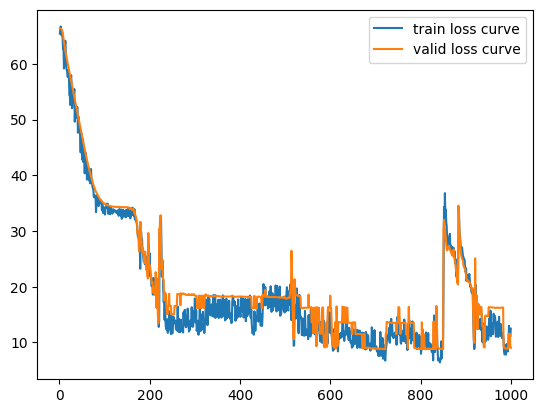

In [338]:
plt.plot(range(1, NUM_EPOCHS + 1), results['train_loss']);
plt.plot(range(1, NUM_EPOCHS + 1), results['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])

In [339]:
# Put model in evaluation mode
model.eval()

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for data, targets in test_dataloader:
        # Send data to target device
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        predictions = model(data)

        # Calculate and accumulate loss
        loss = loss_fn(targets, predictions)

pd.DataFrame(
    {
        'targets': targets.cpu().squeeze(),
        'predictions': predictions.cpu().squeeze()
    },
    index=range(len(targets.cpu()))
)

,targets,predictions
0,36.363636,34.239334
1,36.363636,36.247234
2,81.818184,88.395660
3,90.909088,88.465050
4,90.909088,88.419579
5,100.000000,88.494156
6,38.888889,87.758347
7,38.888889,87.858849
8,83.333336,88.458168
9,94.444443,88.486488
